In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score

LGB_SEED = 1337
XGB_SEED = 5041992
CB_SEED = 7021991

print(f'LightGBM Version: {lgb.__version__} - Seed: {LGB_SEED}')
print(f'XGBoost Version: {xgb.__version__} - Seed: {XGB_SEED}')
print(f'CatBoost Version: {cb.__version__} - Seed: {CB_SEED}')

LightGBM Version: 2.3.1 - Seed: 1337
XGBoost Version: 1.0.2 - Seed: 5041992
CatBoost Version: 0.23 - Seed: 7021991


In [2]:
df_train = pd.read_pickle('../input/ion-switching-preprocessing/train.pkl')
df_test = pd.read_pickle('../input/ion-switching-preprocessing/test.pkl')
    
df_test.loc[df_test['model'] == 1.5, 'model'] = 2
df_train['is_filtered'] = df_train['is_filtered'].astype(np.uint8)
df_train['model'] = df_train['model'].astype(np.uint8)
df_test['model'] = df_test['model'].astype(np.uint8)
    
for df in [df_train, df_test]:
    df.drop(columns=['signal', 'time_scaled', 'signal_processed_kalman', 'batch'], inplace=True)
    
df_train['signal_processed_original'] = df_train['signal_processed']
df_test['signal_processed_original'] = df_test['signal_processed']
df_train['signal_processed'] = df_train['signal_processed_denoised']
df_test['signal_processed'] = df_test['signal_processed_denoised']

for df in [df_train, df_test]:
    df.drop(columns=['signal_processed_denoised'], inplace=True)

print(f'Training Set Shape: {df_train.shape}')
print(f'Test Set Shape: {df_test.shape}')
print(f'Training Set Memory Usage: {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Test Set Memory Usage: {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Set Shape: (5000000, 6)
Test Set Shape: (2000000, 4)
Training Set Memory Usage: 71.53 MB
Test Set Memory Usage: 24.80 MB


## **1. Models and Cross-validation**

### **1.1. Models**

`model` is a categorical feature created in this preprocessing kernel [here](https://www.kaggle.com/gunesevitan/ion-switching-preprocessing#4.-Models). It is very similar to `batch` feature but it groups similar distributions together.

* Model 0 (Training Batch 0 and 1)
* Model 1 (Training Batch 2 and 6)
* Model 1.5 (Test Batch 2 and 3)
* Model 2 (Training Batch 3 and 7)
* Model 3 (Training Batch 5 and 8)
* Model 4 (Training Batch 4 and 9)

There are **6** different distributions in the dataset. Those distributions are named **Model 0**, **Model 1**, **Model 1.5**, **Model 2**, **Model 3**, **Model 4**. 6th distribution is **Model 1.5** and it only exists in test set. Those distributions are not completely different from each other which makes it possible to train them separately and together. **Model 1.5** doesn't exist in training set so it is named as **Model 2** for training convenience.

* Training them separately works better for **Model 0** and **Model 1** because when those distributions are isolated from rest of the data, models can learn only the relevant things about them. They are both binary classification problems but regression models worked better in every case. When those models are trained with additional data, their cross-validation scores doesn't improve too much.
* Training them together works better for **Model 2**, **Model 3**, **Model 4** and probably **Model 1.5** because preceeding models' classes also exist in the current models. Data augmentation from the previous models improve the current models' cross-validation scores.

For example **Model 0**'s and **Model 1**'s data exist in **Model 2**, however **Model 2** doesn't exist in those two. In this case; **Model 0** trained with only **Model 0** data performs better than **Model 0** trained with **Model 0**, **Model 1** and **Model 2** data. However, **Model 0** and **Model 1** exist in **Model 2**, so **Model 2** trained with **Model 0**, **Model 1** and **Model 2** data performs better than **Model 2** trained with only **Model 2** data.

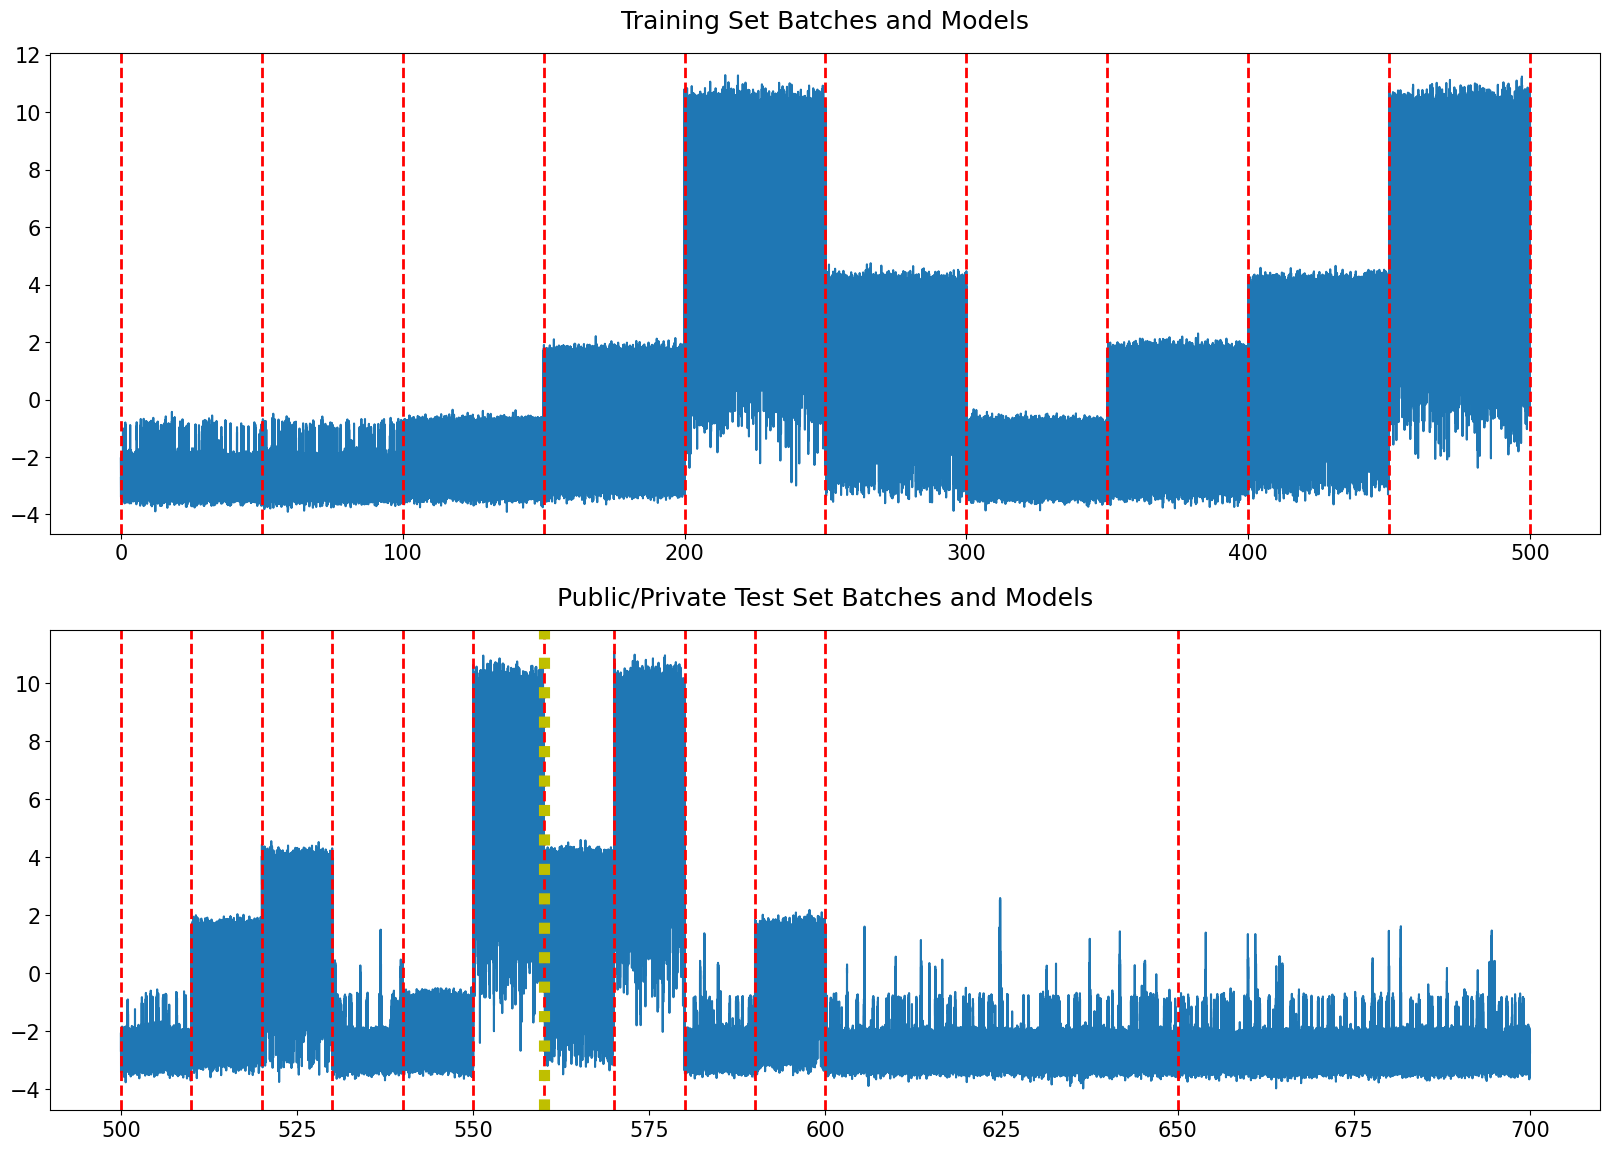

In [3]:
fig, axes = plt.subplots(nrows=2, figsize=(20, 14), dpi=100)

df_train.set_index('time')['signal_processed'].plot(ax=axes[0])
for batch in np.arange(0, 550, 50):
    axes[0].axvline(batch, color='r', linestyle='--', lw=2)
    
df_test.set_index('time')['signal_processed'].plot(ax=axes[1])

for batch in np.arange(500, 600, 10):
    axes[1].axvline(batch, color='r', linestyle='--', lw=2)
for batch in np.arange(600, 700, 50):
    axes[1].axvline(batch, color='r', linestyle='--', lw=2)
    
axes[1].axvline(560, color='y', linestyle='dotted', lw=8)

for i in range(2):            
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', labelsize=15)
    axes[i].tick_params(axis='y', labelsize=15)
    
axes[0].set_title('Training Set Batches and Models', size=18, pad=18)
axes[1].set_title('Public/Private Test Set Batches and Models', size=18, pad=18)

plt.show()

Even though separately trained **Model 2**, **Model 3** and **Model 4** perform worse, they can be used for blending. They can still take the larger models to a next level. In order to make an efficient ensemble, there should be **27** gbdt models and those models are:

#### **Solo Models (15 Models)**

  * Model 0 (Batch 0 and 1) LightGBM, XGBoost, CatBoost
  * Model 1 (Batch 2 and 6) LightGBM, XGBoost, CatBoost
  * Model 2 (Batch 3 and 7) LightGBM, XGBoost, CatBoost
  * Model 3 (Batch 5 and 8) LightGBM, XGBoost, CatBoost
  * Model 4 (Batch 4 and 9) LightGBM, XGBoost, CatBoost
  
#### **Multiple Models (12 Models)**

  * Duo Model 0-1 (Batch 0, 1, 2, 6) LightGBM, XGBoost, CatBoost
  * Trio Model 0-1-2 (Batch 0, 1, 2, 3, 6, 7) LightGBM, XGBoost, CatBoost
  * Quad Model 0-1-2-3 (Batch 0, 1, 2, 3, 5, 6, 7, 8) LightGBM, XGBoost, CatBoost
  * Penta Model 0-1-2-3-4 (All Batches) LightGBM, XGBoost, CatBoost

Every different distribution is a blend of **6** different model predictions. For **Model 0** and **Model 1** solo models' predictions are given equal weights with multiple models' predictions. For **Model 2**, **Model 3** and **Model 4** multiple models' predictions are given higher weights and solo models' predictions are given lower weights.

* **Model 0** is predicted by Solo Model 0 LightGBM, XGBoost, CatBoost (Equal Weights) and Duo Model LightGBM, XGBoost, CatBoost (Equal Weights)
* **Model 1** is predicted by Solo Model 1 LightGBM, XGBoost, CatBoost (Equal Weights) and Duo Model LightGBM, XGBoost, CatBoost (Equal Weights)
* **Model 2** and **Model 1.5** are predicted by Solo Model 2 LightGBM, XGBoost, CatBoost (Lower Weights) and Trio Model LightGBM, XGBoost, CatBoost (Higher Weights)
* **Model 3** is predicted by Solo Model 3 LightGBM, XGBoost, CatBoost (Lower Weights) and Quad Model LightGBM, XGBoost, CatBoost (Higher Weights)
* **Model 4** is predicted by Solo Model 4 LightGBM, XGBoost, CatBoost (Lower Weights) and Penta Model LightGBM, XGBoost, CatBoost (Higher Weights)

### **1.2. Cross-validation**

Solo and multiple model setup requires two different cross-validation techniques but they have the same logic. That logic is training in one batch and validate on the other similar batch. It is very simple for solo models and it can be implemented with regular **2** `KFold`. For multiple models, `StratifiedKFold` has to be used because training and validation sets have to be stratified on `model` feature.

#### **Solo Models' Cross-validation**

* Train on Batch **0** - Validate on Batch **1** then Train on Batch **1** - Validate on Batch **0** (**Solo Model 0**)
* Train on Batch **2** - Validate on Batch **6** then Train on Batch **6** - Validate on Batch **2** (**Solo Model 1**)
* Train on Batch **3** - Validate on Batch **7** then Train on Batch **7** - Validate on Batch **3** (**Solo Model 2**)
* Train on Batch **5** - Validate on Batch **8** then Train on Batch **8** - Validate on Batch **5** (**Solo Model 3**)
* Train on Batch **4** - Validate on Batch **9** then Train on Batch **9** - Validate on Batch **4** (**Solo Model 4**)

#### **Multiple Models' Cross-validation**

* Train on Batch **0**, **2** - Validate on Batch **1**, **6** then Train on Batch **1**, **6** - Validate on Batch **0**, **2** (**Duo Model**)
* Train on Batch **0**, **2**, **3** - Validate on Batch **1**, **6**, **7** then Train on Batch **1**, **6**, **7** - Validate on Batch **0**, **2**, **3** (**Trio Model**)
* Train on Batch **0**, **2**, **3**, **5** - Validate on Batch **1**, **6**, **7**, **8** then Train on Batch **1**, **6**, **7**, **8** - Validate on Batch **0**, **2**, **3**, **5** (**Quad Model**)
* Train on Batch **0**, **2**, **3**, **4**, **5** - Validate on Batch **1**, **6**, **7**, **8**, **9** then Train on Batch **1**, **6**, **7**, **8**, **9** - Validate on Batch **0**, **2**, **3**, **4**, **5** (**Penta Model**)

I believe this is the perfect cross-validation technique for this competition because batches are independent. It can observe how good the models are generalizing on different similar distributions.

## **2. Features**
All of the models are trained with different features for the sake of diversity but some of the features are too good that they can't be changed. Those are the type of features used in the models:

* `signal_processed` (Drift, ghost drift and electric noise removed `signal`)
* `model`(A categorical feature which identifies the 5 different distributions)
* Lag and Lead Features (Features created with `shift`, `diff` and `pct_change`)
* Brute Forced Rolling Window Features (Features created with both centered and regular rolling window between `5` to `200` window sizes) 
* Transformation Features on `signal_processed` (Features created with `square`, `square root`, `cube`, `cube root`, `abs`, `exp` and etc.)
* Features that don't make any sense but work on synthetic data (Fraction of `signal_processed`)

## **3. Solo Models**
`MultiModelGBDTEnsemble` is a wrapper that incorporates the cross-validation stated above for solo models. Solo models are good at predicting binary distributions which are **Model 0** and **Model 1**, but they are bad at predicting **Model 2**, **Model 3**, and **Model 4**.

The wrapper has LightGBM, XGBoost and CatBoost models. It can be run with `LightGBM`, `XGBoost` or `CatBoost` parameter so the corresponding model trains and predicts the given distribution. If `Blend` is selected for `model` parameter, `MultiModelGBDTEnsemble` runs all the models together and then blends their scores equally.

After training and predicting the given distribution, `MultiModelGBDTEnsemble` plots the feature importance of model(s) by gain.

In [4]:
class MultiModelGBDTEnsemble:
        
    def __init__(self,lgb_parameters, xgb_parameters, cb_parameters, model):  
        
        self.K = 2
        self.kf = KFold(n_splits=self.K)
        self.model = model
        
        self.lgb_parameters = lgb_parameters        
        self.xgb_parameters = xgb_parameters        
        self.cb_parameters = cb_parameters
        
    def _lightgbm_train_and_predict(self, X_train, y_train, X_test, weight, model):
        
        print(f'\n########## Running Solo LightGBM Model {model} ##########')
        
        self.lgb_scores = []
        self.lgb_oof = np.zeros(X_train.shape[0])
        self.lgb_y_pred = pd.DataFrame(np.zeros((X_test.shape[0], self.K)), columns=[f'Fold_{i}_Predictions' for i in range(1, self.K + 1)]) 
        self.lgb_importance = pd.DataFrame(np.zeros((X_train.shape[1], self.K)), columns=[f'Fold_{i}_Importance' for i in range(1, self.K + 1)], index=X_train.columns)
        
        for fold, (trn_idx, val_idx) in enumerate(self.kf.split(X_train, y_train), 1):
            print(f'\nFold {fold}')

            lgb_trn_data = lgb.Dataset(X_train.iloc[trn_idx, :], label=y_train.iloc[trn_idx], weight=weight[trn_idx])
            lgb_val_data = lgb.Dataset(X_train.iloc[val_idx, :], label=y_train.iloc[val_idx])    
            lgb_model = lgb.train(self.lgb_parameters, lgb_trn_data, valid_sets=[lgb_trn_data, lgb_val_data], verbose_eval=50)

            lgb_oof_predictions = lgb_model.predict(X_train.iloc[val_idx, :], num_iteration=lgb_model.best_iteration)
            self.lgb_oof[val_idx] = lgb_oof_predictions
            df_train.loc[X_train.iloc[val_idx, :].index, 'lgb_solo_model_oof'] = lgb_oof_predictions

            lgb_test_predictions = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)
            self.lgb_y_pred.iloc[:, fold - 1] = lgb_test_predictions
            df_test.loc[X_test.index, f'fold{fold}_lgb_solo_model_predictions'] = lgb_test_predictions

            self.lgb_importance.iloc[:, fold - 1] = lgb_model.feature_importance(importance_type='gain')
            lgb_score = f1_score(y_train.iloc[val_idx].values, np.round(np.clip(lgb_oof_predictions, y_train.min(), y_train.max())), average='macro')
            self.lgb_scores.append(lgb_score)            
            print('\nSolo LGB Fold {} Macro F1-Score {}\n'.format(fold, lgb_score))
            
        print('--------------------')
        print(f'Solo LGB Mean Macro F1-Score {np.mean(self.lgb_scores):.6} [STD:{np.std(self.lgb_scores):.6}]')
        print(f'Solo LGB Model {model} OOF (Rounded) Macro F1-Score {f1_score(y_train, np.round(np.clip(self.lgb_oof, y_train.min(), y_train.max())), average="macro"):.6}')
        print('--------------------')
        
    def _xgboost_train_and_predict(self, X_train, y_train, X_test, num_boosting_round, early_stopping_rounds, weight, model):
        
        print(f'\n########## Running Solo XGBoost Model {model} ##########')
        
        self.xgb_scores = []
        self.xgb_oof = np.zeros(X_train.shape[0])
        self.xgb_y_pred = pd.DataFrame(np.zeros((X_test.shape[0], self.K)), columns=[f'Fold_{i}_Predictions' for i in range(1, self.K + 1)])
        self.xgb_importance = pd.DataFrame(np.zeros((X_train.shape[1], self.K)), columns=[f'Fold_{i}_Importance' for i in range(1, self.K + 1)], index=X_train.columns)
        
        for fold, (trn_idx, val_idx) in enumerate(self.kf.split(X_train, y_train), 1):
            print(f'\nFold {fold}')
            
            xgb_trn_data = xgb.DMatrix(X_train.iloc[trn_idx, :], label=y_train.iloc[trn_idx], weight=weight[trn_idx])
            xgb_val_data = xgb.DMatrix(X_train.iloc[val_idx, :], label=y_train.iloc[val_idx])
            xgb_model = xgb.train(self.xgb_parameters, xgb_trn_data, num_boosting_round, evals=[(xgb_trn_data, 'train'), (xgb_val_data, 'val')], verbose_eval=50, early_stopping_rounds=early_stopping_rounds)

            xgb_oof_predictions = xgb_model.predict(xgb.DMatrix(X_train.iloc[val_idx, :]))
            self.xgb_oof[val_idx] = xgb_oof_predictions
            df_train.loc[X_train.iloc[val_idx, :].index, 'xgb_solo_model_oof'] = xgb_oof_predictions

            xgb_test_predictions = xgb_model.predict(xgb.DMatrix(X_test))
            self.xgb_y_pred.iloc[:, fold - 1] = xgb_test_predictions
            df_test.loc[X_test.index, f'fold{fold}_xgb_solo_model_predictions'] = xgb_test_predictions

            self.xgb_importance.iloc[:, fold - 1] = list(xgb_model.get_score(importance_type='gain').values())
            xgb_score = f1_score(y_train.iloc[val_idx].values, np.round(np.clip(xgb_oof_predictions, y_train.min(), y_train.max())), average='macro')
            self.xgb_scores.append(xgb_score)            
            print('Solo XGB Fold {} Macro F1-Score {}\n'.format(fold, xgb_score))
            
        print('--------------------')
        print(f'Solo XGB Mean Macro F1-Score {np.mean(self.xgb_scores):.6} [STD:{np.std(self.xgb_scores):.6}]')
        print(f'Solo XGB Model {model} OOF (Rounded) Macro F1-Score {f1_score(y_train, np.round(np.clip(self.xgb_oof, y_train.min(), y_train.max())), average="macro"):.6}')
        print('--------------------')
        
    def _catboost_train_and_predict(self, X_train, y_train, X_test, weight, model):
        
        print(f'\n########## Running Solo CatBoost Model {model} ##########')
        
        self.cb_scores = []      
        self.cb_oof = np.zeros(X_train.shape[0])        
        self.cb_y_pred = pd.DataFrame(np.zeros((X_test.shape[0], self.K)), columns=[f'Fold_{i}_Predictions' for i in range(1, self.K + 1)]) 
        self.cb_importance = pd.DataFrame(np.zeros((X_train.shape[1], self.K)), columns=[f'Fold_{i}_Importance' for i in range(1, self.K + 1)], index=X_train.columns)
        
        for fold, (trn_idx, val_idx) in enumerate(self.kf.split(X_train, y_train), 1):
            print(f'\nFold {fold}')
            
            cb_trn_data = cb.Pool(X_train.iloc[trn_idx, :], label=y_train.iloc[trn_idx], weight=weight[trn_idx]) 
            cb_val_data = cb.Pool(X_train.iloc[val_idx, :], label=y_train.iloc[val_idx])            
            cb_model = cb.CatBoostRegressor(**self.cb_parameters)
            cb_model.fit(cb_trn_data)
            
            cb_oof_predictions = cb_model.predict(cb_val_data)
            self.cb_oof[val_idx] = cb_oof_predictions
            df_train.loc[X_train.iloc[val_idx, :].index, 'cb_solo_model_oof'] = cb_oof_predictions
            
            cb_test_predictions = cb_model.predict(cb.Pool(X_test))
            self.cb_y_pred.iloc[:, fold - 1] = cb_test_predictions
            df_test.loc[X_test.index, f'fold{fold}_cb_solo_model_predictions'] = cb_test_predictions
            
            self.cb_importance.iloc[:, fold - 1] = cb_model.get_feature_importance()
            cb_score = f1_score(y_train.iloc[val_idx].values, np.round(np.clip(cb_oof_predictions, y_train.min(), y_train.max())), average='macro')
            self.cb_scores.append(cb_score)            
            print('\nSolo CB Fold {} Macro F1-Score {}\n'.format(fold, cb_score))
            
        print('--------------------')
        print(f'Solo CB Mean Macro F1-Score {np.mean(self.cb_scores):.6} [STD:{np.std(self.cb_scores):.6}]')
        print(f'Solo CB Model {model} OOF (Rounded) Macro F1-Score {f1_score(y_train, np.round(np.clip(self.cb_oof, y_train.min(), y_train.max())), average="macro"):.6}')
        print('--------------------')
                
    def train_and_predict(self, 
                          lgb_X_train, lgb_y_train, lgb_X_test,
                          xgb_X_train, xgb_y_train, xgb_X_test,
                          cb_X_train, cb_y_train, cb_X_test,
                          num_boosting_round=100, early_stopping_rounds=25,
                          lgb_sample_weight=None, xgb_sample_weight=None, cb_sample_weight=None, model=None):

        if self.model == 'LightGBM':
            self._lightgbm_train_and_predict(lgb_X_train, lgb_y_train, lgb_X_test, weight=lgb_sample_weight, model=model)
        elif self.model == 'XGBoost':
            self._xgboost_train_and_predict(xgb_X_train, xgb_y_train, xgb_X_test, num_boosting_round=num_boosting_round, early_stopping_rounds=early_stopping_rounds, weight=xgb_sample_weight, model=model)
        elif self.model == 'CatBoost':
            self._catboost_train_and_predict(cb_X_train, cb_y_train, cb_X_test, weight=cb_sample_weight, model=model)
        elif self.model == 'Blend':
            self._lightgbm_train_and_predict(lgb_X_train, lgb_y_train, lgb_X_test, weight=lgb_sample_weight, model=model)
            self._xgboost_train_and_predict(xgb_X_train, xgb_y_train, xgb_X_test, num_boosting_round=num_boosting_round, early_stopping_rounds=early_stopping_rounds, weight=xgb_sample_weight, model=model)
            self._catboost_train_and_predict(cb_X_train, cb_y_train, cb_X_test, weight=cb_sample_weight, model=model)
            
            self.blend_oof = (self.lgb_oof * 0.34) + (self.xgb_oof * 0.33) + (self.cb_oof * 0.33)
            print(f'Solo Model {model} Equal Blend OOF (Rounded) Macro F1-Score {f1_score(lgb_y_train, np.round(np.clip(self.blend_oof, lgb_y_train.min(), lgb_y_train.max())), average="macro")}\n')
            
    def plot_importance(self):
        
        if self.model == 'Blend':
            self.lgb_importance['Mean_Importance'] = self.lgb_importance.sum(axis=1) / self.K
            self.lgb_importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)
            self.xgb_importance['Mean_Importance'] = self.xgb_importance.sum(axis=1) / self.K
            self.xgb_importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)
            self.cb_importance['Mean_Importance'] = self.cb_importance.sum(axis=1) / self.K
            self.cb_importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)
            
            fig, axs = plt.subplots(nrows=3, figsize=(20, 40))
            
            sns.barplot(x='Mean_Importance', y=self.lgb_importance.index, data=self.lgb_importance, ax=axs[0])
            sns.barplot(x='Mean_Importance', y=self.xgb_importance.index, data=self.xgb_importance, ax=axs[1])
            sns.barplot(x='Mean_Importance', y=self.cb_importance.index, data=self.cb_importance, ax=axs[2])
            
            for i in range(3):
                axs[i].set_xlabel('')
                axs[i].tick_params(axis='x', labelsize=20)
                axs[i].tick_params(axis='y', labelsize=20)
                
            axs[0].set_title(f'Solo LightGBM Feature Importance (Gain)', size=20, pad=20)
            axs[1].set_title(f'Solo XGBoost Feature Importance (Gain)', size=20, pad=20)
            axs[2].set_title(f'Solo CatBoost Feature Importance (Gain)', size=20, pad=20)
            
        else:
            plt.figure(figsize=(20, 6))
        
        if self.model == 'LightGBM':
            self.lgb_importance['Mean_Importance'] = self.lgb_importance.sum(axis=1) / self.K
            self.lgb_importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)
            sns.barplot(x='Mean_Importance', y=self.lgb_importance.index, data=self.lgb_importance)
        elif self.model == 'XGBoost':
            self.xgb_importance['Mean_Importance'] = self.xgb_importance.sum(axis=1) / self.K
            self.xgb_importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)
            sns.barplot(x='Mean_Importance', y=self.xgb_importance.index, data=self.xgb_importance)
        elif self.model == 'CatBoost':
            self.cb_importance['Mean_Importance'] = self.cb_importance.sum(axis=1) / self.K
            self.cb_importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)
            sns.barplot(x='Mean_Importance', y=self.cb_importance.index, data=self.cb_importance)
        
        if self.model != 'Blend':
            plt.xlabel('')
            plt.tick_params(axis='x', labelsize=20)
            plt.tick_params(axis='y', labelsize=20)
            plt.title(f'Solo {self.model} Feature Importance (Gain)', size=20, pad=20)

        plt.show()


### **3.1. Solo Model 0**

#################### SOLO MODEL 0 ####################
------------------------------------------------------

########## Running Solo LightGBM Model 0 ##########

Fold 1
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.016144	valid_1's rmse: 0.0151078
[100]	training's rmse: 0.012989	valid_1's rmse: 0.0146906
Early stopping, best iteration is:
[77]	training's rmse: 0.014177	valid_1's rmse: 0.0145977

Solo LGB Fold 1 Macro F1-Score 0.9978689056116359


Fold 2
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.013728	valid_1's rmse: 0.0192845
[100]	training's rmse: 0.0106513	valid_1's rmse: 0.0183789
Early stopping, best iteration is:
[97]	training's rmse: 0.0107767	valid_1's rmse: 0.0183684

Solo LGB Fold 2 Macro F1-Score 0.9973912116650485

--------------------
Solo LGB Mean Macro F1-Score 0.99763 [STD:0.000238847]
Solo LGB Model 0 OOF (Rounded) Macro F1-Score 0.997608
--------------------

########## Running Solo XG

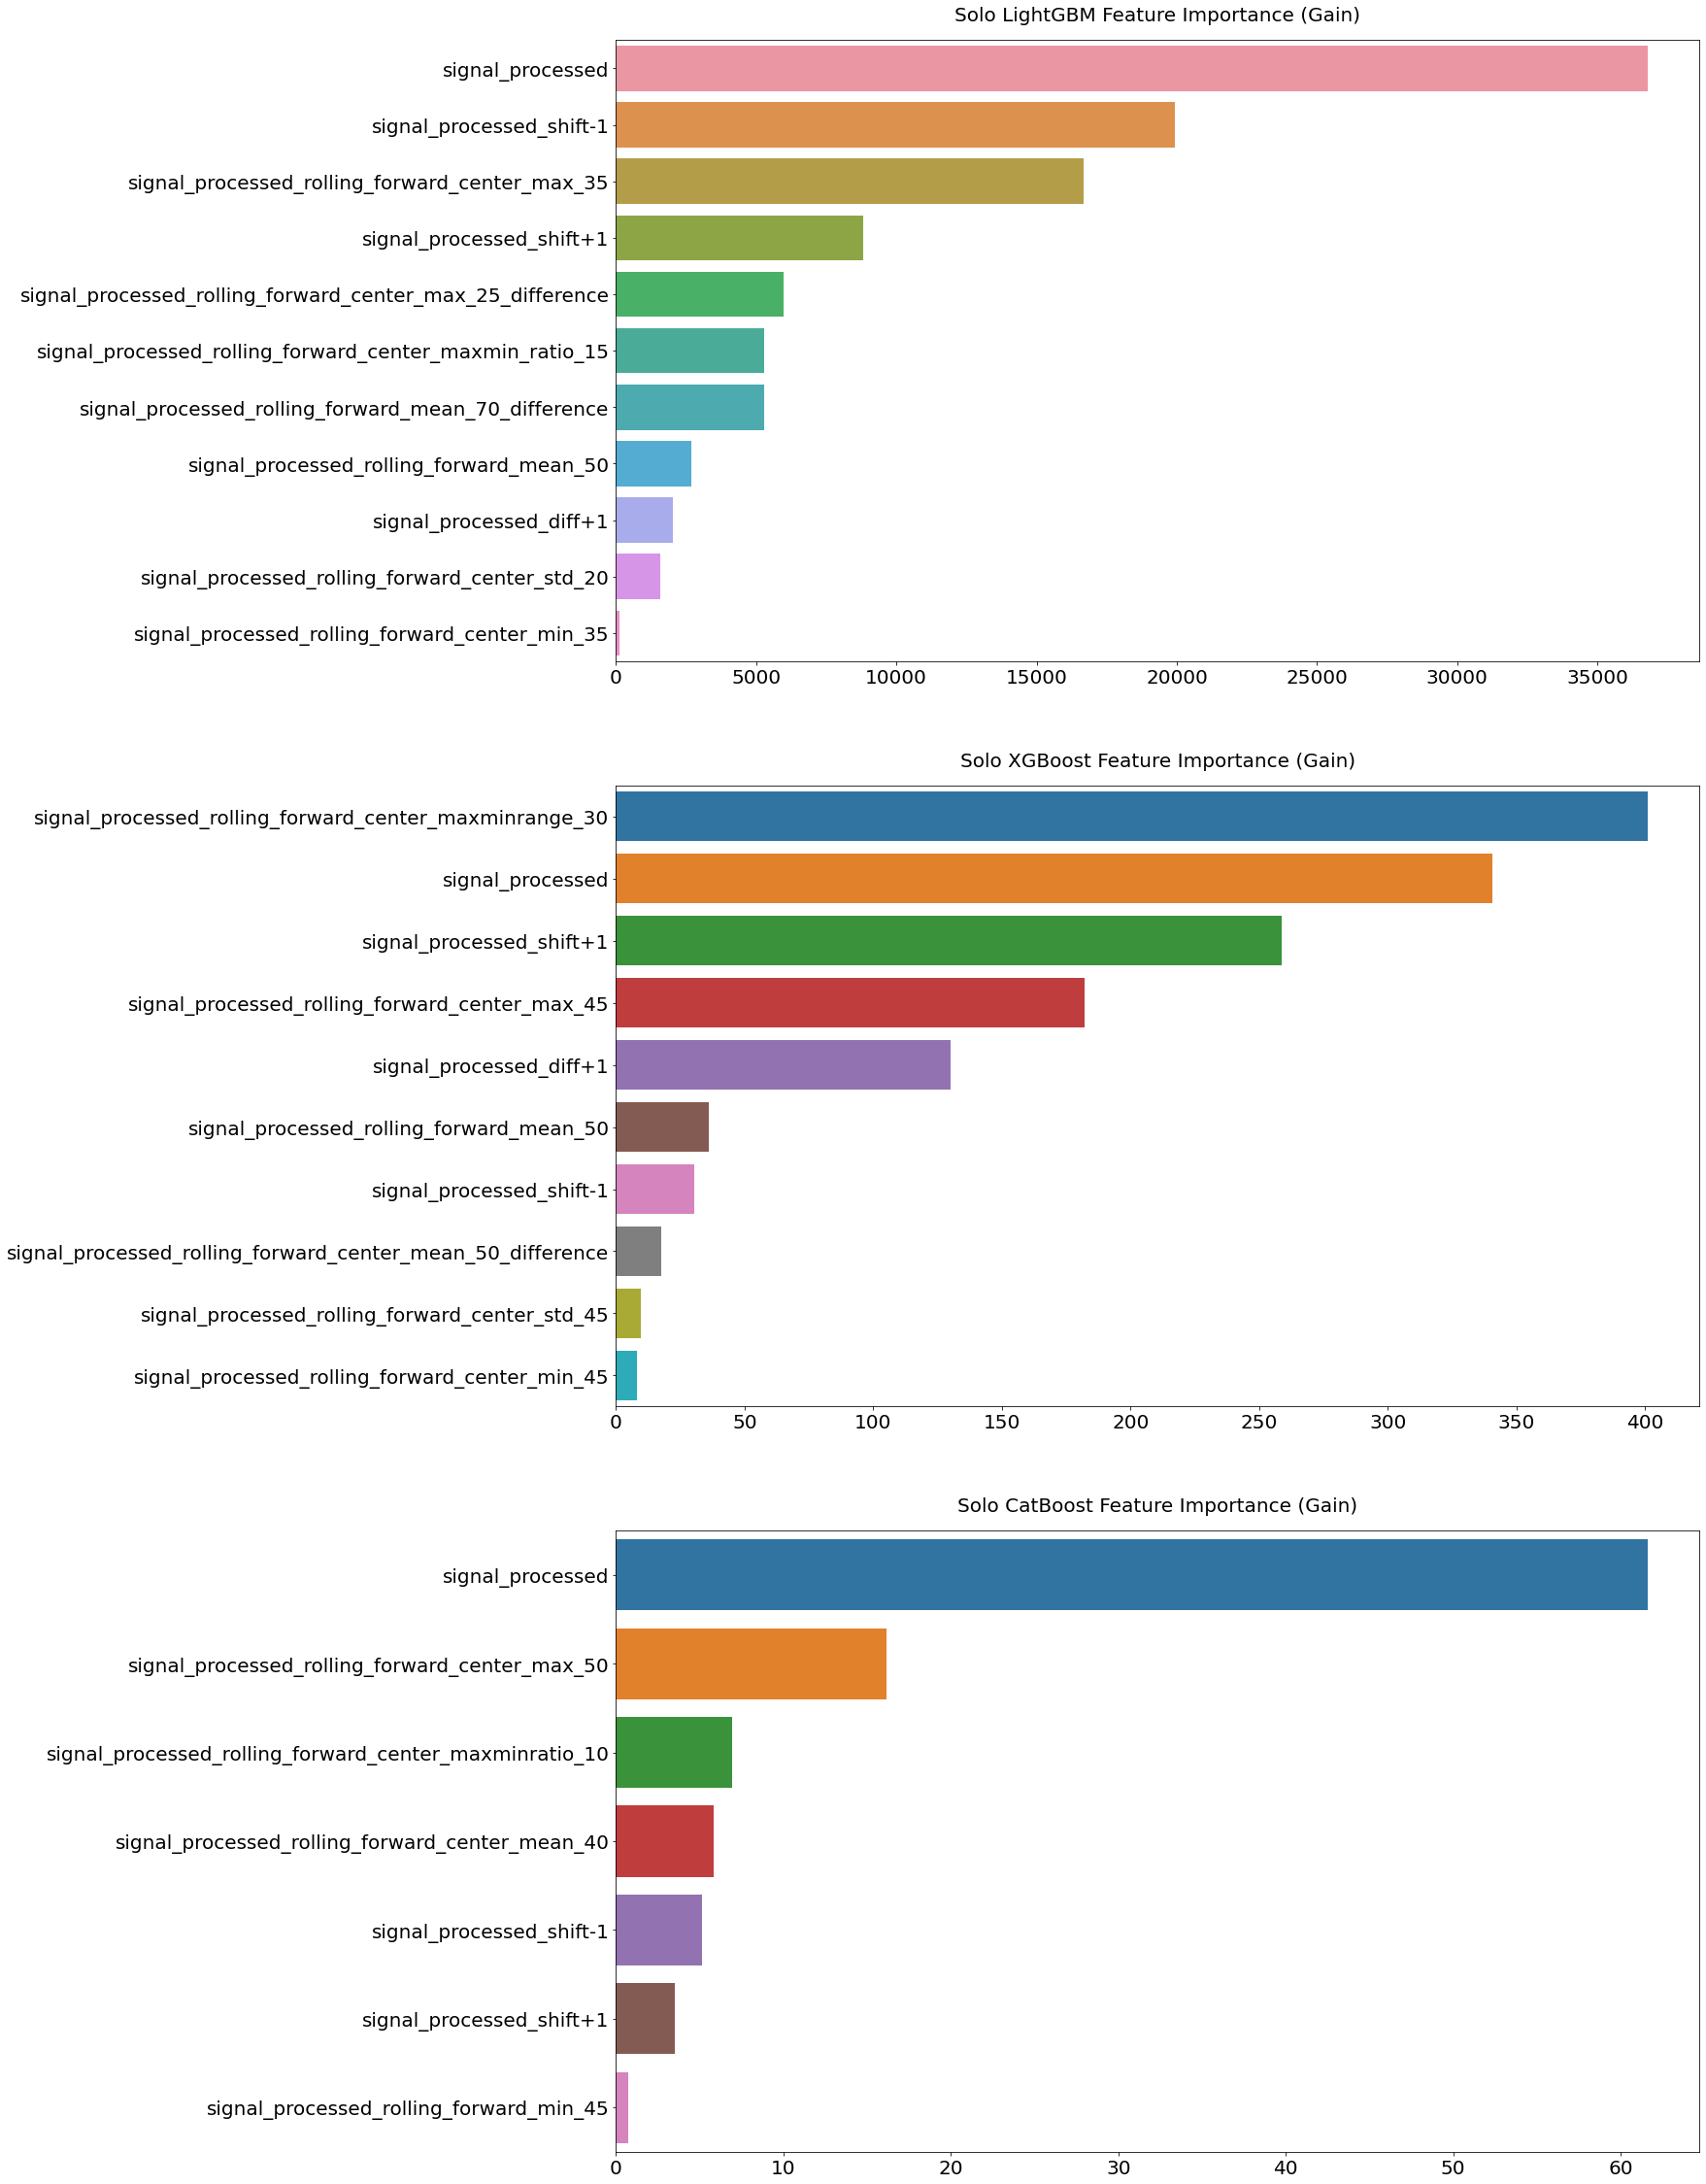

In [5]:
#################### SOLO MODEL 0 ####################

print('#################### SOLO MODEL 0 ####################')
print('------------------------------------------------------')

########## SOLO MODEL 0 LGB ##########

model0_lgb_features = ['signal_processed']
model0_lgb_X_train = df_train[df_train['model'] == 0][model0_lgb_features].copy(deep=True)
model0_lgb_y_train = df_train[df_train['model'] == 0]['open_channels'].copy(deep=True)
model0_lgb_X_test = df_test[df_test['model'] == 0][model0_lgb_features].copy(deep=True)

model0_lgb_sample_weight = model0_lgb_y_train.copy(deep=True).reset_index(drop=True)
model0_lgb_sample_weight.loc[model0_lgb_sample_weight == 0] = 1
model0_lgb_sample_weight.loc[model0_lgb_sample_weight == 1] = 1

for df in [model0_lgb_X_train, model0_lgb_X_test]:
    for shift in range(1, 2):
        df[f'signal_processed_shift+{shift}'] = df['signal_processed'].shift(shift)
        df[f'signal_processed_shift-{shift}'] = df['signal_processed'].shift(-shift)
    df['signal_processed_rolling_forward_mean_50'] = df['signal_processed'].rolling(window=50, min_periods=1, center=False).mean()
    df['signal_processed_rolling_forward_center_std_20'] = df['signal_processed'].rolling(window=20, min_periods=1, center=True).std()
    df['signal_processed_rolling_forward_mean_70_difference'] = df['signal_processed'] - df['signal_processed'].rolling(window=70, min_periods=1, center=False).mean()
    df['signal_processed_rolling_forward_center_max_25_difference'] = df['signal_processed'] - df['signal_processed'].rolling(window=25, min_periods=1, center=True).max()
    df['signal_processed_diff+1'] = df['signal_processed'].diff(1)
    df['signal_processed_rolling_forward_center_min_35'] = df['signal_processed'].rolling(window=35, min_periods=1, center=True).min()
    df['signal_processed_rolling_forward_center_max_35'] = df['signal_processed'].rolling(window=35, min_periods=1, center=True).max()
    df['signal_processed_rolling_forward_center_maxmin_ratio_15'] = df['signal_processed'].rolling(window=15, min_periods=1, center=False).max() / df['signal_processed'].rolling(window=15, min_periods=1, center=False).min()

model0_lgb_parameters = {
    'num_iterations': 250,
    'early_stopping_round': 50,
    'num_leaves': 2 ** 7, 
    'learning_rate': 0.075,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.5,
    'feature_fraction_bynode': 0.5,
    'min_data_in_leaf': 20,
    'lambda_l1': 0.5,
    'lambda_l2': 0,
    'max_depth': -1,
    'objective': 'regression',
    'seed': LGB_SEED,
    'feature_fraction_seed': LGB_SEED,
    'bagging_seed': LGB_SEED,
    'drop_seed': LGB_SEED,
    'data_random_seed': LGB_SEED,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric': 'rmse',
    'n_jobs': -1,
}

########## SOLO MODEL 0 XGB ##########

model0_xgb_features = ['signal_processed']
model0_xgb_X_train = df_train[df_train['model'] == 0][model0_xgb_features].copy(deep=True)
model0_xgb_y_train = df_train[df_train['model'] == 0]['open_channels'].copy(deep=True)
model0_xgb_X_test = df_test[df_test['model'] == 0][model0_xgb_features].copy(deep=True)

model0_xgb_sample_weight = model0_xgb_y_train.copy(deep=True).reset_index(drop=True)
model0_xgb_sample_weight.loc[model0_xgb_sample_weight == 0] = 1
model0_xgb_sample_weight.loc[model0_xgb_sample_weight == 1] = 1

for df in [model0_xgb_X_train, model0_xgb_X_test]:
    for shift in range(1, 2):
        df[f'signal_processed_shift+{shift}'] = df['signal_processed'].shift(shift).fillna(0)
        df[f'signal_processed_shift-{shift}'] = df['signal_processed'].shift(-shift).fillna(0)
    df['signal_processed_rolling_forward_mean_50'] = df['signal_processed'].rolling(window=50, min_periods=1, center=False).mean()
    df['signal_processed_rolling_forward_center_std_45'] = df['signal_processed'].rolling(window=45, min_periods=1, center=True).std()
    df['signal_processed_rolling_forward_center_min_45'] = df['signal_processed'].rolling(window=20, min_periods=1, center=True).min()
    df['signal_processed_rolling_forward_center_max_45'] = df['signal_processed'].rolling(window=20, min_periods=1, center=True).max()
    df['signal_processed_rolling_forward_center_maxminrange_30'] = df['signal_processed'].rolling(window=30, min_periods=1, center=True).max() - df['signal_processed'].rolling(window=30, min_periods=1, center=True).min()
    df['signal_processed_diff+1'] = df['signal_processed'].diff(1).fillna(0)
    df['signal_processed_rolling_forward_center_mean_50_difference'] = df['signal_processed'] - df['signal_processed'].rolling(window=20, min_periods=1, center=False).mean()

model0_xgb_parameters = {
    'n_estimators': 2 ** 8, 
    'learning_rate': 0.05,
    'colsample_bytree': 0.8, 
    'colsample_bylevel': 0.8,
    'colsample_bynode': 0.8,
    'sumbsample': 0.9,
    'max_depth': 5,
    'gamma': 0.75,
    'min_child_weight': 1,
    'lambda': 1,
    'alpha': 0.1,
    'objective': 'reg:squarederror',
    'seed': XGB_SEED,
    'boosting_type': 'gbtree',
    'tree_method': 'auto',
    'silent': True,
    'verbose': 1,
    'n_jobs': -1,
}

########## SOLO MODEL 0 CB ##########

model0_cb_features = ['signal_processed']
model0_cb_X_train = df_train[df_train['model'] == 0][model0_cb_features].copy(deep=True)
model0_cb_y_train = df_train[df_train['model'] == 0]['open_channels'].copy(deep=True)
model0_cb_X_test = df_test[df_test['model'] == 0][model0_cb_features].copy(deep=True)

model0_cb_sample_weight = model0_cb_y_train.copy(deep=True).reset_index(drop=True)
model0_cb_sample_weight.loc[model0_cb_sample_weight == 0] = 1
model0_cb_sample_weight.loc[model0_cb_sample_weight == 1] = 1

for df in [model0_cb_X_train, model0_cb_X_test]:
    for shift in range(1, 2):
        df[f'signal_processed_shift+{shift}'] = df['signal_processed'].shift(shift).fillna(0)
        df[f'signal_processed_shift-{shift}'] = df['signal_processed'].shift(-shift).fillna(0)
    df['signal_processed_rolling_forward_center_mean_40'] = df['signal_processed'].rolling(window=40, min_periods=1, center=True).mean()
    df['signal_processed_rolling_forward_min_45'] = df['signal_processed'].rolling(window=45, min_periods=1, center=False).min()
    df['signal_processed_rolling_forward_center_max_50'] = df['signal_processed'].rolling(window=50, min_periods=1, center=True).max()
    df['signal_processed_rolling_forward_center_maxminratio_10'] = df['signal_processed'].rolling(window=25, min_periods=1, center=True).max() / df['signal_processed'].rolling(window=25, min_periods=1, center=True).min()
    
model0_cb_parameters = {
    'n_estimators': 250, 
    'learning_rate': 0.06,
    'depth': 6,
    'subsample': 0.7,
    'bagging_temperature': 1,
    'colsample_bylevel': 0.6,
    'l2_leaf_reg': 0.04,
    'metric_period': 50,
    'boost_from_average': True,
    'eval_metric': 'RMSE',
    'loss_function': 'RMSE',    
    'random_seed': CB_SEED,
    'verbose': 1,
}

########## SOLO MODEL 0 TRAINING ##########

solo_model0 = MultiModelGBDTEnsemble(lgb_parameters=model0_lgb_parameters,
                                     xgb_parameters=model0_xgb_parameters, 
                                     cb_parameters=model0_cb_parameters,
                                     model='Blend')

solo_model0.train_and_predict(lgb_X_train=model0_lgb_X_train, lgb_y_train=model0_lgb_y_train, lgb_X_test=model0_lgb_X_test,
                              xgb_X_train=model0_xgb_X_train, xgb_y_train=model0_xgb_y_train, xgb_X_test=model0_xgb_X_test,
                              cb_X_train=model0_cb_X_train, cb_y_train=model0_cb_y_train, cb_X_test=model0_cb_X_test,
                              num_boosting_round=300, early_stopping_rounds=15,
                              lgb_sample_weight=model0_lgb_sample_weight, xgb_sample_weight=model0_xgb_sample_weight, cb_sample_weight=model0_cb_sample_weight,
                              model=0)
solo_model0.plot_importance()

del model0_lgb_X_train, model0_lgb_y_train, model0_lgb_X_test, model0_lgb_sample_weight, model0_lgb_parameters
del model0_xgb_X_train, model0_xgb_y_train, model0_xgb_X_test, model0_xgb_sample_weight, model0_xgb_parameters
del model0_cb_X_train, model0_cb_y_train, model0_cb_X_test, model0_cb_sample_weight, model0_cb_parameters
del solo_model0

### **3.2. Solo Model 1**

#################### SOLO MODEL 1 ####################
------------------------------------------------------

########## Running Solo LightGBM Model 1 ##########

Fold 1
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.0407764	valid_1's rmse: 0.0422551
[100]	training's rmse: 0.0377213	valid_1's rmse: 0.0407885
[150]	training's rmse: 0.0364682	valid_1's rmse: 0.0407891
Early stopping, best iteration is:
[131]	training's rmse: 0.036902	valid_1's rmse: 0.0407522

Solo LGB Fold 1 Macro F1-Score 0.9972442271286459


Fold 2
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.0436997	valid_1's rmse: 0.0451867
[100]	training's rmse: 0.0383004	valid_1's rmse: 0.041256
[150]	training's rmse: 0.037033	valid_1's rmse: 0.0411267
[200]	training's rmse: 0.0360639	valid_1's rmse: 0.041177
Early stopping, best iteration is:
[154]	training's rmse: 0.0369453	valid_1's rmse: 0.0411159

Solo LGB Fold 2 Macro F1-Score 0.9971259674809292



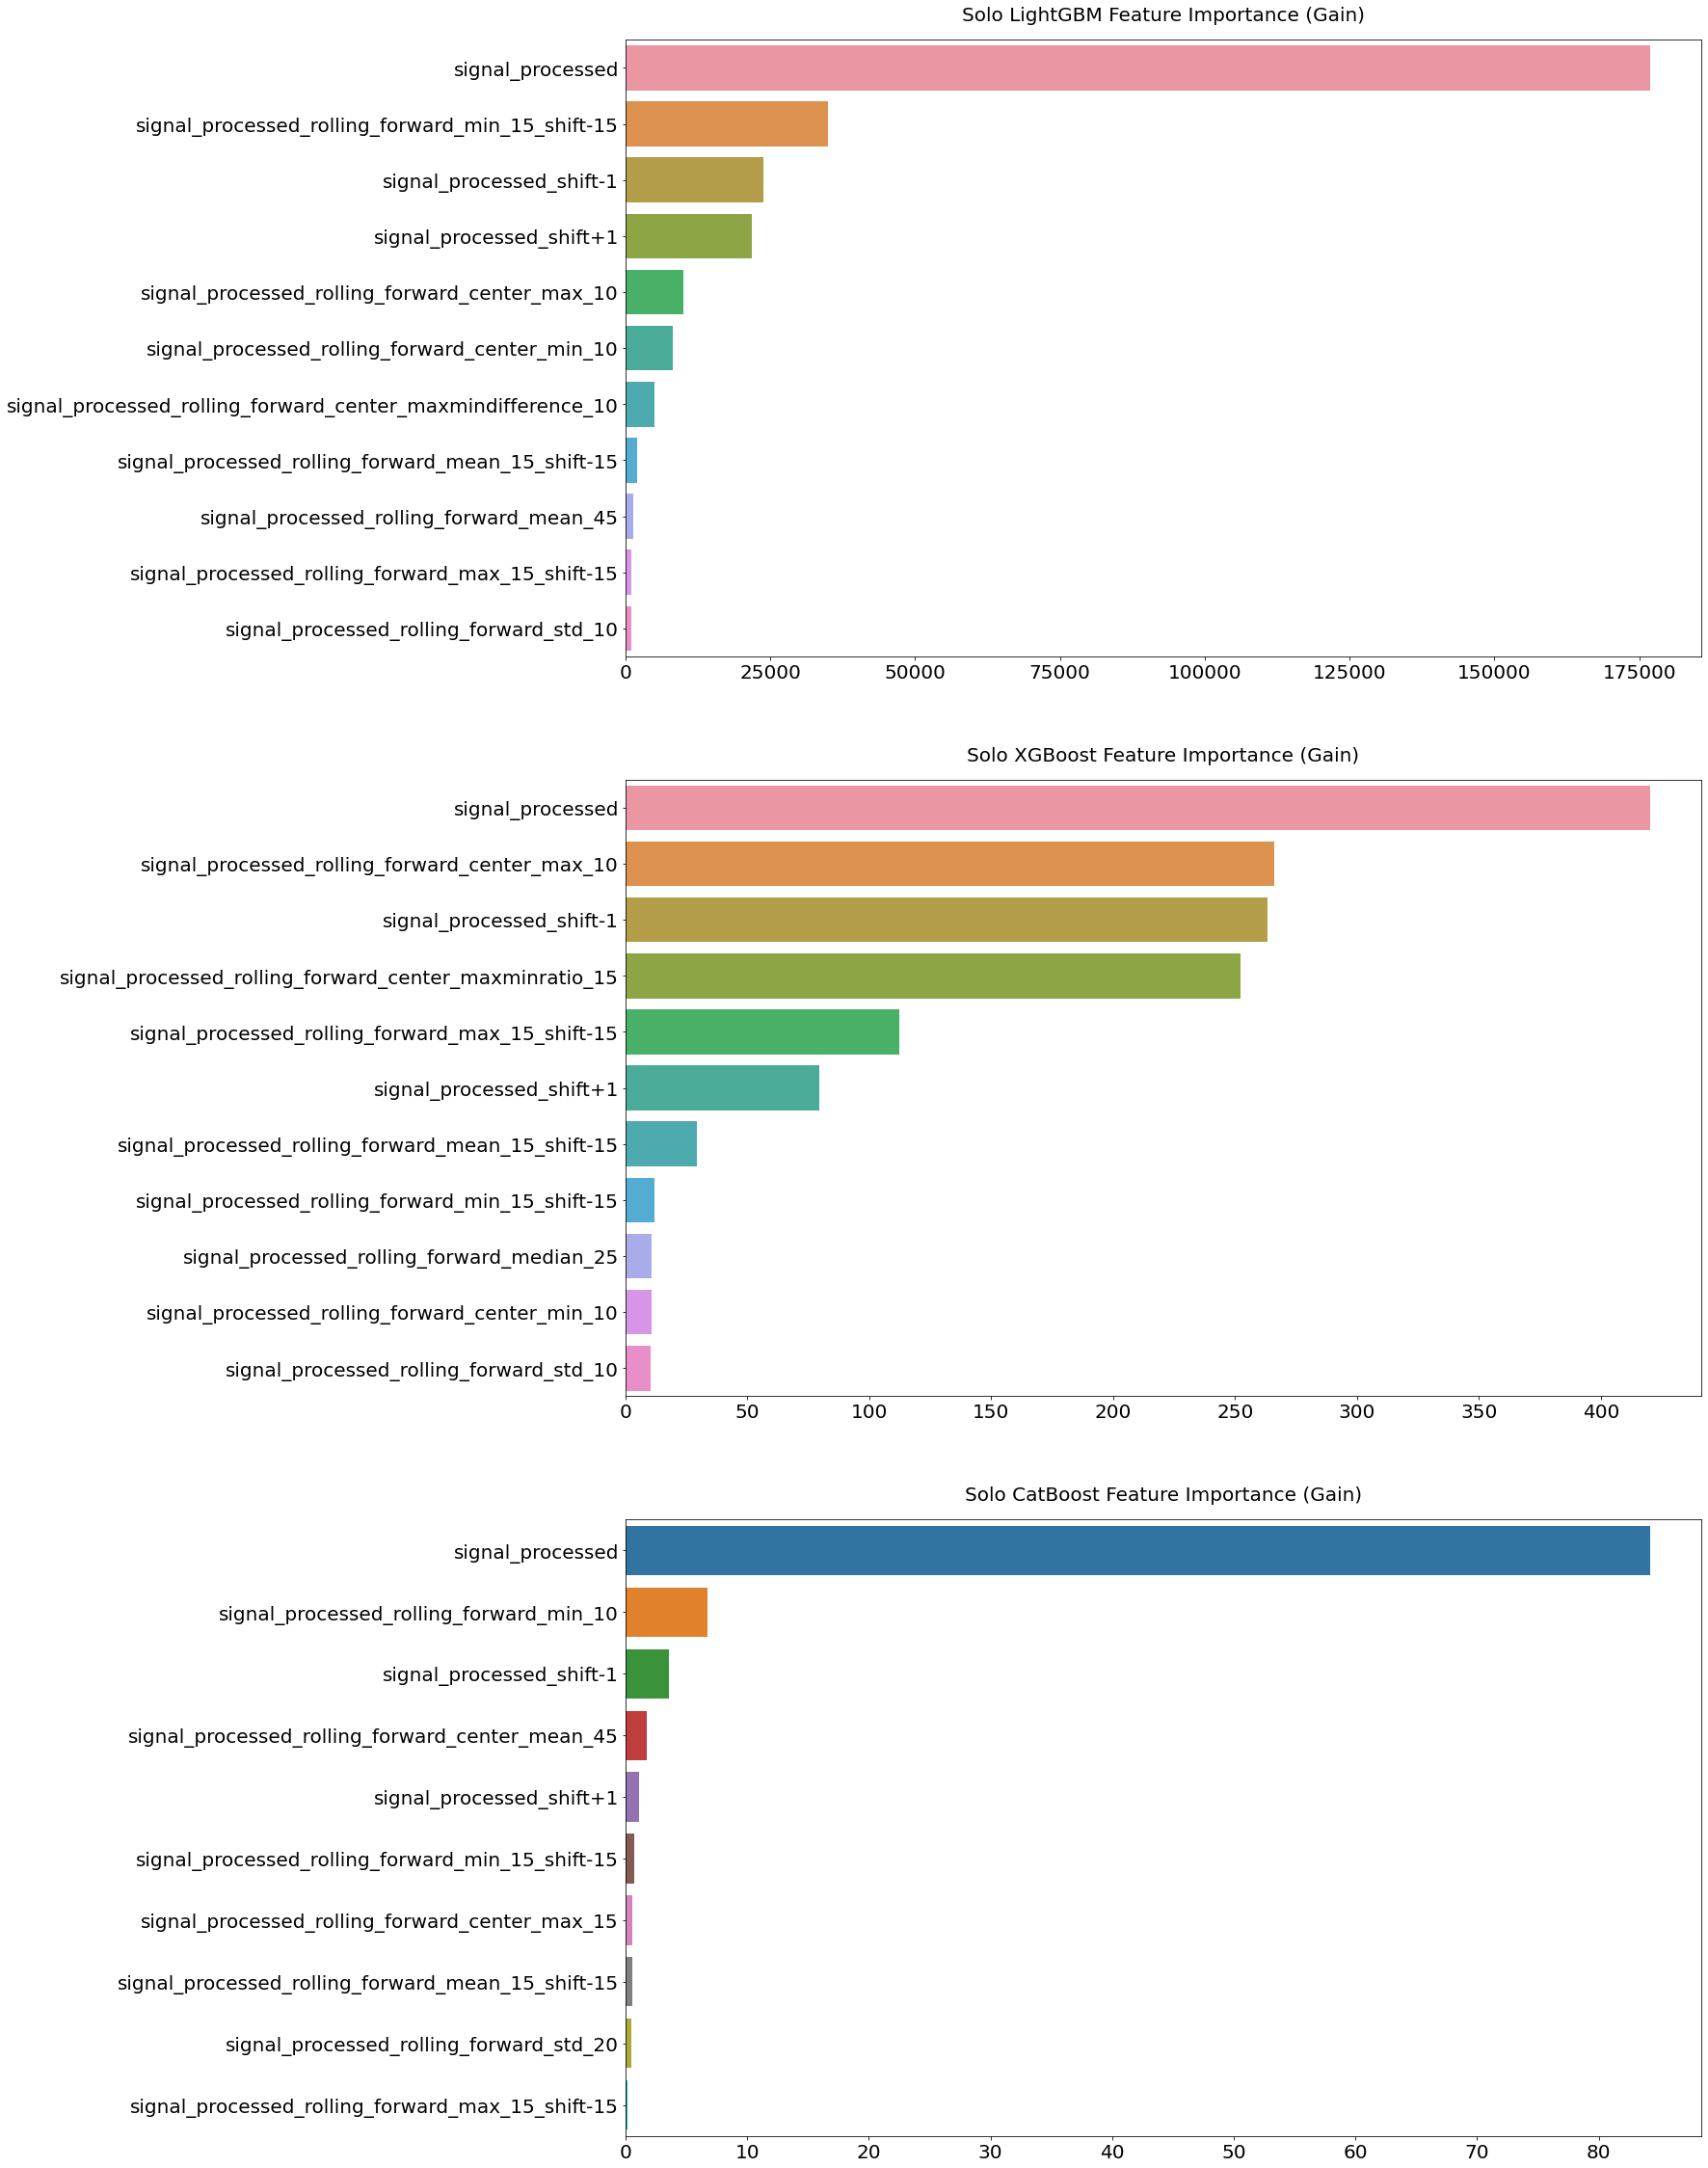

In [6]:
#################### SOLO MODEL 1 ####################

print('#################### SOLO MODEL 1 ####################')
print('------------------------------------------------------')

########## SOLO MODEL 1 LGB ##########

model1_lgb_features = ['signal_processed']
model1_lgb_X_train = df_train[df_train['model'] == 1][model1_lgb_features].copy(deep=True)
model1_lgb_y_train = df_train[df_train['model'] == 1]['open_channels'].copy(deep=True)
model1_lgb_X_test = df_test[df_test['model'] == 1][model1_lgb_features].copy(deep=True)

model1_lgb_sample_weight = model1_lgb_y_train.copy(deep=True).reset_index(drop=True)
model1_lgb_sample_weight.loc[model1_lgb_sample_weight == 0] = 1
model1_lgb_sample_weight.loc[model1_lgb_sample_weight == 1] = 1

for df in [model1_lgb_X_train, model1_lgb_X_test]:
    for shift in range(1, 2):
        df[f'signal_processed_shift+{shift}'] = df['signal_processed'].shift(shift)
        df[f'signal_processed_shift-{shift}'] = df['signal_processed'].shift(-shift)
    df['signal_processed_rolling_forward_mean_45'] = df['signal_processed'].rolling(window=45, min_periods=1, center=False).mean()
    df['signal_processed_rolling_forward_std_10'] = df['signal_processed'].rolling(window=20, min_periods=1, center=False).std()
    df['signal_processed_rolling_forward_center_min_10'] = df['signal_processed'].rolling(window=10, min_periods=1, center=True).min()
    df['signal_processed_rolling_forward_center_max_10'] = df['signal_processed'].rolling(window=10, min_periods=1, center=True).max()
    df['signal_processed_rolling_forward_center_maxmindifference_10'] = df['signal_processed'].rolling(window=5, min_periods=1, center=True).max() - df['signal_processed'].rolling(window=5, min_periods=1, center=True).min()
    df['signal_processed_rolling_forward_min_15_shift-15'] = df['signal_processed'].rolling(window=15, min_periods=1, center=False).min().shift(-15)
    df['signal_processed_rolling_forward_max_15_shift-15'] = df['signal_processed'].rolling(window=15, min_periods=1, center=False).max().shift(-15)
    df['signal_processed_rolling_forward_mean_15_shift-15'] = df['signal_processed'].rolling(window=15, min_periods=1, center=False).mean().shift(-15)

model1_lgb_parameters = {
    'num_iterations': 250,
    'early_stopping_round': 50,
    'num_leaves': 2 ** 5, 
    'learning_rate': 0.085,
    'bagging_fraction': 0.5,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'feature_fraction_bynode': 0.5,
    'min_data_in_leaf': 20,
    'lambda_l1': 0.1,
    'lambda_l2': 0.5,
    'max_depth': -1,
    'objective': 'regression',
    'seed': LGB_SEED,
    'feature_fraction_seed': LGB_SEED,
    'bagging_seed': LGB_SEED,
    'drop_seed': LGB_SEED,
    'data_random_seed': LGB_SEED,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric': 'rmse',
    'n_jobs': -1,
}

########## SOLO MODEL 1 XGB ##########

model1_xgb_features = ['signal_processed']
model1_xgb_X_train = df_train[df_train['model'] == 1][model1_xgb_features].copy(deep=True)
model1_xgb_y_train = df_train[df_train['model'] == 1]['open_channels'].copy(deep=True)
model1_xgb_X_test = df_test[df_test['model'] == 1][model1_xgb_features].copy(deep=True)

model1_xgb_sample_weight = model1_xgb_y_train.copy(deep=True).reset_index(drop=True)
model1_xgb_sample_weight.loc[model1_xgb_sample_weight == 0] = 1
model1_xgb_sample_weight.loc[model1_xgb_sample_weight == 1] = 1

for df in [model1_xgb_X_train, model1_xgb_X_test]:
    for shift in range(1, 2):
        df[f'signal_processed_shift+{shift}'] = df['signal_processed'].shift(shift)
        df[f'signal_processed_shift-{shift}'] = df['signal_processed'].shift(-shift)
    df['signal_processed_rolling_forward_median_25'] = df['signal_processed'].rolling(window=25, min_periods=1, center=False).median()
    df['signal_processed_rolling_forward_std_10'] = df['signal_processed'].rolling(window=25, min_periods=1, center=False).std()
    df['signal_processed_rolling_forward_center_min_10'] = df['signal_processed'].rolling(window=15, min_periods=1, center=True).min()
    df['signal_processed_rolling_forward_center_max_10'] = df['signal_processed'].rolling(window=10, min_periods=1, center=False).max()
    df['signal_processed_rolling_forward_center_maxminratio_15'] = df['signal_processed'].rolling(window=15, min_periods=1, center=True).max() / df['signal_processed'].rolling(window=15, min_periods=1, center=True).min()
    df['signal_processed_rolling_forward_min_15_shift-15'] = df['signal_processed'].rolling(window=15, min_periods=1, center=False).min().shift(-15)
    df['signal_processed_rolling_forward_max_15_shift-15'] = df['signal_processed'].rolling(window=15, min_periods=1, center=False).max().shift(-15)
    df['signal_processed_rolling_forward_mean_15_shift-15'] = df['signal_processed'].rolling(window=15, min_periods=1, center=False).mean().shift(-15)

model1_xgb_parameters = {
    'n_estimators': 2 ** 6, 
    'learning_rate': 0.085,
    'colsample_bytree': 0.8, 
    'colsample_bylevel': 0.8,
    'colsample_bynode': 0.7,
    'sumbsample': 0.8,
    'max_depth': 6,
    'gamma': 0.4,
    'min_child_weight': 1,
    'lambda': 0.6,
    'alpha': 0,
    'objective': 'reg:squarederror',
    'seed': XGB_SEED,
    'boosting_type': 'gbtree',
    'tree_method': 'auto',
    'silent': True,
    'verbose': 1,
    'n_jobs': -1,
}

########## SOLO MODEL 1 CB ##########

model1_cb_features = ['signal_processed']
model1_cb_X_train = df_train[df_train['model'] == 1][model1_cb_features].copy(deep=True)
model1_cb_y_train = df_train[df_train['model'] == 1]['open_channels'].copy(deep=True)
model1_cb_X_test = df_test[df_test['model'] == 1][model1_cb_features].copy(deep=True)

model1_cb_sample_weight = model1_cb_y_train.copy(deep=True).reset_index(drop=True)
model1_cb_sample_weight.loc[model1_cb_sample_weight == 0] = 1
model1_cb_sample_weight.loc[model1_cb_sample_weight == 1] = 1

for df in [model1_cb_X_train, model1_cb_X_test]:
    for shift in range(1, 2):
        df[f'signal_processed_shift+{shift}'] = df['signal_processed'].shift(shift)
        df[f'signal_processed_shift-{shift}'] = df['signal_processed'].shift(-shift)
    df['signal_processed_rolling_forward_center_mean_45'] = df['signal_processed'].rolling(window=50, min_periods=1, center=True).mean()
    df['signal_processed_rolling_forward_std_20'] = df['signal_processed'].rolling(window=20, min_periods=1, center=False).std()
    df['signal_processed_rolling_forward_min_10'] = df['signal_processed'].rolling(window=10, min_periods=1, center=False).min()
    df['signal_processed_rolling_forward_center_max_15'] = df['signal_processed'].rolling(window=15, min_periods=1, center=True).max()
    df['signal_processed_rolling_forward_min_15_shift-15'] = df['signal_processed'].rolling(window=10).min().shift(-10)
    df['signal_processed_rolling_forward_max_15_shift-15'] = df['signal_processed'].rolling(window=10).max().shift(-10)
    df['signal_processed_rolling_forward_mean_15_shift-15'] = df['signal_processed'].rolling(window=10).mean().shift(-10)

model1_cb_parameters = {
    'n_estimators': 200, 
    'learning_rate': 0.055,
    'depth': 6,
    'subsample': 0.6,
    'bagging_temperature': 1,
    'colsample_bylevel': 0.9,
    'l2_leaf_reg': 0.5,
    'metric_period': 50,
    'boost_from_average': True,
    'eval_metric': 'RMSE',
    'loss_function': 'RMSE',    
    'random_seed': CB_SEED,
    'verbose': 1,
}

########## SOLO MODEL 1 TRAINING ##########

solo_model1 = MultiModelGBDTEnsemble(lgb_parameters=model1_lgb_parameters,
                                     xgb_parameters=model1_xgb_parameters, 
                                     cb_parameters=model1_cb_parameters,
                                     model='Blend')

solo_model1.train_and_predict(lgb_X_train=model1_lgb_X_train, lgb_y_train=model1_lgb_y_train, lgb_X_test=model1_lgb_X_test,
                              xgb_X_train=model1_xgb_X_train, xgb_y_train=model1_xgb_y_train, xgb_X_test=model1_xgb_X_test, 
                              cb_X_train=model1_cb_X_train, cb_y_train=model1_cb_y_train, cb_X_test=model1_cb_X_test,                         
                              num_boosting_round=250, early_stopping_rounds=10,
                              lgb_sample_weight=model1_lgb_sample_weight, xgb_sample_weight=model1_xgb_sample_weight, cb_sample_weight=model1_cb_sample_weight,
                              model=1)
solo_model1.plot_importance()

del model1_lgb_X_train, model1_lgb_y_train, model1_lgb_X_test, model1_lgb_sample_weight, model1_lgb_parameters
del model1_xgb_X_train, model1_xgb_y_train, model1_xgb_X_test, model1_xgb_sample_weight, model1_xgb_parameters
del model1_cb_X_train, model1_cb_y_train, model1_cb_X_test, model1_cb_sample_weight, model1_cb_parameters
del solo_model1

### **3.3. Solo Model 2**

#################### SOLO MODEL 2 ####################
------------------------------------------------------

########## Running Solo LightGBM Model 2 ##########

Fold 1
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.114883	valid_1's rmse: 0.106917
[100]	training's rmse: 0.0930961	valid_1's rmse: 0.0877176
[150]	training's rmse: 0.0901239	valid_1's rmse: 0.0876505
Early stopping, best iteration is:
[131]	training's rmse: 0.0911219	valid_1's rmse: 0.0876116

Solo LGB Fold 1 Macro F1-Score 0.9873980533532092


Fold 2
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.100148	valid_1's rmse: 0.120541
[100]	training's rmse: 0.0754983	valid_1's rmse: 0.105362
[150]	training's rmse: 0.0724693	valid_1's rmse: 0.105341
Early stopping, best iteration is:
[116]	training's rmse: 0.074313	valid_1's rmse: 0.105295

Solo LGB Fold 2 Macro F1-Score 0.9824968690311027

--------------------
Solo LGB Mean Macro F1-Score 0.984947 [STD

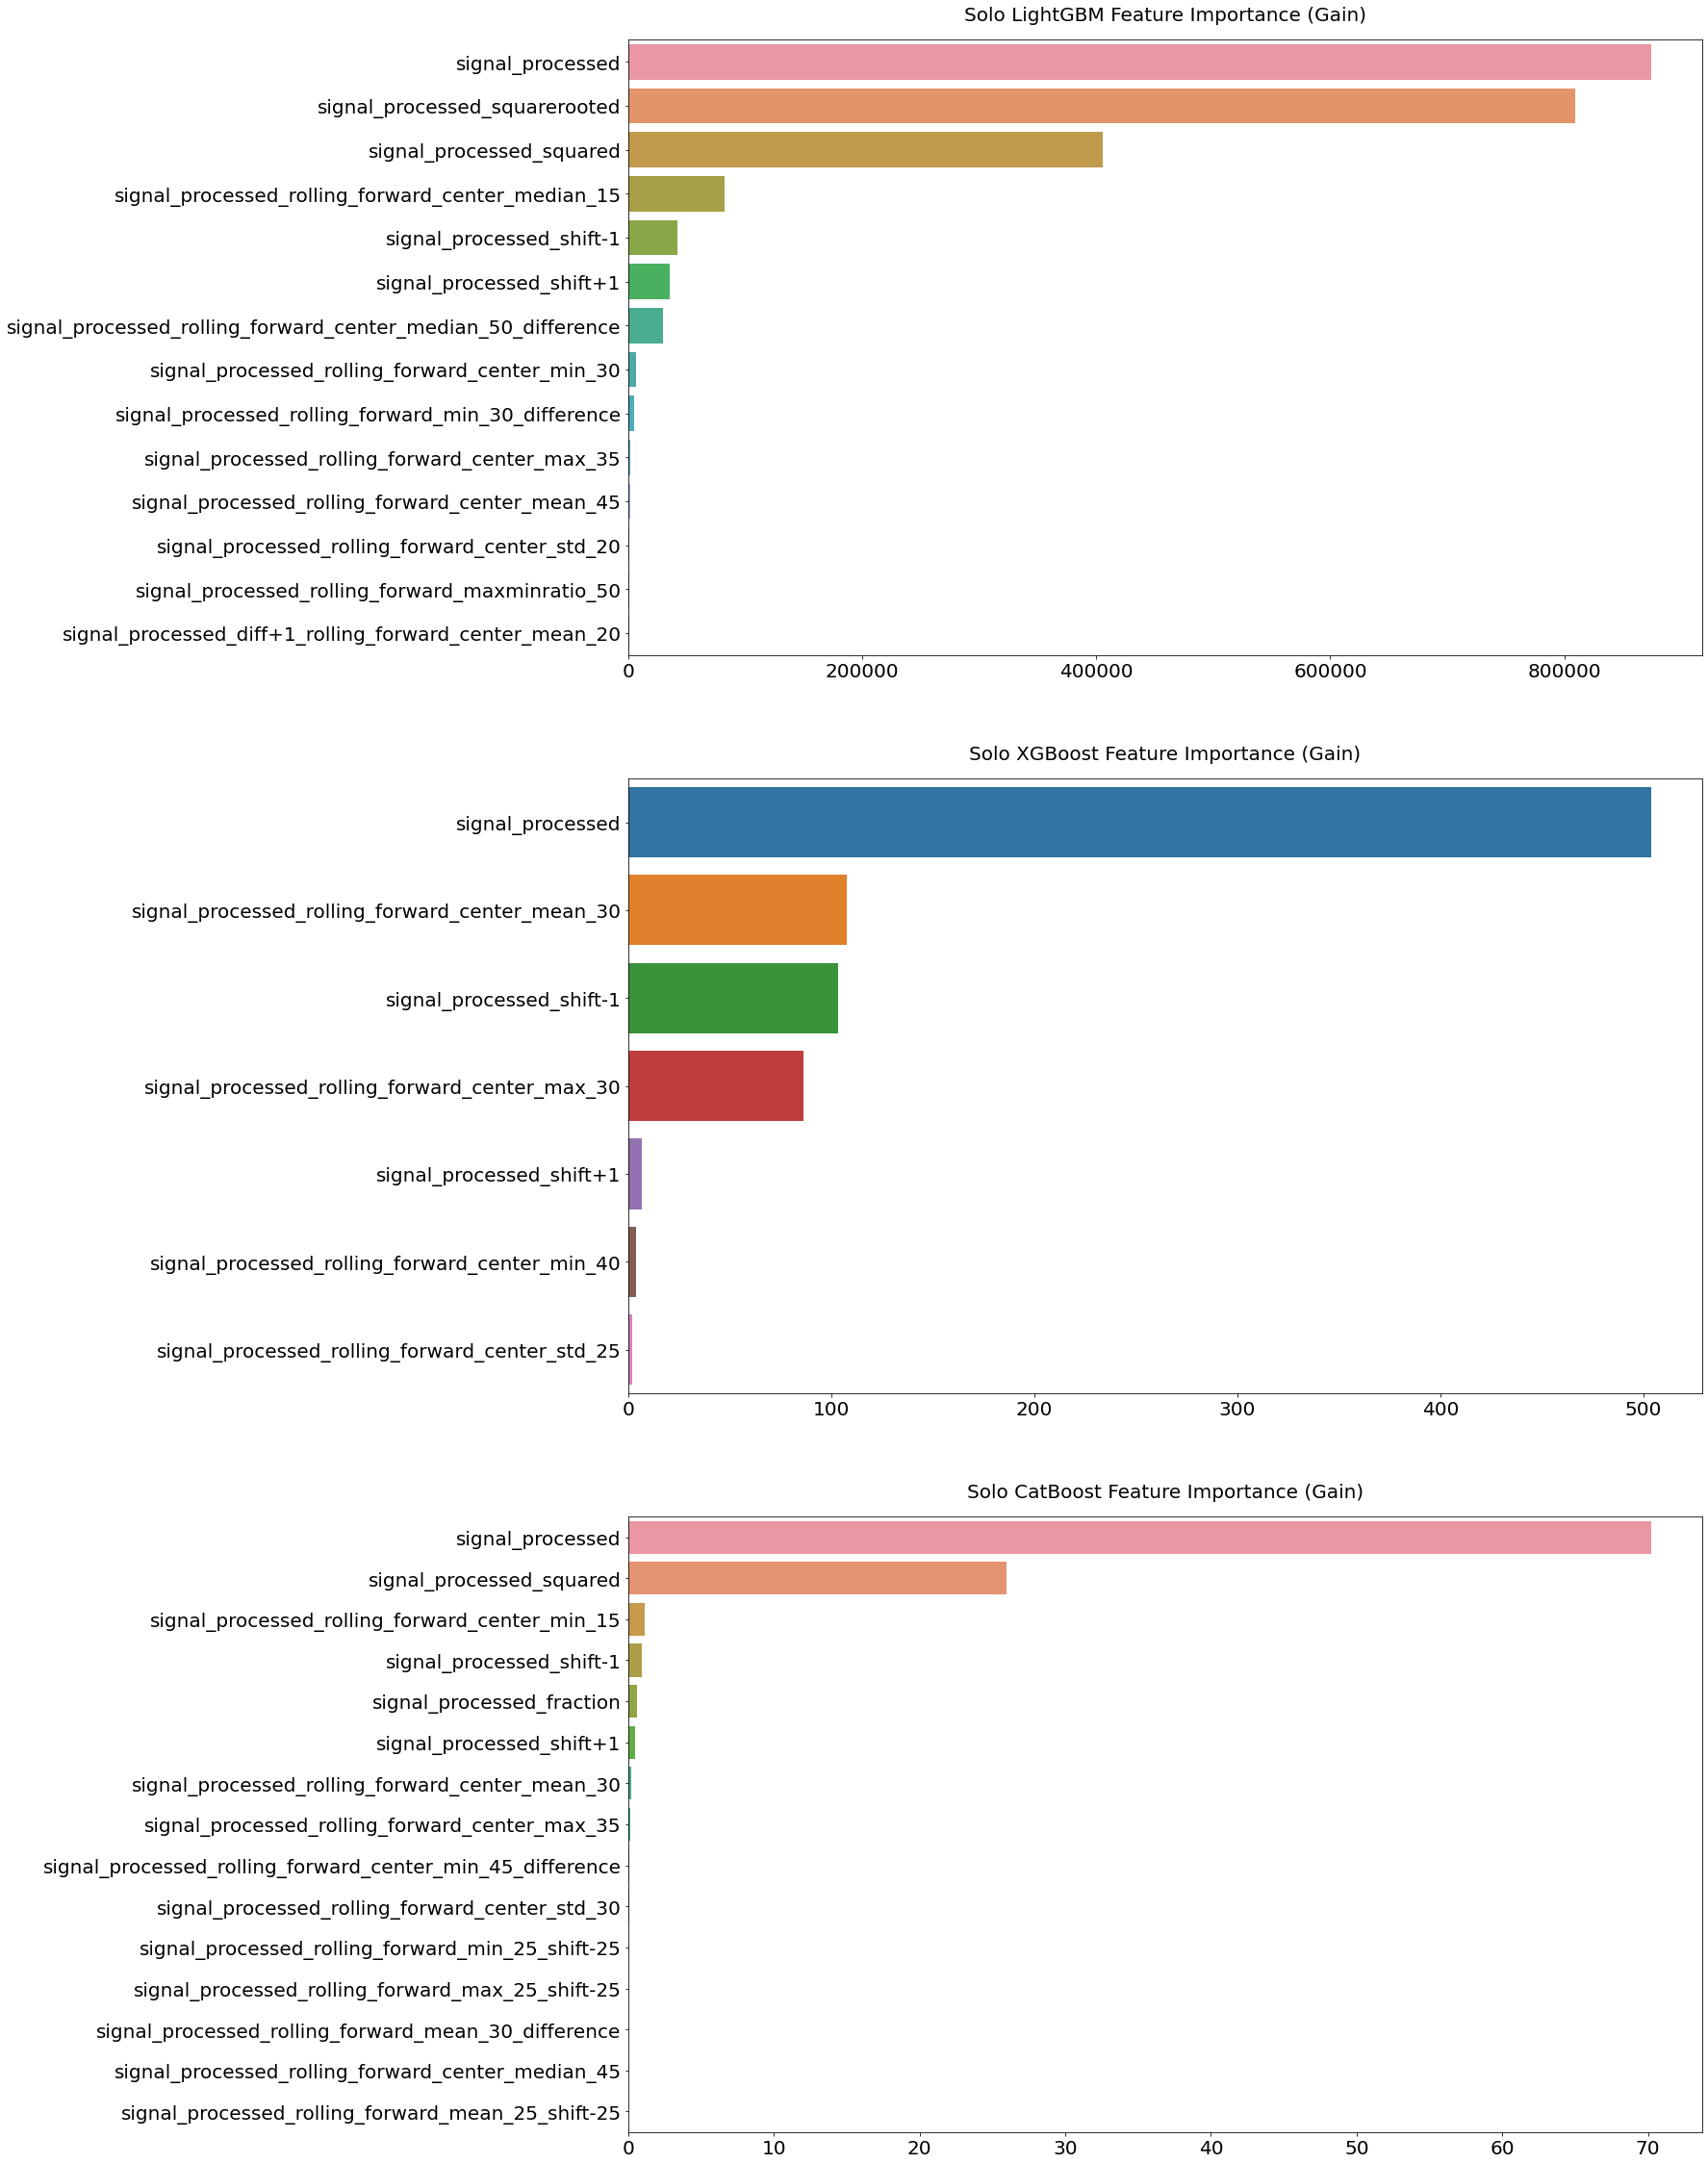

In [7]:
#################### SOLO MODEL 2 ####################

print('#################### SOLO MODEL 2 ####################')
print('------------------------------------------------------')

########## SOLO MODEL 2 LGB ##########

model2_lgb_features = ['signal_processed']
model2_lgb_X_train = df_train[(df_train['model'] == 2) & (df_train['is_filtered'] == 0)][model2_lgb_features].copy(deep=True)
model2_lgb_y_train = df_train[(df_train['model'] == 2) & (df_train['is_filtered'] == 0)]['open_channels'].copy(deep=True)
model2_lgb_X_test = df_test[df_test['model'] == 2][model2_lgb_features].copy(deep=True)

model2_lgb_sample_weight = model2_lgb_y_train.copy(deep=True).reset_index(drop=True)
model2_lgb_sample_weight.loc[model2_lgb_sample_weight == 0] = 1
model2_lgb_sample_weight.loc[model2_lgb_sample_weight == 1] = 1
model2_lgb_sample_weight.loc[model2_lgb_sample_weight == 2] = 1
model2_lgb_sample_weight.loc[model2_lgb_sample_weight == 3] = 1

for df in [model2_lgb_X_train, model2_lgb_X_test]:
    for shift in range(1, 2):
        df[f'signal_processed_shift+{shift}'] = df['signal_processed'].shift(shift).fillna(0)
        df[f'signal_processed_shift-{shift}'] = df['signal_processed'].shift(-shift).fillna(0)
    df['signal_processed_squared'] = df['signal_processed'] ** 2
    df['signal_processed_squarerooted'] = df['signal_processed'] ** (1 / 2)
    df['signal_processed_rolling_forward_center_mean_45'] = df['signal_processed'].rolling(window=45, min_periods=1, center=True).mean()
    df['signal_processed_rolling_forward_center_median_15'] = df['signal_processed'].rolling(window=15, min_periods=1, center=True).median()
    df['signal_processed_rolling_forward_center_std_20'] = df['signal_processed'].rolling(window=30, min_periods=1, center=True).std()
    df['signal_processed_rolling_forward_center_min_30'] = df['signal_processed'].rolling(window=30, min_periods=1, center=True).min()
    df['signal_processed_rolling_forward_center_max_35'] = df['signal_processed'].rolling(window=35, min_periods=1, center=True).max()
    df['signal_processed_rolling_forward_center_median_50_difference'] = df['signal_processed'] - df['signal_processed'].rolling(window=50, min_periods=1, center=True).median()
    df['signal_processed_rolling_forward_min_30_difference'] = df['signal_processed'] - df['signal_processed'].rolling(window=30, min_periods=1, center=False).min()
    df['signal_processed_rolling_forward_maxminratio_50'] = df['signal_processed'].rolling(window=50, min_periods=1, center=False).max() / df['signal_processed'].rolling(window=50, min_periods=1, center=False).min()
    df['signal_processed_diff+1_rolling_forward_center_mean_20'] = df['signal_processed'].diff(1).fillna(0).rolling(window=20, min_periods=1, center=True).mean()

model2_lgb_parameters = {
    'num_iterations': 250,
    'early_stopping_round': 50,
    'num_leaves': 2 ** 7, 
    'learning_rate': 0.05,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.9,
    'feature_fraction_bynode': 0.5,
    'min_data_in_leaf': 20,
    'lambda_l1': 0,
    'lambda_l2': 0.05,
    'max_depth': -1,
    'objective': 'regression',
    'seed': LGB_SEED,
    'feature_fraction_seed': LGB_SEED,
    'bagging_seed': LGB_SEED,
    'drop_seed': LGB_SEED,
    'data_random_seed': LGB_SEED,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric': 'rmse',
    'n_jobs': -1,
}

########## SOLO MODEL 2 XGB ##########

model2_xgb_features = ['signal_processed']
model2_xgb_X_train = df_train[(df_train['model'] == 2) & (df_train['is_filtered'] == 0)][model2_xgb_features].copy(deep=True)
model2_xgb_y_train = df_train[(df_train['model'] == 2) & (df_train['is_filtered'] == 0)]['open_channels'].copy(deep=True)
model2_xgb_X_test = df_test[(df_test['model'] == 2) | (df_test['model'] == 1.5)][model2_xgb_features].copy(deep=True)

model2_xgb_sample_weight = model2_xgb_y_train.copy(deep=True).reset_index(drop=True)
model2_xgb_sample_weight.loc[model2_xgb_sample_weight == 0] = 1
model2_xgb_sample_weight.loc[model2_xgb_sample_weight == 1] = 1
model2_xgb_sample_weight.loc[model2_xgb_sample_weight == 2] = 1
model2_xgb_sample_weight.loc[model2_xgb_sample_weight == 3] = 1

for df in [model2_xgb_X_train, model2_xgb_X_test]:
    for shift in range(1, 2):
        df[f'signal_processed_shift+{shift}'] = df['signal_processed'].shift(shift).fillna(0)
        df[f'signal_processed_shift-{shift}'] = df['signal_processed'].shift(-shift).fillna(0)
    df['signal_processed_rolling_forward_center_mean_30'] = df['signal_processed'].rolling(window=30, min_periods=1, center=True).mean()
    df['signal_processed_rolling_forward_center_std_25'] = df['signal_processed'].rolling(window=25, min_periods=1, center=True).std()
    df['signal_processed_rolling_forward_center_min_40'] = df['signal_processed'].rolling(window=40, min_periods=1, center=True).min()
    df['signal_processed_rolling_forward_center_max_30'] = df['signal_processed'].rolling(window=30, min_periods=1, center=True).max()
    
model2_xgb_parameters = {
    'n_estimators': 2 ** 7, 
    'learning_rate': 0.09,
    'colsample_bytree': 0.9, 
    'colsample_bylevel': 0.9,
    'colsample_bynode': 0.8,
    'sumbsample': 0.6,
    'max_depth': 6,
    'gamma': 0.01,
    'min_child_weight': 1,
    'lambda': 1,
    'alpha': 0.005,
    'objective': 'reg:squarederror',
    'seed': XGB_SEED,
    'boosting_type': 'gbtree',
    'tree_method': 'auto',
    'silent': True,
    'verbose': 1,
    'n_jobs': -1,
}

########## SOLO MODEL 2 CB ##########

model2_cb_features = ['signal_processed']
model2_cb_X_train = df_train[(df_train['model'] == 2) & (df_train['is_filtered'] == 0)][model2_cb_features].copy(deep=True)
model2_cb_y_train = df_train[(df_train['model'] == 2) & (df_train['is_filtered'] == 0)]['open_channels'].copy(deep=True)
model2_cb_X_test = df_test[(df_test['model'] == 2) | (df_test['model'] == 1.5)][model2_cb_features].copy(deep=True)

model2_cb_sample_weight = model2_cb_y_train.copy(deep=True).reset_index(drop=True)
model2_cb_sample_weight.loc[model2_cb_sample_weight == 0] = 1
model2_cb_sample_weight.loc[model2_cb_sample_weight == 1] = 1
model2_cb_sample_weight.loc[model2_cb_sample_weight == 2] = 1
model2_cb_sample_weight.loc[model2_cb_sample_weight == 3] = 1

for df in [model2_cb_X_train, model2_cb_X_test]:
    for shift in range(1, 2):
        df[f'signal_processed_shift+{shift}'] = df['signal_processed'].shift(shift).fillna(0)
        df[f'signal_processed_shift-{shift}'] = df['signal_processed'].shift(-shift).fillna(0)
    df['signal_processed_rolling_forward_center_mean_30'] = df['signal_processed'].rolling(window=30, min_periods=1, center=True).mean()
    df['signal_processed_rolling_forward_center_std_30'] = df['signal_processed'].rolling(window=30, min_periods=1, center=True).std()
    df['signal_processed_rolling_forward_center_min_15'] = df['signal_processed'].rolling(window=15, min_periods=1, center=True).min()
    df['signal_processed_rolling_forward_center_max_35'] = df['signal_processed'].rolling(window=35, min_periods=1, center=True).max()
    df['signal_processed_rolling_forward_mean_30_difference'] = df['signal_processed'] - df['signal_processed'].rolling(window=30, min_periods=1, center=False).mean()
    df['signal_processed_rolling_forward_center_min_45_difference'] = df['signal_processed'] - df['signal_processed'].rolling(window=45, min_periods=1, center=True).min()
    df['signal_processed_rolling_forward_center_median_45'] = df['signal_processed'].rolling(window=45, min_periods=1, center=True).median()
    df['signal_processed_rolling_forward_min_25_shift-25'] = df['signal_processed'].rolling(window=25, min_periods=1, center=False).min().shift(-25)
    df['signal_processed_rolling_forward_max_25_shift-25'] = df['signal_processed'].rolling(window=25, min_periods=1, center=False).max().shift(-25)
    df['signal_processed_rolling_forward_mean_25_shift-25'] = df['signal_processed'].rolling(window=25, min_periods=1, center=False).mean().shift(-25)
    df['signal_processed_fraction'] = np.abs(df['signal_processed'] - df['signal_processed'].astype(int))
    df['signal_processed_squared'] = df['signal_processed'] ** 2
    
model2_cb_parameters = {
    'n_estimators': 300, 
    'learning_rate': 0.08,
    'depth': 6,
    'subsample': 0.6,
    'bagging_temperature': 1,
    'colsample_bylevel': 0.8,
    'l2_leaf_reg': 0.06,
    'metric_period': 50,
    'boost_from_average': True,
    'eval_metric': 'RMSE',
    'loss_function': 'RMSE',    
    'random_seed': CB_SEED,
    'verbose': 1,
}

########## SOLO MODEL 2 TRAINING ##########

solo_model2 = MultiModelGBDTEnsemble(lgb_parameters=model2_lgb_parameters,
                                     xgb_parameters=model2_xgb_parameters, 
                                     cb_parameters=model2_cb_parameters,
                                     model='Blend')

solo_model2.train_and_predict(lgb_X_train=model2_lgb_X_train, lgb_y_train=model2_lgb_y_train, lgb_X_test=model2_lgb_X_test,
                              xgb_X_train=model2_xgb_X_train, xgb_y_train=model2_xgb_y_train, xgb_X_test=model2_xgb_X_test, 
                              cb_X_train=model2_cb_X_train, cb_y_train=model2_cb_y_train, cb_X_test=model2_cb_X_test,
                              num_boosting_round=300, early_stopping_rounds=25, 
                              lgb_sample_weight=model2_lgb_sample_weight, xgb_sample_weight=model2_xgb_sample_weight, cb_sample_weight=model2_cb_sample_weight, 
                              model=2)
solo_model2.plot_importance()

del model2_lgb_X_train, model2_lgb_y_train, model2_lgb_X_test, model2_lgb_sample_weight, model2_lgb_parameters
del model2_xgb_X_train, model2_xgb_y_train, model2_xgb_X_test, model2_xgb_sample_weight, model2_xgb_parameters
del model2_cb_X_train, model2_cb_y_train, model2_cb_X_test, model2_cb_sample_weight, model2_cb_parameters
del solo_model2

### **3.4. Solo Model 3**

#################### SOLO MODEL 3 ####################
------------------------------------------------------

########## Running Solo LightGBM Model 3 ##########

Fold 1
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.125872	valid_1's rmse: 0.134558
[100]	training's rmse: 0.113604	valid_1's rmse: 0.126413
[150]	training's rmse: 0.111242	valid_1's rmse: 0.126402
Early stopping, best iteration is:
[125]	training's rmse: 0.112279	valid_1's rmse: 0.126391

Solo LGB Fold 1 Macro F1-Score 0.972633983709633


Fold 2
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.129083	valid_1's rmse: 0.130782
[100]	training's rmse: 0.117122	valid_1's rmse: 0.122706
[150]	training's rmse: 0.114874	valid_1's rmse: 0.122824
Early stopping, best iteration is:
[101]	training's rmse: 0.117077	valid_1's rmse: 0.122705

Solo LGB Fold 2 Macro F1-Score 0.9753354941335824

--------------------
Solo LGB Mean Macro F1-Score 0.973985 [STD:0.001350

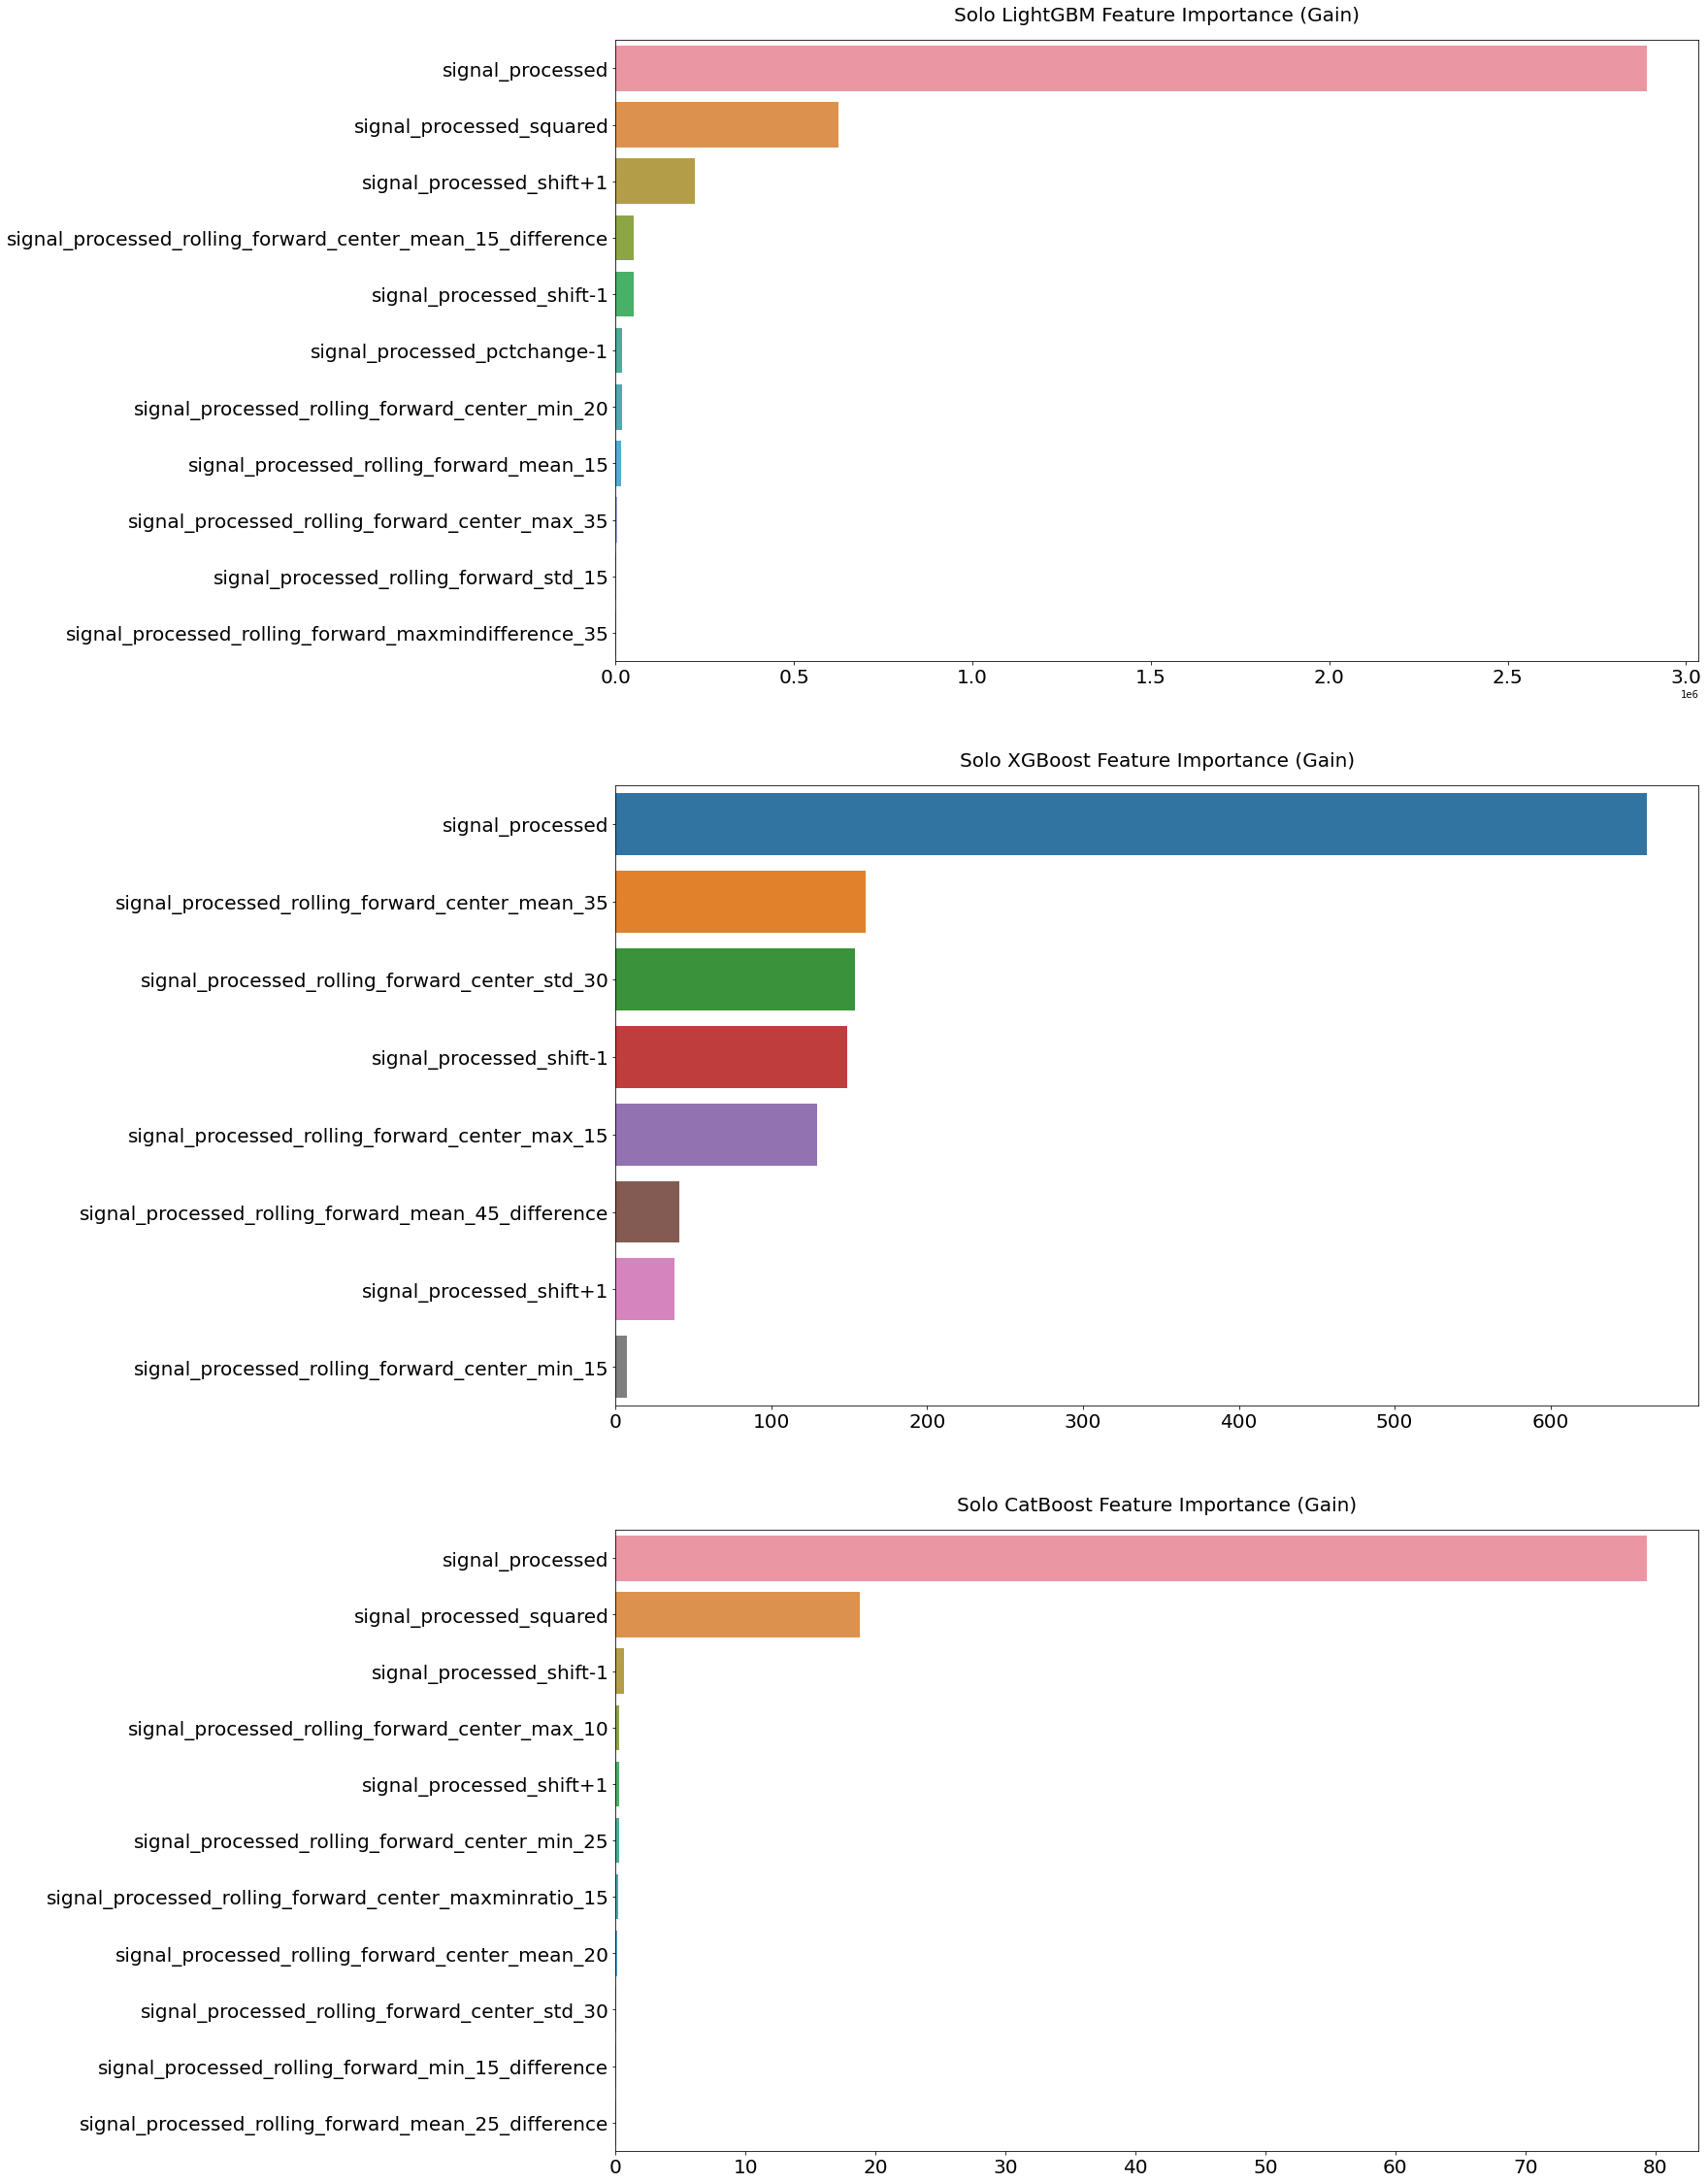

In [8]:
#################### SOLO MODEL 3 ####################

print('#################### SOLO MODEL 3 ####################')
print('------------------------------------------------------')

########## SOLO MODEL 3 LGB ##########

model3_lgb_features = ['signal_processed']
model3_lgb_X_train = df_train[df_train['model'] == 3][model3_lgb_features].copy(deep=True)
model3_lgb_y_train = df_train[df_train['model'] == 3]['open_channels'].copy(deep=True)
model3_lgb_X_test = df_test[df_test['model'] == 3][model3_lgb_features].copy(deep=True)

model3_lgb_sample_weight = model3_lgb_y_train.copy(deep=True).reset_index(drop=True)
model3_lgb_sample_weight.loc[model3_lgb_sample_weight == 0] = 1
model3_lgb_sample_weight.loc[model3_lgb_sample_weight == 1] = 1
model3_lgb_sample_weight.loc[model3_lgb_sample_weight == 2] = 1
model3_lgb_sample_weight.loc[model3_lgb_sample_weight == 3] = 1
model3_lgb_sample_weight.loc[model3_lgb_sample_weight == 4] = 1
model3_lgb_sample_weight.loc[model3_lgb_sample_weight == 5] = 1

for df in [model3_lgb_X_train, model3_lgb_X_test]:
    for shift in range(1, 2):
        df[f'signal_processed_shift+{shift}'] = df['signal_processed'].shift(shift).fillna(0)
        df[f'signal_processed_shift-{shift}'] = df['signal_processed'].shift(-shift).fillna(0)
    df['signal_processed_squared'] = df['signal_processed'] ** 2
    df['signal_processed_rolling_forward_mean_15'] = df['signal_processed'].rolling(window=15, min_periods=1, center=False).mean()
    df['signal_processed_rolling_forward_std_15'] = df['signal_processed'].rolling(window=15, min_periods=1, center=False).std()
    df['signal_processed_rolling_forward_center_min_20'] = df['signal_processed'].rolling(window=20, min_periods=1, center=True).min()
    df['signal_processed_rolling_forward_center_max_35'] = df['signal_processed'].rolling(window=35, min_periods=1, center=True).max()
    df['signal_processed_rolling_forward_maxmindifference_35'] = df['signal_processed'].rolling(window=25, min_periods=1, center=False).max() - df['signal_processed'].rolling(window=25, min_periods=1, center=False).min()
    df['signal_processed_rolling_forward_center_mean_15_difference'] = df['signal_processed'] - df['signal_processed'].rolling(window=15, min_periods=1, center=False).mean()
    df['signal_processed_pctchange-1'] = df['signal_processed'].pct_change(-1)
    
model3_lgb_parameters = {
    'num_iterations': 200,
    'early_stopping_round': 50,
    'num_leaves': 2 ** 7, 
    'learning_rate': 0.06,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.9,
    'feature_fraction_bynode': 0.8,
    'min_data_in_leaf': 20,
    'lambda_l1': 0.5,
    'lambda_l2': 0,
    'max_depth': -1,   
    'objective': 'regression',
    'seed': LGB_SEED,
    'feature_fraction_seed': LGB_SEED,
    'bagging_seed': LGB_SEED,
    'drop_seed': LGB_SEED,
    'data_random_seed': LGB_SEED,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric': 'rmse',
    'n_jobs': -1,
}

########## SOLO MODEL 3 XGB ##########

model3_xgb_features = ['signal_processed']
model3_xgb_X_train = df_train[df_train['model'] == 3][model3_xgb_features].copy(deep=True)
model3_xgb_y_train = df_train[df_train['model'] == 3]['open_channels'].copy(deep=True)
model3_xgb_X_test = df_test[df_test['model'] == 3][model3_xgb_features].copy(deep=True)

model3_xgb_sample_weight = model3_xgb_y_train.copy(deep=True).reset_index(drop=True)
model3_xgb_sample_weight.loc[model3_xgb_sample_weight == 0] = 1
model3_xgb_sample_weight.loc[model3_xgb_sample_weight == 1] = 1
model3_xgb_sample_weight.loc[model3_xgb_sample_weight == 2] = 1
model3_xgb_sample_weight.loc[model3_xgb_sample_weight == 3] = 1
model3_xgb_sample_weight.loc[model3_xgb_sample_weight == 4] = 1
model3_xgb_sample_weight.loc[model3_xgb_sample_weight == 5] = 1

for df in [model3_xgb_X_train, model3_xgb_X_test]:
    for shift in range(1, 2):
        df[f'signal_processed_shift+{shift}'] = df['signal_processed'].shift(shift).fillna(0)
        df[f'signal_processed_shift-{shift}'] = df['signal_processed'].shift(-shift).fillna(0)
    df['signal_processed_rolling_forward_center_mean_35'] = df['signal_processed'].rolling(window=35, min_periods=1, center=True).mean()
    df['signal_processed_rolling_forward_center_std_30'] = df['signal_processed'].rolling(window=30, min_periods=1, center=True).std()
    df['signal_processed_rolling_forward_center_min_15'] = df['signal_processed'].rolling(window=15, min_periods=1, center=True).min()
    df['signal_processed_rolling_forward_center_max_15'] = df['signal_processed'].rolling(window=15, min_periods=1, center=True).max()
    df['signal_processed_rolling_forward_mean_45_difference'] = df['signal_processed'] - df['signal_processed'].rolling(window=45, min_periods=1, center=False).mean()
    
model3_xgb_parameters = {
    'n_estimators': 2 ** 7, 
    'learning_rate': 0.09,
    'colsample_bytree': 0.9, 
    'colsample_bylevel': 0.9,
    'colsample_bynode': 0.9,
    'sumbsample': 0.6,
    'max_depth': 6,
    'gamma': 0,
    'min_child_weight': 1,
    'lambda': 1,
    'alpha': 0,
    'objective': 'reg:squarederror',
    'seed': XGB_SEED,
    'boosting_type': 'gbtree',
    'tree_method': 'auto',
    'silent': True,
    'verbose': 1,
    'n_jobs': -1,
}

########## SOLO MODEL 3 CB ##########

model3_cb_features = ['signal_processed']
model3_cb_X_train = df_train[df_train['model'] == 3][model3_cb_features].copy(deep=True)
model3_cb_y_train = df_train[df_train['model'] == 3]['open_channels'].copy(deep=True)
model3_cb_X_test = df_test[df_test['model'] == 3][model3_cb_features].copy(deep=True)

model3_cb_sample_weight = model3_cb_y_train.copy(deep=True).reset_index(drop=True)
model3_cb_sample_weight.loc[model3_cb_sample_weight == 0] = 1
model3_cb_sample_weight.loc[model3_cb_sample_weight == 1] = 1
model3_cb_sample_weight.loc[model3_cb_sample_weight == 2] = 1
model3_cb_sample_weight.loc[model3_cb_sample_weight == 3] = 1
model3_cb_sample_weight.loc[model3_cb_sample_weight == 4] = 1
model3_cb_sample_weight.loc[model3_cb_sample_weight == 5] = 1

for df in [model3_cb_X_train, model3_cb_X_test]:
    for shift in range(1, 2):
        df[f'signal_processed_shift+{shift}'] = df['signal_processed'].shift(shift).fillna(0)
        df[f'signal_processed_shift-{shift}'] = df['signal_processed'].shift(-shift).fillna(0)
    df['signal_processed_squared'] = df['signal_processed'] ** 2
    df['signal_processed_rolling_forward_center_mean_20'] = df['signal_processed'].rolling(window=20, min_periods=1, center=True).mean()
    df['signal_processed_rolling_forward_center_std_30'] = df['signal_processed'].rolling(window=30, min_periods=1, center=True).std()
    df['signal_processed_rolling_forward_center_min_25'] = df['signal_processed'].rolling(window=25, min_periods=1, center=True).min()
    df['signal_processed_rolling_forward_center_max_10'] = df['signal_processed'].rolling(window=10, min_periods=1, center=True).max()
    df['signal_processed_rolling_forward_mean_25_difference'] = df['signal_processed'] - df['signal_processed'].rolling(window=25, min_periods=1, center=False).mean()
    df['signal_processed_rolling_forward_min_15_difference'] = df['signal_processed'] - df['signal_processed'].rolling(window=15, min_periods=1, center=False).min()
    df['signal_processed_rolling_forward_center_maxminratio_15'] = df['signal_processed'].rolling(window=15, min_periods=1, center=True).max() / df['signal_processed'].rolling(window=15, min_periods=1, center=True).min()
    
model3_cb_parameters = {
    'n_estimators': 550, 
    'learning_rate': 0.07,
    'depth': 6,
    'subsample': 0.7,
    'bagging_temperature': 1,
    'colsample_bylevel': 0.9,    
    'l2_leaf_reg': 0.05,
    'metric_period': 50,
    'boost_from_average': True,
    'eval_metric': 'RMSE',
    'loss_function': 'RMSE',    
    'random_seed': CB_SEED,
    'verbose': 1,
}

########## SOLO MODEL 3 TRAINING ##########

solo_model3 = MultiModelGBDTEnsemble(lgb_parameters=model3_lgb_parameters,
                                     xgb_parameters=model3_xgb_parameters, 
                                     cb_parameters=model3_cb_parameters,
                                     model='Blend')

solo_model3.train_and_predict(lgb_X_train=model3_lgb_X_train, lgb_y_train=model3_lgb_y_train, lgb_X_test=model3_lgb_X_test,
                              xgb_X_train=model3_xgb_X_train, xgb_y_train=model3_xgb_y_train, xgb_X_test=model3_xgb_X_test, 
                              cb_X_train=model3_cb_X_train, cb_y_train=model3_cb_y_train, cb_X_test=model3_cb_X_test,
                              num_boosting_round=400, early_stopping_rounds=20, 
                              lgb_sample_weight=model3_lgb_sample_weight, xgb_sample_weight=model3_xgb_sample_weight, cb_sample_weight=model3_cb_sample_weight,
                              model=3)
solo_model3.plot_importance()

del model3_lgb_X_train, model3_lgb_y_train, model3_lgb_X_test, model3_lgb_sample_weight, model3_lgb_parameters
del model3_xgb_X_train, model3_xgb_y_train, model3_xgb_X_test, model3_xgb_sample_weight, model3_xgb_parameters
del model3_cb_X_train, model3_cb_y_train, model3_cb_X_test, model3_cb_sample_weight, model3_cb_parameters
del solo_model3

### **3.5. Solo Model 4**

#################### SOLO MODEL 4 ####################
------------------------------------------------------

########## Running Solo LightGBM Model 4 ##########

Fold 1
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.275636	valid_1's rmse: 0.280003
[100]	training's rmse: 0.271936	valid_1's rmse: 0.279223
Early stopping, best iteration is:
[75]	training's rmse: 0.273193	valid_1's rmse: 0.279188

Solo LGB Fold 1 Macro F1-Score 0.7956512163396592


Fold 2
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.276224	valid_1's rmse: 0.27947
[100]	training's rmse: 0.272449	valid_1's rmse: 0.278573
Early stopping, best iteration is:
[83]	training's rmse: 0.273283	valid_1's rmse: 0.278531

Solo LGB Fold 2 Macro F1-Score 0.85994286088784

--------------------
Solo LGB Mean Macro F1-Score 0.827797 [STD:0.0321458]
Solo LGB Model 4 OOF (Rounded) Macro F1-Score 0.788374
--------------------

########## Running Solo XGBoost Model 

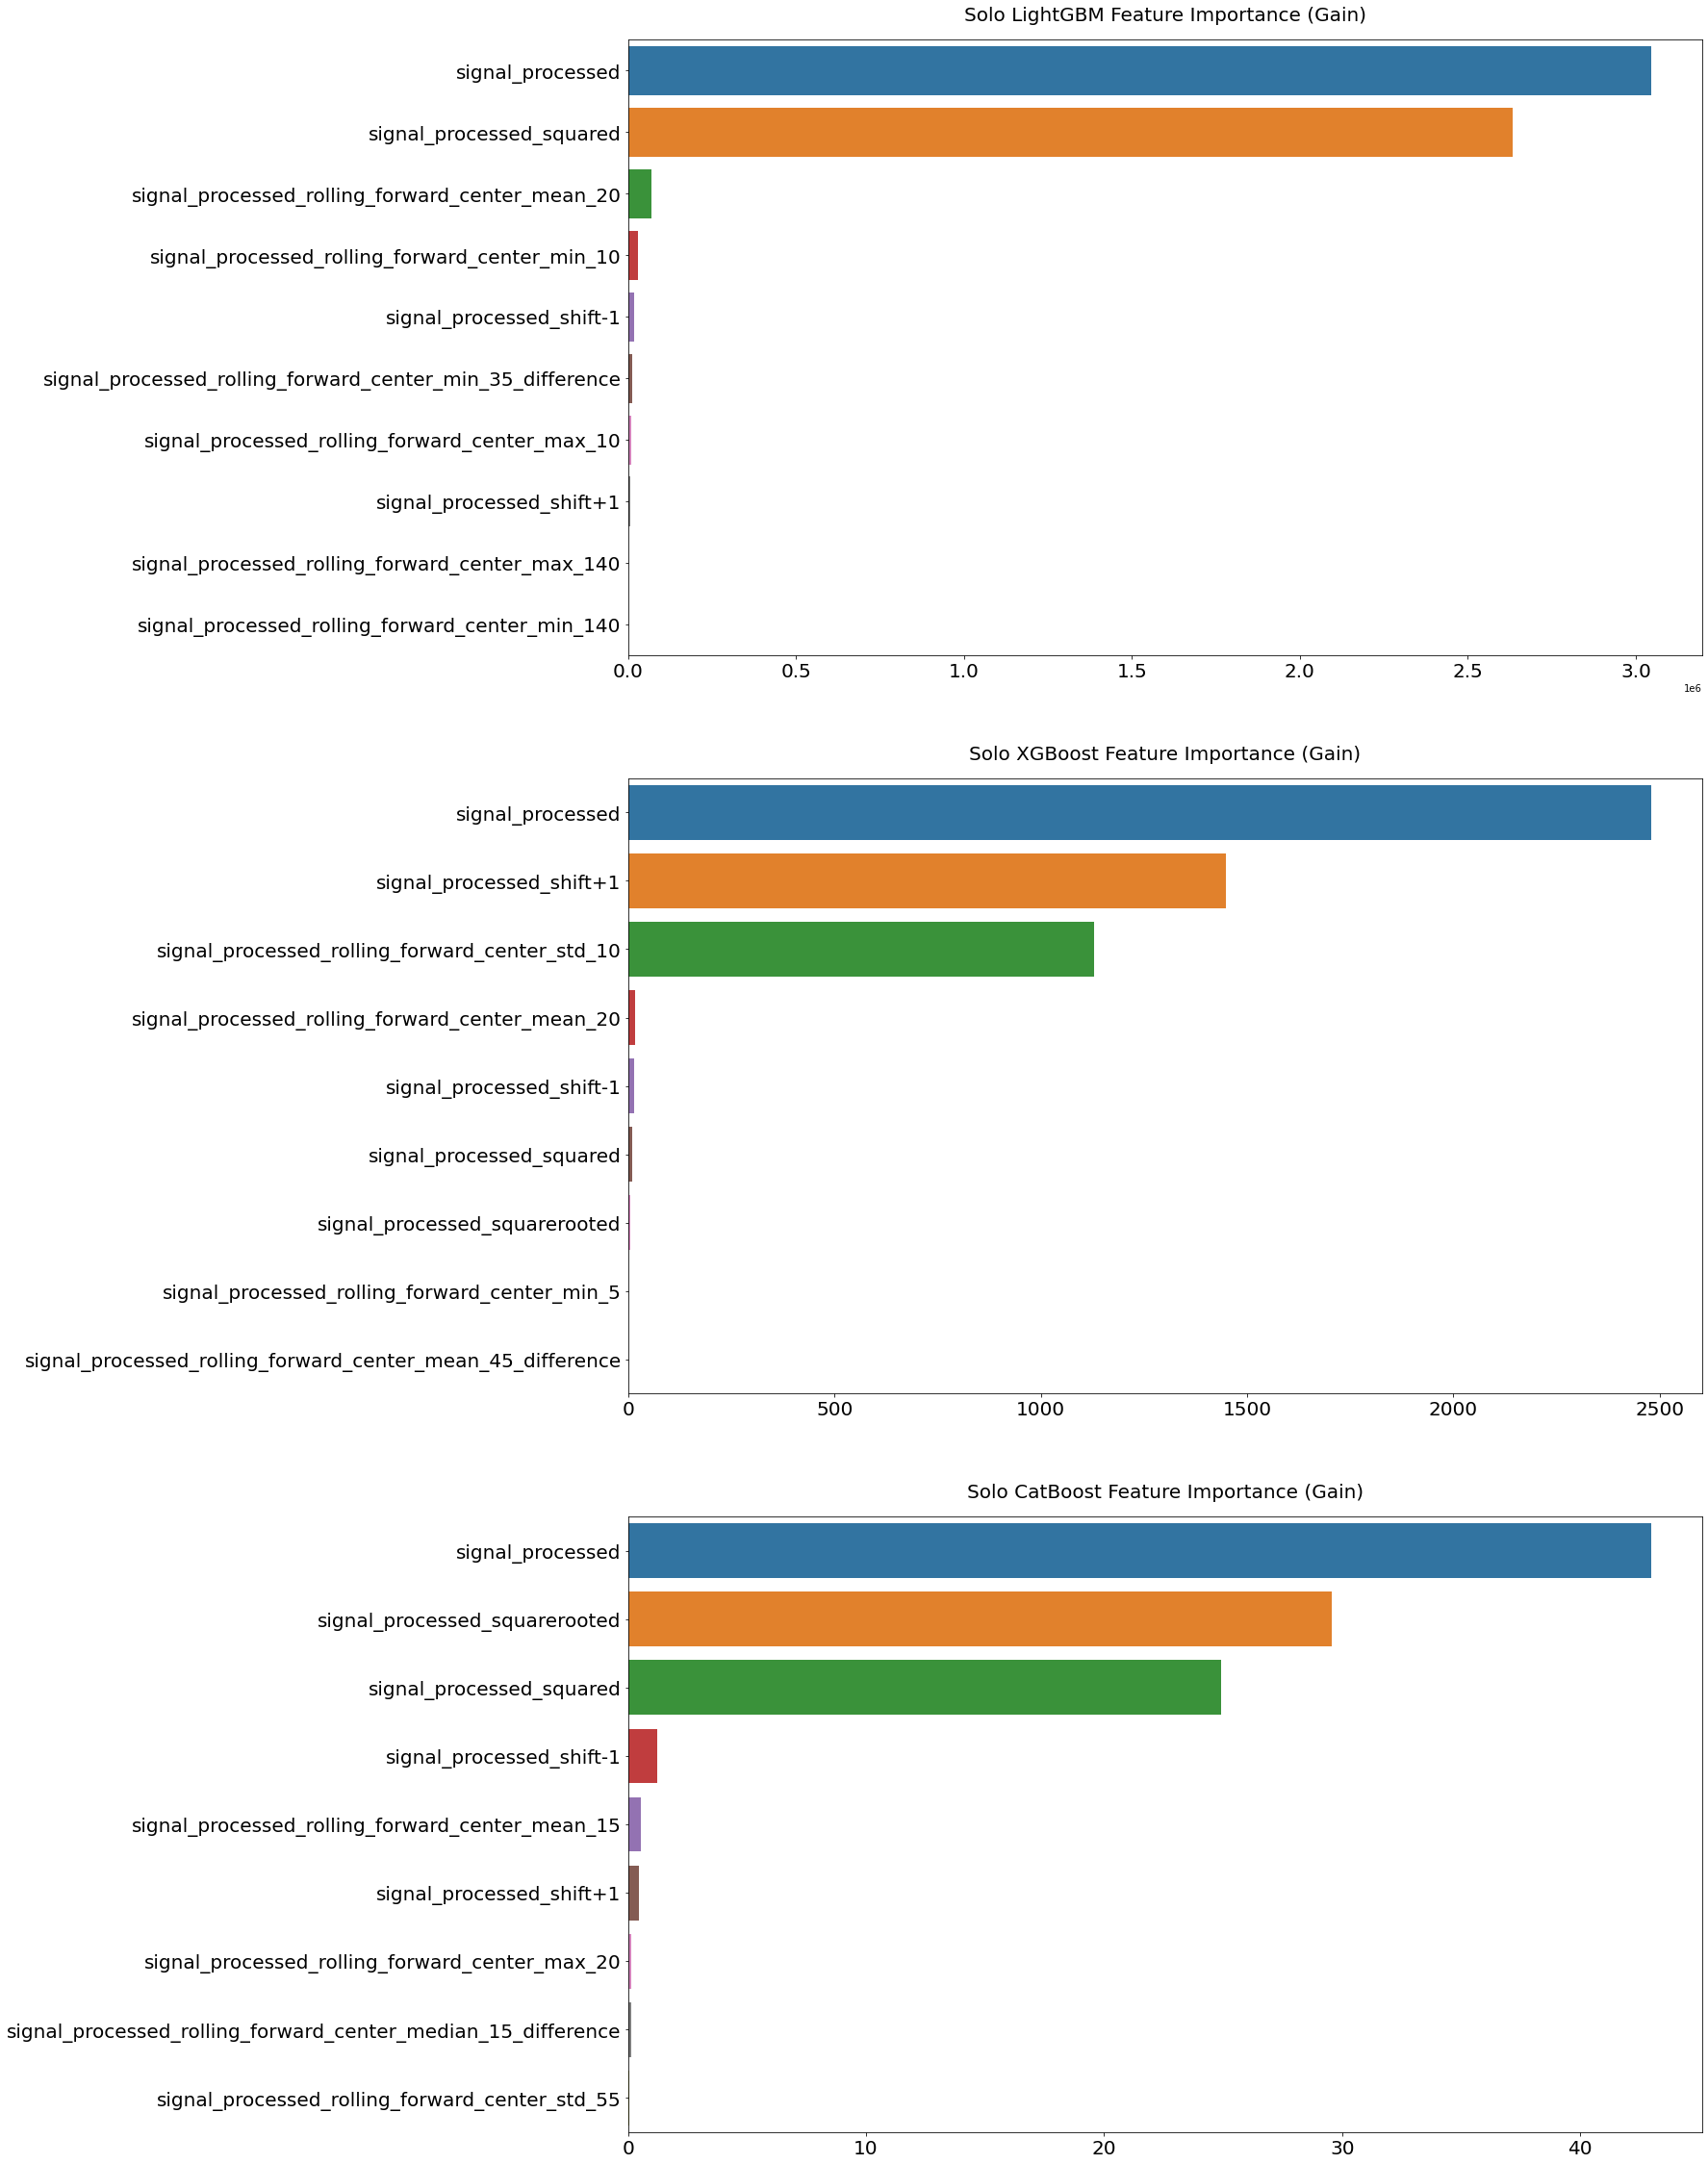

In [9]:
#################### SOLO MODEL 4 ####################

print('#################### SOLO MODEL 4 ####################')
print('------------------------------------------------------')

########## SOLO MODEL 4 LGB ##########

model4_lgb_features = ['signal_processed']
model4_lgb_X_train = df_train[df_train['model'] == 4][model4_lgb_features].copy(deep=True)
model4_lgb_y_train = df_train[df_train['model'] == 4]['open_channels'].copy(deep=True)
model4_lgb_X_test = df_test[df_test['model'] == 4][model4_lgb_features].copy(deep=True)

model4_lgb_sample_weight = model4_lgb_y_train.copy(deep=True).reset_index(drop=True)
model4_lgb_sample_weight.loc[model4_lgb_sample_weight == 0] = 1
model4_lgb_sample_weight.loc[model4_lgb_sample_weight == 1] = 1
model4_lgb_sample_weight.loc[model4_lgb_sample_weight == 2] = 1
model4_lgb_sample_weight.loc[model4_lgb_sample_weight == 3] = 1
model4_lgb_sample_weight.loc[model4_lgb_sample_weight == 4] = 1
model4_lgb_sample_weight.loc[model4_lgb_sample_weight == 5] = 1
model4_lgb_sample_weight.loc[model4_lgb_sample_weight == 6] = 1
model4_lgb_sample_weight.loc[model4_lgb_sample_weight == 7] = 1
model4_lgb_sample_weight.loc[model4_lgb_sample_weight == 8] = 1
model4_lgb_sample_weight.loc[model4_lgb_sample_weight == 9] = 1
model4_lgb_sample_weight.loc[model4_lgb_sample_weight == 10] = 1

for df in [model4_lgb_X_train, model4_lgb_X_test]:
    for shift in range(1, 2):
        df[f'signal_processed_shift+{shift}'] = df['signal_processed'].shift(shift)
        df[f'signal_processed_shift-{shift}'] = df['signal_processed'].shift(-shift)
    df['signal_processed_squared'] = df['signal_processed'] ** 2      
    df['signal_processed_rolling_forward_center_mean_20'] = df['signal_processed'].rolling(window=20, min_periods=1, center=True).mean()
    df['signal_processed_rolling_forward_center_min_10'] = df['signal_processed'].rolling(window=10, min_periods=1, center=True).min()
    df['signal_processed_rolling_forward_center_max_10'] = df['signal_processed'].rolling(window=10, min_periods=1, center=True).max()
    df['signal_processed_rolling_forward_center_min_35_difference'] = df['signal_processed'] - df['signal_processed'].rolling(window=35, min_periods=1, center=True).min()
    df['signal_processed_rolling_forward_center_min_140'] = df['signal_processed'].rolling(window=140, min_periods=1, center=True).min()
    df['signal_processed_rolling_forward_center_max_140'] = df['signal_processed'].rolling(window=140, min_periods=1, center=True).max()
    
model4_lgb_parameters = {
    'num_iterations': 500,
    'early_stopping_round': 50,
    'num_leaves': 2 ** 7, 
    'learning_rate': 0.08,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.9,
    'feature_fraction_bynode': 0.8,
    'min_data_in_leaf': 20,
    'lambda_l1': 0,
    'lambda_l2': 0,
    'max_depth': -1,
    'objective': 'regression',
    'seed': LGB_SEED,
    'feature_fraction_seed': LGB_SEED,
    'bagging_seed': LGB_SEED,
    'drop_seed': LGB_SEED,
    'data_random_seed': LGB_SEED,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric': 'rmse',
    'n_jobs': -1,
}

########## SOLO MODEL 4 XGB ##########

model4_xgb_features = ['signal_processed']
model4_xgb_X_train = df_train[df_train['model'] == 4][model4_xgb_features].copy(deep=True)
model4_xgb_y_train = df_train[df_train['model'] == 4]['open_channels'].copy(deep=True)
model4_xgb_X_test = df_test[df_test['model'] == 4][model4_xgb_features].copy(deep=True)

model4_xgb_sample_weight = model4_xgb_y_train.copy(deep=True).reset_index(drop=True)
model4_xgb_sample_weight.loc[model4_xgb_sample_weight == 0] = 1
model4_xgb_sample_weight.loc[model4_xgb_sample_weight == 1] = 1
model4_xgb_sample_weight.loc[model4_xgb_sample_weight == 2] = 1
model4_xgb_sample_weight.loc[model4_xgb_sample_weight == 3] = 1
model4_xgb_sample_weight.loc[model4_xgb_sample_weight == 4] = 1
model4_xgb_sample_weight.loc[model4_xgb_sample_weight == 5] = 1
model4_xgb_sample_weight.loc[model4_xgb_sample_weight == 6] = 1
model4_xgb_sample_weight.loc[model4_xgb_sample_weight == 7] = 1
model4_xgb_sample_weight.loc[model4_xgb_sample_weight == 8] = 1
model4_xgb_sample_weight.loc[model4_xgb_sample_weight == 9] = 1
model4_xgb_sample_weight.loc[model4_xgb_sample_weight == 10] = 1

for df in [model4_xgb_X_train, model4_xgb_X_test]:
    for shift in range(1, 2):
        df[f'signal_processed_shift+{shift}'] = df['signal_processed'].shift(shift)
        df[f'signal_processed_shift-{shift}'] = df['signal_processed'].shift(-shift)
    df['signal_processed_squared'] = df['signal_processed'] ** 2
    df['signal_processed_squarerooted'] = df['signal_processed'] ** (1 / 2)
    df['signal_processed_rolling_forward_center_mean_20'] = df['signal_processed'].rolling(window=20, min_periods=1, center=True).mean()
    df['signal_processed_rolling_forward_center_std_10'] = df['signal_processed'].rolling(window=10, min_periods=1, center=True).std()
    df['signal_processed_rolling_forward_center_min_5'] = df['signal_processed'].rolling(window=5, min_periods=1, center=True).min()
    df['signal_processed_rolling_forward_center_mean_45_difference'] = df['signal_processed'] - df['signal_processed'].rolling(window=45, min_periods=1, center=True).mean()

model4_xgb_parameters = {
    'n_estimators': 2 ** 7, 
    'learning_rate': 0.08,
    'colsample_bytree': 0.9, 
    'colsample_bylevel': 0.9,
    'colsample_bynode': 0.8,
    'sumbsample': 0.9,
    'max_depth': 6,
    'gamma': 0,
    'min_child_weight': 1,
    'lambda': 1,
    'alpha': 0.5,
    'objective': 'reg:squarederror',
    'seed': XGB_SEED,
    'boosting_type': 'gbtree',
    'tree_method': 'auto',
    'silent': True,
    'verbose': 1,
    'n_jobs': -1,
}

########## SOLO MODEL 4 CB ##########

model4_cb_features = ['signal_processed']
model4_cb_X_train = df_train[df_train['model'] == 4][model4_cb_features].copy(deep=True)
model4_cb_y_train = df_train[df_train['model'] == 4]['open_channels'].copy(deep=True)
model4_cb_X_test = df_test[df_test['model'] == 4][model4_cb_features].copy(deep=True)

model4_cb_sample_weight = model4_cb_y_train.copy(deep=True).reset_index(drop=True)
model4_cb_sample_weight.loc[model4_cb_sample_weight == 0] = 1
model4_cb_sample_weight.loc[model4_cb_sample_weight == 1] = 1
model4_cb_sample_weight.loc[model4_cb_sample_weight == 2] = 1
model4_cb_sample_weight.loc[model4_cb_sample_weight == 3] = 1
model4_cb_sample_weight.loc[model4_cb_sample_weight == 4] = 1
model4_cb_sample_weight.loc[model4_cb_sample_weight == 5] = 1
model4_cb_sample_weight.loc[model4_cb_sample_weight == 6] = 1
model4_cb_sample_weight.loc[model4_cb_sample_weight == 7] = 1
model4_cb_sample_weight.loc[model4_cb_sample_weight == 8] = 1
model4_cb_sample_weight.loc[model4_cb_sample_weight == 9] = 1
model4_cb_sample_weight.loc[model4_cb_sample_weight == 10] = 1

for df in [model4_cb_X_train, model4_cb_X_test]:
    for shift in range(1, 2):
        df[f'signal_processed_shift+{shift}'] = df['signal_processed'].shift(shift)
        df[f'signal_processed_shift-{shift}'] = df['signal_processed'].shift(-shift)
    df['signal_processed_squared'] = df['signal_processed'] ** 2
    df['signal_processed_squarerooted'] = df['signal_processed'] ** (1 / 2)
    df['signal_processed_rolling_forward_center_mean_15'] = df['signal_processed'].rolling(window=15, min_periods=1, center=True).mean()
    df['signal_processed_rolling_forward_center_std_55'] = df['signal_processed'].rolling(window=55, min_periods=1, center=True).std()
    df['signal_processed_rolling_forward_center_max_20'] = df['signal_processed'].rolling(window=20, min_periods=1, center=True).max()
    df['signal_processed_rolling_forward_center_median_15_difference'] = df['signal_processed'] - df['signal_processed'].rolling(window=15, min_periods=1, center=True).median()

model4_cb_parameters = {
    'n_estimators': 450, 
    'learning_rate': 0.065,
    'depth': 6,
    'subsample': 0.7,
    'bagging_temperature': 1,
    'colsample_bylevel': 0.9,
    'l2_leaf_reg': 0.01,
    'metric_period': 50,
    'boost_from_average': True,
    'eval_metric': 'RMSE',
    'loss_function': 'RMSE',    
    'random_seed': CB_SEED,
    'verbose': 1,
}

########## SOLO MODEL 4 TRAINING ##########

solo_model4 = MultiModelGBDTEnsemble(lgb_parameters=model4_lgb_parameters,
                                     xgb_parameters=model4_xgb_parameters, 
                                     cb_parameters=model4_cb_parameters,
                                     model='Blend')

solo_model4.train_and_predict(lgb_X_train=model4_lgb_X_train, lgb_y_train=model4_lgb_y_train, lgb_X_test=model4_lgb_X_test,
                              xgb_X_train=model4_xgb_X_train, xgb_y_train=model4_xgb_y_train, xgb_X_test=model4_xgb_X_test, 
                              cb_X_train=model4_cb_X_train, cb_y_train=model4_cb_y_train, cb_X_test=model4_cb_X_test,
                              lgb_sample_weight=model4_lgb_sample_weight, xgb_sample_weight=model4_xgb_sample_weight, cb_sample_weight=model4_cb_sample_weight,
                              num_boosting_round=500, early_stopping_rounds=20,
                              model=4)
solo_model4.plot_importance()

del model4_lgb_X_train, model4_lgb_y_train, model4_lgb_X_test, model4_lgb_sample_weight, model4_lgb_parameters
del model4_xgb_X_train, model4_xgb_y_train, model4_xgb_X_test, model4_xgb_sample_weight, model4_xgb_parameters
del model4_cb_X_train, model4_cb_y_train, model4_cb_X_test, model4_cb_sample_weight, model4_cb_parameters
del solo_model4

### **3.6. Solo Model Evaluation**

In [10]:
print('#################### SOLO MODEL EVALUATION ####################')
print('---------------------------------------------------------------')

for model in range(5):
    print(f'\n########## Solo Model {model} ##########')
    print('----------------------------------')
    
    y_true = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'open_channels']
    lgb_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'lgb_solo_model_oof']
    xgb_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'xgb_solo_model_oof']
    cb_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'cb_solo_model_oof']
    equal_blend_oof = (lgb_oof * 0.34) + (xgb_oof * 0.33) + (cb_oof * 0.33)
    
    print(f'Solo LGB Model {model} OOF (Rounded) Macro F1-Score {f1_score(y_true, np.round(np.clip(lgb_oof, y_true.min(), y_true.max())), average="macro"):.6}')
    print(f'Solo XGB Model {model} OOF (Rounded) Macro F1-Score {f1_score(y_true, np.round(np.clip(xgb_oof, y_true.min(), y_true.max())), average="macro"):.6}')
    print(f'Solo CB Model {model} OOF (Rounded) Macro F1-Score {f1_score(y_true, np.round(np.clip(cb_oof, y_true.min(), y_true.max())), average="macro"):.6}')
    print(f'Solo Model {model} Equal Blend OOF (Rounded) Macro F1-Score {f1_score(y_true, np.round(np.clip(equal_blend_oof, y_true.min(), y_true.max())), average="macro"):.6}')
    
print(f'\n########## Solo Model Global ##########')
print('---------------------------------------')

global_y_true = df_train.loc[df_train['is_filtered'] == 0, 'open_channels']
global_lgb_oof = df_train.loc[df_train['is_filtered'] == 0, 'lgb_solo_model_oof']
global_xgb_oof = df_train.loc[df_train['is_filtered'] == 0, 'xgb_solo_model_oof']
global_cb_oof = df_train.loc[df_train['is_filtered'] == 0, 'cb_solo_model_oof']
global_equal_blend_oof = (global_lgb_oof * 0.34) + (global_xgb_oof * 0.33) + (global_cb_oof * 0.33)

print(f'Solo LGB Model Global OOF (Rounded) Macro F1-Score {f1_score(global_y_true, np.round(np.clip(global_lgb_oof, global_y_true.min(), global_y_true.max())), average="macro"):.6}')
print(f'Solo XGB Model Global OOF (Rounded) Macro F1-Score {f1_score(global_y_true, np.round(np.clip(global_xgb_oof, global_y_true.min(), global_y_true.max())), average="macro"):.6}')
print(f'Solo CB Model Global OOF (Rounded) Macro F1-Score {f1_score(global_y_true, np.round(np.clip(global_cb_oof, global_y_true.min(), global_y_true.max())), average="macro"):.6}')
print(f'Solo Model Global Equal Blend OOF (Rounded) Macro F1-Score {f1_score(global_y_true, np.round(np.clip(global_equal_blend_oof, global_y_true.min(), global_y_true.max())), average="macro"):.6}')

del global_y_true, global_lgb_oof, global_xgb_oof, global_cb_oof, global_equal_blend_oof

#################### SOLO MODEL EVALUATION ####################
---------------------------------------------------------------

########## Solo Model 0 ##########
----------------------------------
Solo LGB Model 0 OOF (Rounded) Macro F1-Score 0.997608
Solo XGB Model 0 OOF (Rounded) Macro F1-Score 0.997483
Solo CB Model 0 OOF (Rounded) Macro F1-Score 0.997461
Solo Model 0 Equal Blend OOF (Rounded) Macro F1-Score 0.99755

########## Solo Model 1 ##########
----------------------------------
Solo LGB Model 1 OOF (Rounded) Macro F1-Score 0.997186
Solo XGB Model 1 OOF (Rounded) Macro F1-Score 0.997202
Solo CB Model 1 OOF (Rounded) Macro F1-Score 0.997175
Solo Model 1 Equal Blend OOF (Rounded) Macro F1-Score 0.997219

########## Solo Model 2 ##########
----------------------------------
Solo LGB Model 2 OOF (Rounded) Macro F1-Score 0.984919
Solo XGB Model 2 OOF (Rounded) Macro F1-Score 0.985345
Solo CB Model 2 OOF (Rounded) Macro F1-Score 0.985434
Solo Model 2 Equal Blend OOF (Rounded) Mac

## **4. Duo Models**
Duo models are trained on only **Model 0** and **Model 1** together. The objective of duo models is maximizing the F1 score calculated on those two groups together because they have the same classes. Duo models are performing slightly better than solo models in both of those groups, and since they are trained on a different distribution, they are useful for blending. Their weights in blends are equal with solo models.

### **4.1. Duo Model LightGBM**

#################### DUO MODEL 0-1 ####################
-------------------------------------------------------

########## Running Duo LightGBM Model 0-1 ##########

Fold 1
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.11854	valid_1's rmse: 0.118332
[100]	training's rmse: 0.043538	valid_1's rmse: 0.0439501
[150]	training's rmse: 0.0311491	valid_1's rmse: 0.0322566
[200]	training's rmse: 0.0290176	valid_1's rmse: 0.0308018
[250]	training's rmse: 0.0281798	valid_1's rmse: 0.0305801
[300]	training's rmse: 0.0275877	valid_1's rmse: 0.0305714
Early stopping, best iteration is:
[268]	training's rmse: 0.0280051	valid_1's rmse: 0.0305589

Duo LGB Fold 1 Macro F1-Score 0.998727215066537


Fold 2
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.115665	valid_1's rmse: 0.116403
[100]	training's rmse: 0.0419288	valid_1's rmse: 0.0437009
[150]	training's rmse: 0.029735	valid_1's rmse: 0.0327608
[200]	training's rmse: 0.02789

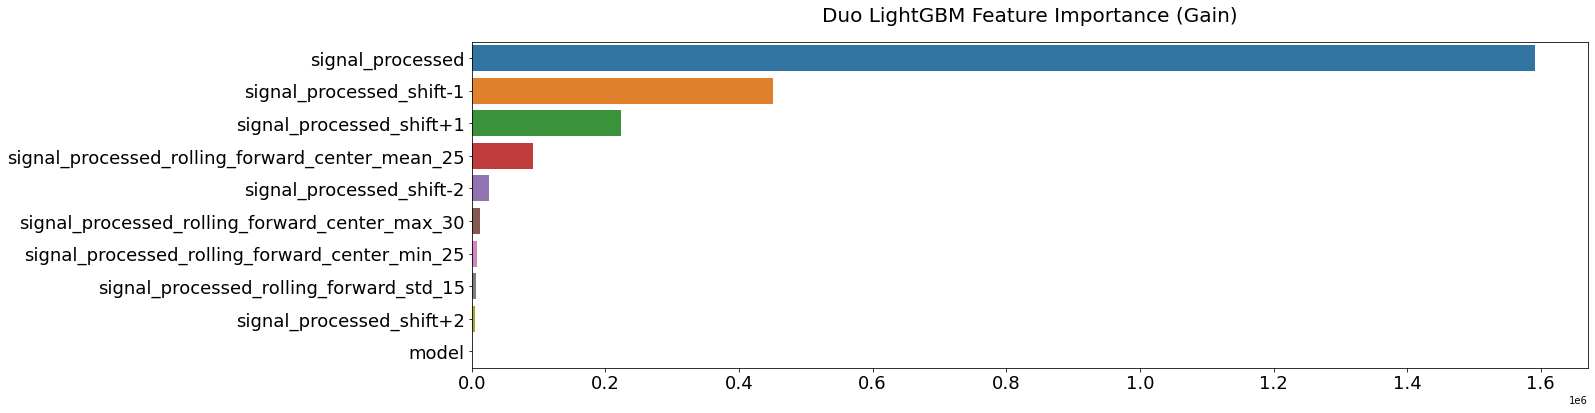

In [11]:
################### DUO MODEL 0-1 ####################

print('#################### DUO MODEL 0-1 ####################')
print('-------------------------------------------------------')

K = 2
skf = StratifiedKFold(n_splits=K)

########## DUO MODEL 0-1 LGB ##########

print(f'\n########## Running Duo LightGBM Model 0-1 ##########')

model01_lgb_features = ['signal_processed', 'model']
model01_lgb_X_train = df_train[df_train['model'] <= 1][model01_lgb_features].copy(deep=True)
model01_lgb_y_train = df_train[df_train['model'] <= 1]['open_channels'].copy(deep=True)
model01_lgb_X_test = df_test[df_train['model'] <= 1][model01_lgb_features].copy(deep=True)

for df in [model01_lgb_X_train, model01_lgb_X_test]:
    for shift in range(1, 3):
        df[f'signal_processed_shift+{shift}'] = df.groupby('model')['signal_processed'].shift(shift)
        df[f'signal_processed_shift-{shift}'] = df.groupby('model')['signal_processed'].shift(-shift)
    df['signal_processed_rolling_forward_center_mean_25'] = df.groupby('model')['signal_processed'].rolling(window=25, min_periods=1, center=True).mean().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_std_15'] = df.groupby('model')['signal_processed'].rolling(window=15, min_periods=1, center=False).std().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_min_25'] = df.groupby('model')['signal_processed'].rolling(window=25, min_periods=1, center=True).min().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_max_30'] = df.groupby('model')['signal_processed'].rolling(window=30, min_periods=1, center=True).max().reset_index(level='model')['signal_processed']

model01_lgb_parameters = {
    'num_iterations': 500,
    'early_stopping_round': 50,
    'num_leaves': 2 ** 6, 
    'learning_rate': 0.03,
    'bagging_fraction': 0.6,
    'bagging_freq': 1,
    'feature_fraction': 0.7,
    'feature_fraction_bynode': 0.7,
    'min_data_in_leaf': 20,
    'lambda_l1': 0.6,
    'lambda_l2': 0.6,
    'max_depth': -1,
    'objective': 'regression',
    'seed': LGB_SEED,
    'feature_fraction_seed': LGB_SEED,
    'bagging_seed': LGB_SEED,
    'drop_seed': LGB_SEED,
    'data_random_seed': LGB_SEED,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric': 'rmse',
    'n_jobs': -1,
}

model01_lgb_scores = []
model01_lgb_oof = np.zeros(model01_lgb_X_train.shape[0])
model01_lgb_y_pred = pd.DataFrame(np.zeros((model01_lgb_X_test.shape[0], K)), columns=[f'Fold_{i}_Predictions' for i in range(1, K + 1)]) 
model01_lgb_importance = pd.DataFrame(np.zeros((model01_lgb_X_train.shape[1], K)), columns=[f'Fold_{i}_Importance' for i in range(1, K + 1)], index=model01_lgb_X_train.columns)

for fold, (trn_idx, val_idx) in enumerate(skf.split(model01_lgb_X_train, model01_lgb_X_train['model']), 1):
    print(f'\nFold {fold}')

    model01_lgb_trn_data = lgb.Dataset(model01_lgb_X_train.iloc[trn_idx, :], label=model01_lgb_y_train.iloc[trn_idx], categorical_feature=['model'])
    model01_lgb_val_data = lgb.Dataset(model01_lgb_X_train.iloc[val_idx, :], label=model01_lgb_y_train.iloc[val_idx], categorical_feature=['model'])  

    model01_lgb_model = lgb.train(model01_lgb_parameters, model01_lgb_trn_data, valid_sets=[model01_lgb_trn_data, model01_lgb_val_data], verbose_eval=50)

    model01_lgb_oof_predictions = model01_lgb_model.predict(model01_lgb_X_train.iloc[val_idx, :], num_iteration=model01_lgb_model.best_iteration)
    model01_lgb_oof[val_idx] = model01_lgb_oof_predictions
    df_train.loc[model01_lgb_X_train.iloc[val_idx, :].index, 'lgb_duo_model_oof'] = model01_lgb_oof_predictions

    model01_lgb_test_predictions = model01_lgb_model.predict(model01_lgb_X_test, num_iteration=model01_lgb_model.best_iteration)
    model01_lgb_y_pred.iloc[:, fold - 1] = model01_lgb_test_predictions
    df_test.loc[model01_lgb_X_test.index, f'fold{fold}_lgb_duo_model_predictions'] = model01_lgb_test_predictions

    model01_lgb_importance.iloc[:, fold - 1] = model01_lgb_model.feature_importance(importance_type='gain')
    model01_lgb_score = f1_score(model01_lgb_y_train.iloc[val_idx].values, np.round(np.clip(model01_lgb_oof_predictions, model01_lgb_y_train.min(), model01_lgb_y_train.max())), average='macro')
    model01_lgb_scores.append(model01_lgb_score)            
    print('\nDuo LGB Fold {} Macro F1-Score {}\n'.format(fold, model01_lgb_score))

print('--------------------')
print(f'Duo LGB Mean Macro F1-Score {np.mean(model01_lgb_scores):.6} [STD:{np.std(model01_lgb_scores):.6}]')
for model in [0, 1]:
    model_oof = df_train.loc[df_train['model'] == model, 'lgb_duo_model_oof']
    model_labels = df_train.loc[df_train['model'] == model, 'open_channels']
    print(f'Duo LGB Model {model} OOF (Rounded) Macro F1-Score {f1_score(model_labels, np.round(np.clip(model_oof, model01_lgb_y_train.min(), model01_lgb_y_train.max())), average="macro"):.6}')
print(f'Duo LGB Model 0-1 OOF (Rounded) Macro F1-Score {f1_score(model01_lgb_y_train, np.round(np.clip(model01_lgb_oof, model01_lgb_y_train.min(), model01_lgb_y_train.max())), average="macro"):.6}')
print('--------------------')

plt.figure(figsize=(20, 6))

model01_lgb_importance['Mean_Importance'] = model01_lgb_importance.sum(axis=1) / K
model01_lgb_importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)
sns.barplot(x='Mean_Importance', y=model01_lgb_importance.index, data=model01_lgb_importance)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Duo LightGBM Feature Importance (Gain)', size=20, pad=20)

plt.show()

del model01_lgb_X_train, model01_lgb_y_train, model01_lgb_X_test, model01_lgb_parameters
del model01_lgb_scores, model01_lgb_oof, model01_lgb_y_pred, model01_lgb_importance
del model01_lgb_trn_data, model01_lgb_val_data, model01_lgb_model, model01_lgb_oof_predictions, model01_lgb_test_predictions

### **4.2. Duo Model XGBoost**

#################### DUO MODEL 0-1 ####################
-------------------------------------------------------

########## Running Duo XGBoost Model 0-1 ##########

Fold 1
[0]	train-rmse:0.46681	val-rmse:0.46681
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 25 rounds.
[50]	train-rmse:0.03392	val-rmse:0.03451
[100]	train-rmse:0.03009	val-rmse:0.03106
[150]	train-rmse:0.02992	val-rmse:0.03100
[200]	train-rmse:0.02984	val-rmse:0.03097
[250]	train-rmse:0.02977	val-rmse:0.03096
[300]	train-rmse:0.02970	val-rmse:0.03094
[350]	train-rmse:0.02961	val-rmse:0.03090
[400]	train-rmse:0.02952	val-rmse:0.03088
Stopping. Best iteration:
[418]	train-rmse:0.02952	val-rmse:0.03088


Duo XGB Fold 1 Macro F1-Score 0.9987576814057662


Fold 2
[0]	train-rmse:0.46681	val-rmse:0.46683
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 25 rounds.
[5

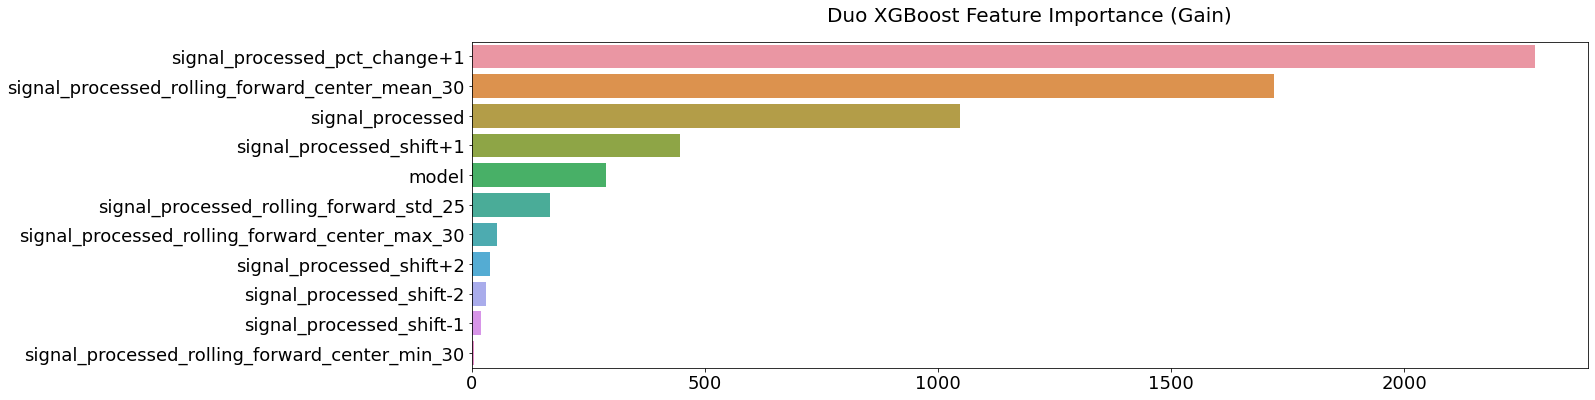

In [12]:
#################### DUO MODEL 0-1 ####################

print('#################### DUO MODEL 0-1 ####################')
print('-------------------------------------------------------')

K = 2
skf = StratifiedKFold(n_splits=K)

########## DUO MODEL 0-1 XGB ##########
    
print(f'\n########## Running Duo XGBoost Model 0-1 ##########')

model01_xgb_features = ['signal_processed', 'model']
model01_xgb_X_train = df_train[df_train['model'] <= 1][model01_xgb_features].copy(deep=True)
model01_xgb_y_train = df_train[df_train['model'] <= 1]['open_channels'].copy(deep=True)
model01_xgb_X_test = df_test[df_train['model'] <= 1][model01_xgb_features].copy(deep=True)

for df in [model01_xgb_X_train, model01_xgb_X_test]:
    for shift in range(1, 3):
        df[f'signal_processed_shift+{shift}'] = df.groupby('model')['signal_processed'].shift(shift)
        df[f'signal_processed_shift-{shift}'] = df.groupby('model')['signal_processed'].shift(-shift)
    df['signal_processed_rolling_forward_center_mean_30'] = df.groupby('model')['signal_processed'].rolling(window=30, min_periods=1, center=True).mean().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_std_25'] = df.groupby('model')['signal_processed'].rolling(window=25, min_periods=1, center=True).std().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_min_30'] = df.groupby('model')['signal_processed'].rolling(window=30, min_periods=1, center=False).min().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_max_30'] = df.groupby('model')['signal_processed'].rolling(window=30, min_periods=1, center=False).max().reset_index(level='model')['signal_processed']
    df['signal_processed_pct_change+1'] = df.groupby('model')['signal_processed'].pct_change(1).fillna(0)

model01_xgb_parameters = {
    'n_estimators': 2 ** 7, 
    'learning_rate': 0.07,
    'colsample_bytree': 0.8, 
    'colsample_bylevel': 0.8,
    'colsample_bynode': 0.7,
    'sumbsample': 0.7,
    'max_depth': 6,
    'gamma': 0.8,
    'min_child_weight': 1,
    'lambda': 1,
    'alpha': 0.1,
    'objective': 'reg:squarederror',
    'seed': XGB_SEED,
    'boosting_type': 'gbtree',
    'tree_method': 'auto',
    'silent': True,
    'verbose': 1,
    'n_jobs': -1,
}

model01_xgb_scores = []
model01_xgb_oof = np.zeros(model01_xgb_X_train.shape[0])
model01_xgb_y_pred = pd.DataFrame(np.zeros((model01_xgb_X_test.shape[0], K)), columns=[f'Fold_{i}_Predictions' for i in range(1, K + 1)]) 
model01_xgb_importance = pd.DataFrame(np.zeros((model01_xgb_X_train.shape[1], K)), columns=[f'Fold_{i}_Importance' for i in range(1, K + 1)], index=model01_xgb_X_train.columns)

for fold, (trn_idx, val_idx) in enumerate(skf.split(model01_xgb_X_train, model01_xgb_X_train['model']), 1):
    print(f'\nFold {fold}')

    model01_xgb_trn_data = xgb.DMatrix(model01_xgb_X_train.iloc[trn_idx, :], label=model01_xgb_y_train.iloc[trn_idx])
    model01_xgb_val_data = xgb.DMatrix(model01_xgb_X_train.iloc[val_idx, :], label=model01_xgb_y_train.iloc[val_idx])
    model01_xgb_model = xgb.train(model01_xgb_parameters, model01_xgb_trn_data, 500, evals=[(model01_xgb_trn_data, 'train'), (model01_xgb_val_data, 'val')], verbose_eval=50, early_stopping_rounds=25)

    model01_xgb_oof_predictions = model01_xgb_model.predict(xgb.DMatrix(model01_xgb_X_train.iloc[val_idx, :]))
    model01_xgb_oof[val_idx] = model01_xgb_oof_predictions
    df_train.loc[model01_xgb_X_train.iloc[val_idx, :].index, 'xgb_duo_model_oof'] = model01_xgb_oof_predictions

    model01_xgb_test_predictions = model01_xgb_model.predict(xgb.DMatrix(model01_xgb_X_test))
    model01_xgb_y_pred.iloc[:, fold - 1] = model01_xgb_test_predictions
    df_test.loc[model01_xgb_X_test.index, f'fold{fold}_xgb_duo_model_predictions'] = model01_xgb_test_predictions

    model01_xgb_importance.iloc[:, fold - 1] = list(model01_xgb_model.get_score(importance_type='gain').values())
    model01_xgb_score = f1_score(model01_xgb_y_train.iloc[val_idx].values, np.round(np.clip(model01_xgb_oof_predictions, model01_xgb_y_train.min(), model01_xgb_y_train.max())), average='macro')
    model01_xgb_scores.append(model01_xgb_score)            
    print('\nDuo XGB Fold {} Macro F1-Score {}\n'.format(fold, model01_xgb_score))

print('--------------------')
print(f'Duo XGB Mean Macro F1-Score {np.mean(model01_xgb_scores):.6} [STD:{np.std(model01_xgb_scores):.6}]')
for model in [0, 1]:
    model_oof = df_train.loc[df_train['model'] == model, 'xgb_duo_model_oof']
    model_labels = df_train.loc[df_train['model'] == model, 'open_channels']
    print(f'Duo XGB Model {model} OOF (Rounded) Macro F1-Score {f1_score(model_labels, np.round(np.clip(model_oof, model01_xgb_y_train.min(), model01_xgb_y_train.max())), average="macro"):.6}')
print(f'Duo XGB Model 0-1 OOF (Rounded) Macro F1-Score {f1_score(model01_xgb_y_train, np.round(np.clip(model01_xgb_oof, model01_xgb_y_train.min(), model01_xgb_y_train.max())), average="macro"):.6}')
print('--------------------')

plt.figure(figsize=(20, 6))

model01_xgb_importance['Mean_Importance'] = model01_xgb_importance.sum(axis=1) / K
model01_xgb_importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)
sns.barplot(x='Mean_Importance', y=model01_xgb_importance.index, data=model01_xgb_importance)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Duo XGBoost Feature Importance (Gain)', size=20, pad=20)

plt.show()

del model01_xgb_X_train, model01_xgb_y_train, model01_xgb_X_test, model01_xgb_parameters
del model01_xgb_scores, model01_xgb_oof, model01_xgb_y_pred, model01_xgb_importance
del model01_xgb_trn_data, model01_xgb_val_data, model01_xgb_model, model01_xgb_oof_predictions, model01_xgb_test_predictions

### **4.3. Duo Model CatBoost**

#################### DUO MODEL 0-1 ####################
-------------------------------------------------------

########## Running Duo CatBoost Model 0-1 ##########

Fold 1
0:	learn: 0.4503153	total: 158ms	remaining: 1m 2s
50:	learn: 0.0329318	total: 7.23s	remaining: 49.5s
100:	learn: 0.0310509	total: 14.1s	remaining: 41.7s
150:	learn: 0.0307162	total: 20.6s	remaining: 34s
200:	learn: 0.0304024	total: 27.1s	remaining: 26.9s
250:	learn: 0.0301065	total: 33.7s	remaining: 20s
300:	learn: 0.0298124	total: 40.4s	remaining: 13.3s
350:	learn: 0.0295470	total: 47.2s	remaining: 6.59s
399:	learn: 0.0292845	total: 53.9s	remaining: 0us

Duo CB Fold 1 Macro F1-Score 0.9987524360740915


Fold 2
0:	learn: 0.4489843	total: 139ms	remaining: 55.6s
50:	learn: 0.0319953	total: 7.13s	remaining: 48.8s
100:	learn: 0.0300605	total: 13.9s	remaining: 41.3s
150:	learn: 0.0296166	total: 21.4s	remaining: 35.3s
200:	learn: 0.0292379	total: 31.9s	remaining: 31.6s
250:	learn: 0.0289342	total: 38.8s	remaining: 23.1s


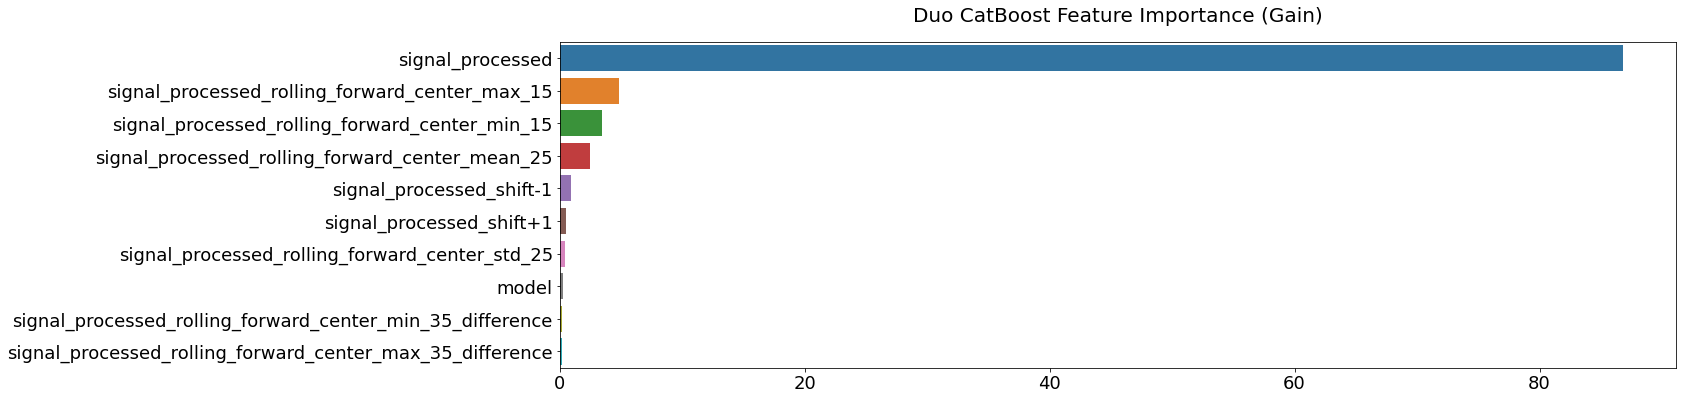

In [13]:
#################### DUO MODEL 0-1 ####################

print('#################### DUO MODEL 0-1 ####################')
print('-------------------------------------------------------')

K = 2
skf = StratifiedKFold(n_splits=K)

print(f'\n########## Running Duo CatBoost Model 0-1 ##########')

model01_cb_features = ['signal_processed', 'model']
model01_cb_X_train = df_train[df_train['model'] <= 1][model01_cb_features].copy(deep=True)
model01_cb_y_train = df_train[df_train['model'] <= 1]['open_channels'].copy(deep=True)
model01_cb_X_test = df_test[df_train['model'] <= 1][model01_cb_features].copy(deep=True)

for df in [model01_cb_X_train, model01_cb_X_test]:
    for shift in range(1, 2):
        df[f'signal_processed_shift+{shift}'] = df.groupby('model')['signal_processed'].shift(shift)
        df[f'signal_processed_shift-{shift}'] = df.groupby('model')['signal_processed'].shift(-shift)
    df['signal_processed_rolling_forward_center_mean_25'] = df.groupby('model')['signal_processed'].rolling(window=25, min_periods=1, center=True).mean().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_std_25'] = df.groupby('model')['signal_processed'].rolling(window=25, min_periods=1, center=True).std().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_min_15'] = df.groupby('model')['signal_processed'].rolling(window=15, min_periods=1, center=True).min().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_max_15'] = df.groupby('model')['signal_processed'].rolling(window=60, min_periods=1, center=True).max().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_min_35_difference'] = df['signal_processed'] - df.groupby('model')['signal_processed'].rolling(window=35, min_periods=1, center=False).min().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_max_35_difference'] = df.groupby('model')['signal_processed'].rolling(window=25, min_periods=1, center=False).max().reset_index(level='model')['signal_processed'] - df.groupby('model')['signal_processed'].rolling(window=25, min_periods=1, center=False).min().reset_index(level='model')['signal_processed']

model01_cb_parameters = {
    'n_estimators': 400, 
    'learning_rate': 0.08,
    'depth': 6,
    'subsample': 0.9,
    'bagging_temperature': 1,
    'colsample_bylevel': 0.9,
    'l2_leaf_reg': 0,
    'metric_period': 50,
    'boost_from_average': True,
    'eval_metric': 'RMSE',
    'loss_function': 'RMSE',    
    'random_seed': CB_SEED,
    'verbose': 1,
}

model01_cb_scores = []
model01_cb_oof = np.zeros(model01_cb_X_train.shape[0])
model01_cb_y_pred = pd.DataFrame(np.zeros((model01_cb_X_test.shape[0], K)), columns=[f'Fold_{i}_Predictions' for i in range(1, K + 1)]) 
model01_cb_importance = pd.DataFrame(np.zeros((model01_cb_X_train.shape[1], K)), columns=[f'Fold_{i}_Importance' for i in range(1, K + 1)], index=model01_cb_X_train.columns)

for fold, (trn_idx, val_idx) in enumerate(skf.split(model01_cb_X_train, model01_cb_X_train['model']), 1):
    print(f'\nFold {fold}')

    model01_cb_trn_data = cb.Pool(model01_cb_X_train.iloc[trn_idx, :], label=model01_cb_y_train.iloc[trn_idx], cat_features=[1]) 
    model01_cb_val_data = cb.Pool(model01_cb_X_train.iloc[val_idx, :], label=model01_cb_y_train.iloc[val_idx], cat_features=[1])            
    model01_cb_model = cb.CatBoostRegressor(**model01_cb_parameters)
    model01_cb_model.fit(model01_cb_trn_data)

    model01_cb_oof_predictions = model01_cb_model.predict(model01_cb_val_data)
    model01_cb_oof[val_idx] = model01_cb_oof_predictions
    df_train.loc[model01_cb_X_train.iloc[val_idx, :].index, 'cb_duo_model_oof'] = model01_cb_oof_predictions

    model01_cb_test_predictions = model01_cb_model.predict(cb.Pool(model01_cb_X_test, cat_features=[1]))
    model01_cb_y_pred.iloc[:, fold - 1] = model01_cb_test_predictions
    df_test.loc[model01_cb_X_test.index, f'fold{fold}_cb_duo_model_predictions'] = model01_cb_test_predictions

    model01_cb_importance.iloc[:, fold - 1] = model01_cb_model.get_feature_importance()
    model01_cb_score = f1_score(model01_cb_y_train.iloc[val_idx].values, np.round(np.clip(model01_cb_oof_predictions, model01_cb_y_train.min(), model01_cb_y_train.max())), average='macro')
    model01_cb_scores.append(model01_cb_score)            
    print('\nDuo CB Fold {} Macro F1-Score {}\n'.format(fold, model01_cb_score))

print('--------------------')
print(f'Duo CB Mean Macro F1-Score {np.mean(model01_cb_scores):.6} [STD:{np.std(model01_cb_scores):.6}]')
for model in [0, 1]:
    model_oof = df_train.loc[df_train['model'] == model, 'cb_duo_model_oof']
    model_labels = df_train.loc[df_train['model'] == model, 'open_channels']
    print(f'Duo CB Model {model} OOF (Rounded) Macro F1-Score {f1_score(model_labels, np.round(np.clip(model_oof, model01_cb_y_train.min(), model01_cb_y_train.max())), average="macro"):.6}')
print(f'Duo CB Model 0-1 OOF (Rounded) Macro F1-Score {f1_score(model01_cb_y_train, np.round(np.clip(model01_cb_oof, model01_cb_y_train.min(), model01_cb_y_train.max())), average="macro"):.6}')
print('--------------------')

plt.figure(figsize=(20, 6))

model01_cb_importance['Mean_Importance'] = model01_cb_importance.sum(axis=1) / K
model01_cb_importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)
sns.barplot(x='Mean_Importance', y=model01_cb_importance.index, data=model01_cb_importance)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Duo CatBoost Feature Importance (Gain)', size=20, pad=20)

plt.show()

del model01_cb_X_train, model01_cb_y_train, model01_cb_X_test, model01_cb_parameters
del model01_cb_scores, model01_cb_oof, model01_cb_y_pred, model01_cb_importance
del model01_cb_trn_data, model01_cb_val_data, model01_cb_model, model01_cb_oof_predictions, model01_cb_test_predictions

### **4.4. Duo Model Evaluation**

In [14]:
print('#################### DUO MODEL EVALUATION ####################')
print('--------------------------------------------------------------')

for model in range(2):
    print(f'\n########## Duo Model {model} ##########')
    print('---------------------------------')
    
    y_true = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'open_channels']
    lgb_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'lgb_duo_model_oof']
    xgb_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'xgb_duo_model_oof']
    cb_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'cb_duo_model_oof']
    equal_blend_oof = (lgb_oof * 0.34) + (xgb_oof * 0.33) + (cb_oof * 0.33)
    
    print(f'Duo LGB Model {model} OOF (Rounded) Macro F1-Score {f1_score(y_true, np.round(np.clip(lgb_oof, y_true.min(), y_true.max())), average="macro"):.6}')
    print(f'Duo XGB Model {model} OOF (Rounded) Macro F1-Score {f1_score(y_true, np.round(np.clip(xgb_oof, y_true.min(), y_true.max())), average="macro"):.6}')
    print(f'Duo CB Model {model} OOF (Rounded) Macro F1-Score {f1_score(y_true, np.round(np.clip(cb_oof, y_true.min(), y_true.max())), average="macro"):.6}')
    print(f'Duo Model {model} Equal Blend OOF (Rounded) Macro F1-Score {f1_score(y_true, np.round(np.clip(equal_blend_oof, y_true.min(), y_true.max())), average="macro"):.6}')
    
print(f'\n########## Duo Model Global ##########')
print('--------------------------------------')

global_y_true = df_train.loc[(df_train['is_filtered'] == 0) & (df_train['model'] <= 1), 'open_channels']
global_lgb_oof = df_train.loc[(df_train['is_filtered'] == 0) & (df_train['model'] <= 1), 'lgb_duo_model_oof']
global_xgb_oof = df_train.loc[(df_train['is_filtered'] == 0) & (df_train['model'] <= 1), 'xgb_duo_model_oof']
global_cb_oof = df_train.loc[(df_train['is_filtered'] == 0) & (df_train['model'] <= 1), 'cb_duo_model_oof']
global_equal_blend_oof = (global_lgb_oof * 0.34) + (global_xgb_oof * 0.33) + (global_cb_oof * 0.33)

print(f'Duo LGB Model Global (0-1) OOF (Rounded) Macro F1-Score {f1_score(global_y_true, np.round(np.clip(global_lgb_oof, global_y_true.min(), global_y_true.max())), average="macro"):.6}')
print(f'Duo XGB Model Global (0-1) OOF (Rounded) Macro F1-Score {f1_score(global_y_true, np.round(np.clip(global_xgb_oof, global_y_true.min(), global_y_true.max())), average="macro"):.6}')
print(f'Duo CB Model Global (0-1) OOF (Rounded) Macro F1-Score {f1_score(global_y_true, np.round(np.clip(global_cb_oof, global_y_true.min(), global_y_true.max())), average="macro"):.6}')
print(f'Duo Model Global (0-1) Equal Blend OOF (Rounded) Macro F1-Score {f1_score(global_y_true, np.round(np.clip(global_equal_blend_oof, global_y_true.min(), global_y_true.max())), average="macro"):.6}')

del global_y_true, global_lgb_oof, global_xgb_oof, global_cb_oof, global_equal_blend_oof

#################### DUO MODEL EVALUATION ####################
--------------------------------------------------------------

########## Duo Model 0 ##########
---------------------------------
Duo LGB Model 0 OOF (Rounded) Macro F1-Score 0.997602
Duo XGB Model 0 OOF (Rounded) Macro F1-Score 0.997551
Duo CB Model 0 OOF (Rounded) Macro F1-Score 0.997565
Duo Model 0 Equal Blend OOF (Rounded) Macro F1-Score 0.997603

########## Duo Model 1 ##########
---------------------------------
Duo LGB Model 1 OOF (Rounded) Macro F1-Score 0.997137
Duo XGB Model 1 OOF (Rounded) Macro F1-Score 0.997189
Duo CB Model 1 OOF (Rounded) Macro F1-Score 0.997168
Duo Model 1 Equal Blend OOF (Rounded) Macro F1-Score 0.997218

########## Duo Model Global ##########
--------------------------------------
Duo LGB Model Global (0-1) OOF (Rounded) Macro F1-Score 0.998706
Duo XGB Model Global (0-1) OOF (Rounded) Macro F1-Score 0.998723
Duo CB Model Global (0-1) OOF (Rounded) Macro F1-Score 0.998716
Duo Model Global 

## **5. Trio Models**
Trio models are trained on only **Model 0**, **Model 1** and **Model 2** together. The objective of trio models is maximizing the F1 score calculated on only **Model 2** because the class distribution in each model are different, so feature selection is done based on that objective. Trio models are performing better than Solo Model 2 since they are trained on a larger dataset. Their weights in blends are equal to solo models.

### **5.1. Trio Model LightGBM**

#################### TRIO MODEL 0-1-2 ####################
----------------------------------------------------------

########## Running Trio LightGBM Model 0-1-2 ##########

Fold 1
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.115189	valid_1's rmse: 0.112953
[100]	training's rmse: 0.0585467	valid_1's rmse: 0.0543642
[150]	training's rmse: 0.0563438	valid_1's rmse: 0.0534232
Early stopping, best iteration is:
[146]	training's rmse: 0.0564461	valid_1's rmse: 0.0534191

Trio LGB Fold 1 Macro F1-Score 0.9944763179943612


Fold 2
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 0.111345	valid_1's rmse: 0.116196
[100]	training's rmse: 0.0498662	valid_1's rmse: 0.0628475
[150]	training's rmse: 0.0475146	valid_1's rmse: 0.0621313
Early stopping, best iteration is:
[146]	training's rmse: 0.04762	valid_1's rmse: 0.0621216

Trio LGB Fold 2 Macro F1-Score 0.992256099637616

--------------------
Trio LGB Mean Macro F1-Score 

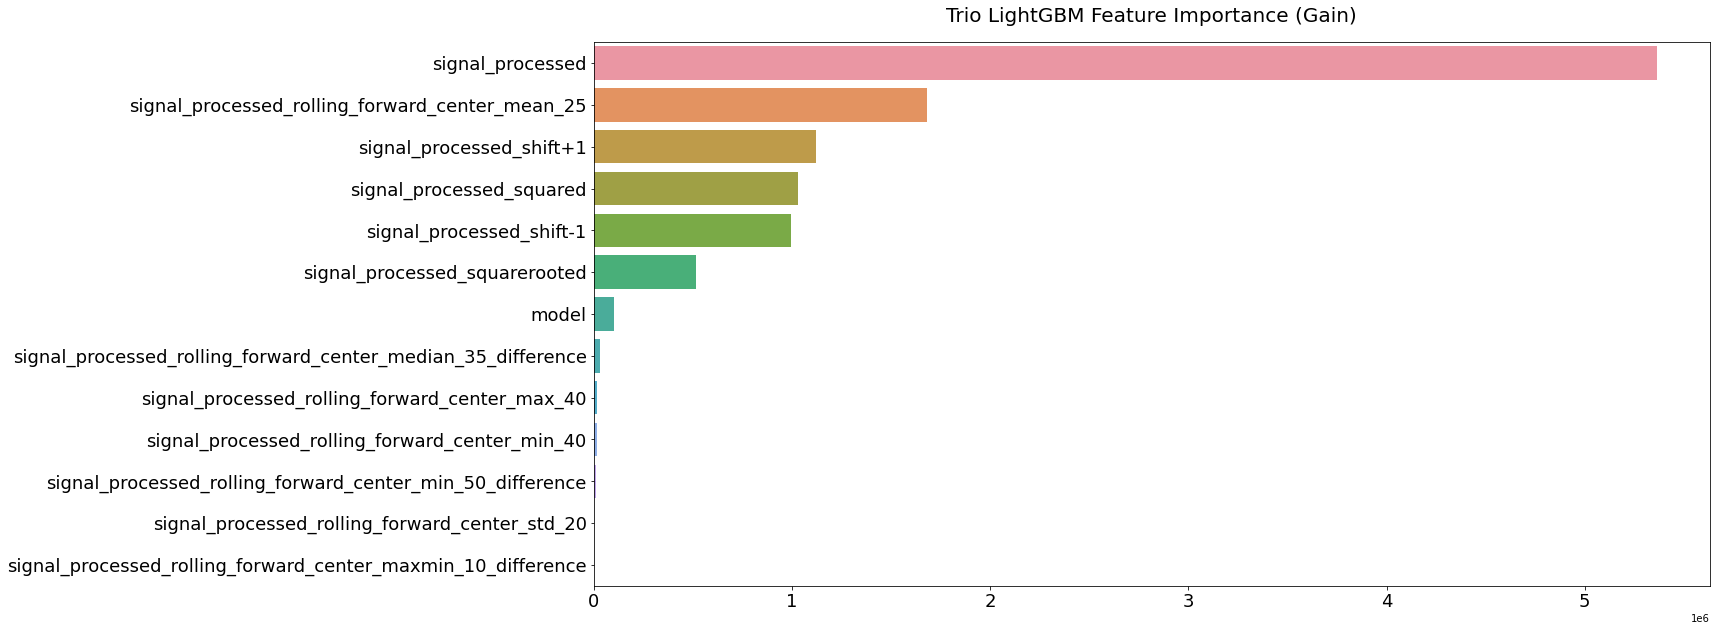

In [15]:
#################### TRIO MODEL 0-1-2 ####################

print('#################### TRIO MODEL 0-1-2 ####################')
print('----------------------------------------------------------')

K = 2
skf = StratifiedKFold(n_splits=K)

########## TRIO MODEL 0-1-2 LGB ##########

print(f'\n########## Running Trio LightGBM Model 0-1-2 ##########')

model012_lgb_features = ['signal_processed', 'model']
model012_lgb_X_train = df_train[(df_train['model'] <= 2) & (df_train['is_filtered'] == 0)][model012_lgb_features].copy(deep=True)
model012_lgb_y_train = df_train[(df_train['model'] <= 2) & (df_train['is_filtered'] == 0)]['open_channels'].copy(deep=True)
model012_lgb_X_test = df_test[df_test['model'] <= 2][model012_lgb_features].copy(deep=True)

for df in [model012_lgb_X_train, model012_lgb_X_test]:
    for shift in range(1, 2):
        df[f'signal_processed_shift+{shift}'] = df.groupby('model')['signal_processed'].shift(shift)
        df[f'signal_processed_shift-{shift}'] = df.groupby('model')['signal_processed'].shift(-shift)  
    df['signal_processed_rolling_forward_center_mean_25'] = df.groupby('model')['signal_processed'].rolling(window=25, min_periods=1, center=True).mean().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_std_20'] = df.groupby('model')['signal_processed'].rolling(window=20, min_periods=1, center=True).std().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_min_40'] = df.groupby('model')['signal_processed'].rolling(window=40, min_periods=1, center=True).min().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_max_40'] = df.groupby('model')['signal_processed'].rolling(window=40, min_periods=1, center=True).max().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_median_35_difference'] = df['signal_processed'] - df.groupby('model')['signal_processed'].rolling(window=35, min_periods=1, center=True).median().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_min_50_difference'] = df['signal_processed'] - df.groupby('model')['signal_processed'].rolling(window=50, min_periods=1, center=True).min().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_maxmin_10_difference'] = df.groupby('model')['signal_processed'].rolling(window=10, min_periods=1, center=True).max().reset_index(level='model')['signal_processed'] - df.groupby('model')['signal_processed'].rolling(window=10, min_periods=1, center=True).min().reset_index(level='model')['signal_processed']
    df['signal_processed_squared'] = df['signal_processed'] ** 2
    df['signal_processed_squarerooted'] = df['signal_processed'] ** (1 / 2)

model012_lgb_parameters = {
    'num_iterations': 300,
    'early_stopping_round': 50,
    'num_leaves': 2 ** 7, 
    'learning_rate': 0.045,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'feature_fraction': 0.8,
    'feature_fraction_bynode': 0.7,
    'min_data_in_leaf': 20,
    'lambda_l1': 0,
    'lambda_l2': 0.5,
    'max_depth': -1,
    'objective': 'regression',
    'seed': LGB_SEED,
    'feature_fraction_seed': LGB_SEED,
    'bagging_seed': LGB_SEED,
    'drop_seed': LGB_SEED,
    'data_random_seed': LGB_SEED,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric': 'rmse',
    'n_jobs': -1,
}
    
model012_lgb_scores = []
model012_lgb_oof = np.zeros(model012_lgb_X_train.shape[0])
model012_lgb_y_pred = pd.DataFrame(np.zeros((model012_lgb_X_test.shape[0], K)), columns=[f'Fold_{i}_Predictions' for i in range(1, K + 1)]) 
model012_lgb_importance = pd.DataFrame(np.zeros((model012_lgb_X_train.shape[1], K)), columns=[f'Fold_{i}_Importance' for i in range(1, K + 1)], index=model012_lgb_X_train.columns)

for fold, (trn_idx, val_idx) in enumerate(skf.split(model012_lgb_X_train, model012_lgb_X_train['model']), 1):
    print(f'\nFold {fold}')

    model012_lgb_trn_data = lgb.Dataset(model012_lgb_X_train.iloc[trn_idx, :], label=model012_lgb_y_train.iloc[trn_idx], categorical_feature=['model'])
    model012_lgb_val_data = lgb.Dataset(model012_lgb_X_train.iloc[val_idx, :], label=model012_lgb_y_train.iloc[val_idx], categorical_feature=['model'])  

    model012_lgb_model = lgb.train(model012_lgb_parameters, model012_lgb_trn_data, valid_sets=[model012_lgb_trn_data, model012_lgb_val_data], verbose_eval=50)

    model012_lgb_oof_predictions = model012_lgb_model.predict(model012_lgb_X_train.iloc[val_idx, :], num_iteration=model012_lgb_model.best_iteration)
    model012_lgb_oof[val_idx] = model012_lgb_oof_predictions
    df_train.loc[model012_lgb_X_train.iloc[val_idx, :].index, 'lgb_trio_model_oof'] = model012_lgb_oof_predictions

    model012_lgb_test_predictions = model012_lgb_model.predict(model012_lgb_X_test, num_iteration=model012_lgb_model.best_iteration)
    model012_lgb_y_pred.iloc[:, fold - 1] = model012_lgb_test_predictions
    df_test.loc[model012_lgb_X_test.index, f'fold{fold}_lgb_trio_model_predictions'] = model012_lgb_test_predictions

    model012_lgb_importance.iloc[:, fold - 1] = model012_lgb_model.feature_importance(importance_type='gain')
    model012_lgb_score = f1_score(model012_lgb_y_train.iloc[val_idx].values, np.round(np.clip(model012_lgb_oof_predictions, model012_lgb_y_train.min(), model012_lgb_y_train.max())), average='macro')
    model012_lgb_scores.append(model012_lgb_score)            
    print('\nTrio LGB Fold {} Macro F1-Score {}\n'.format(fold, model012_lgb_score))

print('--------------------')
print(f'Trio LGB Mean Macro F1-Score {np.mean(model012_lgb_scores):.6} [STD:{np.std(model012_lgb_scores):.6}]')
for model in [0, 1, 2]:
    model_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'lgb_trio_model_oof']
    model_labels = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'open_channels']
    print(f'Trio LGB Model {model} OOF (Rounded) Macro F1-Score {f1_score(model_labels, np.round(np.clip(model_oof, model012_lgb_y_train.min(), model012_lgb_y_train.max())), average="macro"):.6}')
print(f'Trio LGB Model 0-1-2 OOF (Rounded) Macro F1-Score {f1_score(model012_lgb_y_train, np.round(np.clip(model012_lgb_oof, model012_lgb_y_train.min(), model012_lgb_y_train.max())), average="macro"):.6}')
print('--------------------')

plt.figure(figsize=(20, 10))

model012_lgb_importance['Mean_Importance'] = model012_lgb_importance.sum(axis=1) / K
model012_lgb_importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)
sns.barplot(x='Mean_Importance', y=model012_lgb_importance.index, data=model012_lgb_importance)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Trio LightGBM Feature Importance (Gain)', size=20, pad=20)

plt.show()

del model012_lgb_X_train, model012_lgb_y_train, model012_lgb_X_test, model012_lgb_parameters
del model012_lgb_scores, model012_lgb_oof, model012_lgb_y_pred, model012_lgb_importance
del model012_lgb_trn_data, model012_lgb_val_data, model012_lgb_model, model012_lgb_oof_predictions, model012_lgb_test_predictions

### **5.2. Trio Model XGBoost**

#################### TRIO MODEL 0-1-2 ####################
----------------------------------------------------------

########## Running Trio XGBoost Model 0-1-2 ##########

Fold 1
[0]	train-rmse:0.96419	val-rmse:0.96535
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 25 rounds.
[50]	train-rmse:0.05971	val-rmse:0.05398
[100]	train-rmse:0.05824	val-rmse:0.05348
[150]	train-rmse:0.05759	val-rmse:0.05346
Stopping. Best iteration:
[144]	train-rmse:0.05765	val-rmse:0.05345


Trio XGB Fold 1 Macro F1-Score 0.9945105981848231


Fold 2
[0]	train-rmse:0.96536	val-rmse:0.96425
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 25 rounds.
[50]	train-rmse:0.05116	val-rmse:0.06264
[100]	train-rmse:0.04966	val-rmse:0.06228
Stopping. Best iteration:
[117]	train-rmse:0.04949	val-rmse:0.06228


Trio XGB Fold 2 Macro F1-Score 0.9921915195840398

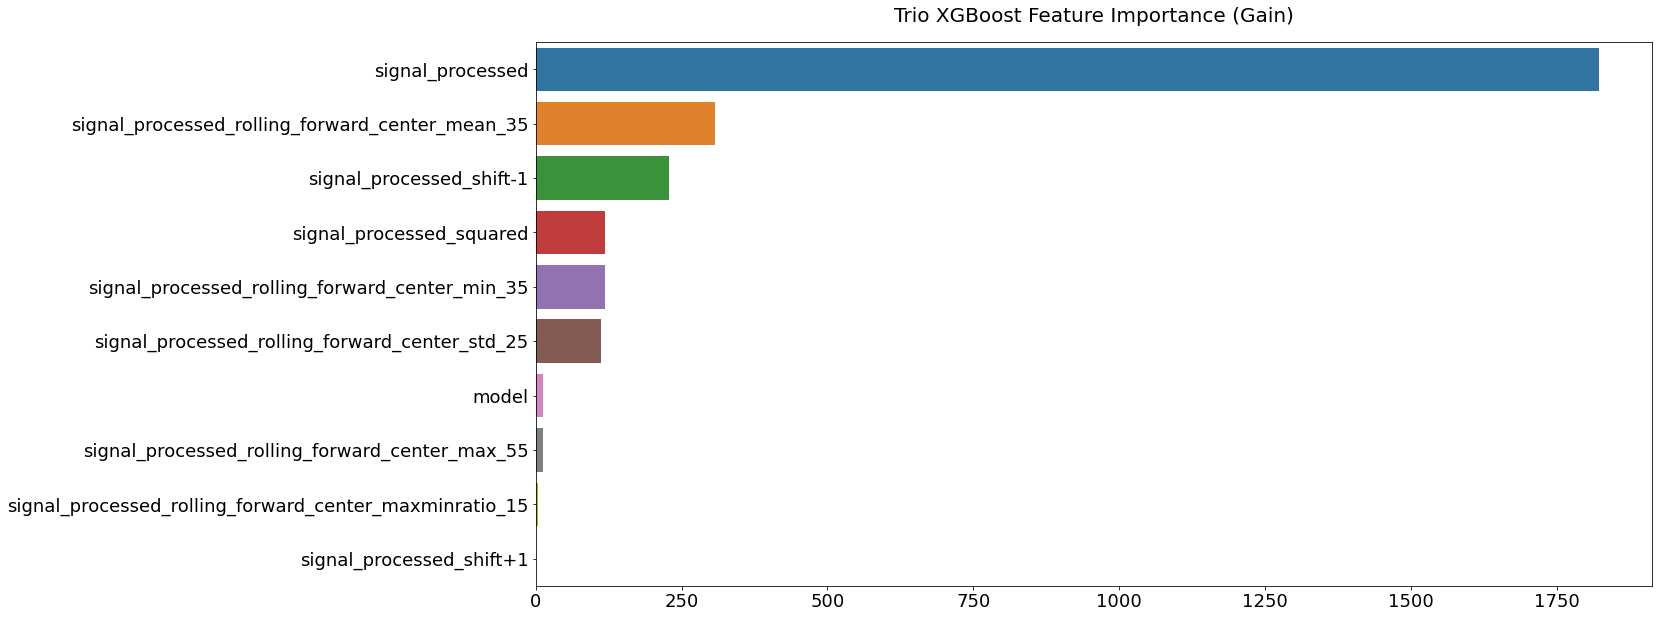

In [16]:
#################### TRIO MODEL 0-1-2 ####################

print('#################### TRIO MODEL 0-1-2 ####################')
print('----------------------------------------------------------')

K = 2
skf = StratifiedKFold(n_splits=K)

########## TRIO MODEL 0-1-2 XGB ##########

print(f'\n########## Running Trio XGBoost Model 0-1-2 ##########')

model012_xgb_features = ['signal_processed', 'model']
model012_xgb_X_train = df_train[(df_train['model'] <= 2) & (df_train['is_filtered'] == 0)][model012_xgb_features].copy(deep=True)
model012_xgb_y_train = df_train[(df_train['model'] <= 2) & (df_train['is_filtered'] == 0)]['open_channels'].copy(deep=True)
model012_xgb_X_test = df_test[df_test['model'] <= 2][model012_xgb_features].copy(deep=True)

for df in [model012_xgb_X_train, model012_xgb_X_test]:
    for shift in range(1, 2):
        df[f'signal_processed_shift+{shift}'] = df.groupby('model')['signal_processed'].shift(shift)
        df[f'signal_processed_shift-{shift}'] = df.groupby('model')['signal_processed'].shift(-shift)
    df['signal_processed_rolling_forward_center_mean_35'] = df.groupby('model')['signal_processed'].rolling(window=35, min_periods=1, center=True).mean().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_std_25'] = df.groupby('model')['signal_processed'].rolling(window=25, min_periods=1, center=True).std().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_min_35'] = df.groupby('model')['signal_processed'].rolling(window=35, min_periods=1, center=True).min().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_max_55'] = df.groupby('model')['signal_processed'].rolling(window=55, min_periods=1, center=True).max().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_maxminratio_15'] = df.groupby('model')['signal_processed'].rolling(window=15, min_periods=1, center=True).max().reset_index(level='model')['signal_processed'] / df.groupby('model')['signal_processed'].rolling(window=15, min_periods=1, center=True).min().reset_index(level='model')['signal_processed']
    df['signal_processed_squared'] = df['signal_processed'] ** 2
    
model012_xgb_parameters = {
    'n_estimators': 2 ** 7, 
    'learning_rate': 0.095,
    'colsample_bytree': 0.9, 
    'colsample_bylevel': 0.9,
    'colsample_bynode': 0.9,
    'sumbsample': 0.7,
    'max_depth': 7,
    'gamma': 0,
    'min_child_weight': 1,
    'lambda': 1,
    'alpha': 0,
    'objective': 'reg:squarederror',
    'seed': XGB_SEED,
    'boosting_type': 'gbtree',
    'tree_method': 'auto',
    'silent': True,
    'verbose': 1,
    'n_jobs': -1,
}

model012_xgb_scores = []
model012_xgb_oof = np.zeros(model012_xgb_X_train.shape[0])
model012_xgb_y_pred = pd.DataFrame(np.zeros((model012_xgb_X_test.shape[0], K)), columns=[f'Fold_{i}_Predictions' for i in range(1, K + 1)]) 
model012_xgb_importance = pd.DataFrame(np.zeros((model012_xgb_X_train.shape[1], K)), columns=[f'Fold_{i}_Importance' for i in range(1, K + 1)], index=model012_xgb_X_train.columns)

for fold, (trn_idx, val_idx) in enumerate(skf.split(model012_xgb_X_train, model012_xgb_X_train['model']), 1):
    print(f'\nFold {fold}')

    model012_xgb_trn_data = xgb.DMatrix(model012_xgb_X_train.iloc[trn_idx, :], label=model012_xgb_y_train.iloc[trn_idx])
    model012_xgb_val_data = xgb.DMatrix(model012_xgb_X_train.iloc[val_idx, :], label=model012_xgb_y_train.iloc[val_idx])
    
    model012_xgb_model = xgb.train(model012_xgb_parameters, model012_xgb_trn_data, 500, evals=[(model012_xgb_trn_data, 'train'), (model012_xgb_val_data, 'val')], verbose_eval=50, early_stopping_rounds=25)

    model012_xgb_oof_predictions = model012_xgb_model.predict(xgb.DMatrix(model012_xgb_X_train.iloc[val_idx, :]))
    model012_xgb_oof[val_idx] = model012_xgb_oof_predictions
    df_train.loc[model012_xgb_X_train.iloc[val_idx, :].index, 'xgb_trio_model_oof'] = model012_xgb_oof_predictions

    model012_xgb_test_predictions = model012_xgb_model.predict(xgb.DMatrix(model012_xgb_X_test))
    model012_xgb_y_pred.iloc[:, fold - 1] = model012_xgb_test_predictions
    df_test.loc[model012_xgb_X_test.index, f'fold{fold}_xgb_trio_model_predictions'] = model012_xgb_test_predictions

    model012_xgb_importance.iloc[:, fold - 1] = list(model012_xgb_model.get_score(importance_type='gain').values())
    model012_xgb_score = f1_score(model012_xgb_y_train.iloc[val_idx].values, np.round(np.clip(model012_xgb_oof_predictions, model012_xgb_y_train.min(), model012_xgb_y_train.max())), average='macro')
    model012_xgb_scores.append(model012_xgb_score)            
    print('\nTrio XGB Fold {} Macro F1-Score {}\n'.format(fold, model012_xgb_score))

print('--------------------')
print(f'Trio XGB Mean Macro F1-Score {np.mean(model012_xgb_scores):.6} [STD:{np.std(model012_xgb_scores):.6}]')
for model in [0, 1, 2]:
    model_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'xgb_trio_model_oof']
    model_labels = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'open_channels']
    print(f'Trio XGB Model {model} OOF (Rounded) Macro F1-Score {f1_score(model_labels, np.round(np.clip(model_oof, model012_xgb_y_train.min(), model012_xgb_y_train.max())), average="macro"):.6}')
print(f'Trio XGB Model 0-1-2 OOF (Rounded) Macro F1-Score {f1_score(model012_xgb_y_train, np.round(np.clip(model012_xgb_oof, model012_xgb_y_train.min(), model012_xgb_y_train.max())), average="macro"):.6}')
print('--------------------')

plt.figure(figsize=(20, 10))

model012_xgb_importance['Mean_Importance'] = model012_xgb_importance.sum(axis=1) / K
model012_xgb_importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)
sns.barplot(x='Mean_Importance', y=model012_xgb_importance.index, data=model012_xgb_importance)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Trio XGBoost Feature Importance (Gain)', size=20, pad=20)

plt.show()

del model012_xgb_X_train, model012_xgb_y_train, model012_xgb_X_test, model012_xgb_parameters
del model012_xgb_scores, model012_xgb_oof, model012_xgb_y_pred, model012_xgb_importance
del model012_xgb_trn_data, model012_xgb_val_data, model012_xgb_model, model012_xgb_oof_predictions, model012_xgb_test_predictions

### **5.3. Trio Model CatBoost**

#################### TRIO MODEL 0-1-2 ####################
----------------------------------------------------------

########## Running Trio CatBoost Model 0-1-2 ##########

Fold 1
0:	learn: 0.9022004	total: 586ms	remaining: 4m 52s
50:	learn: 0.0693878	total: 25.8s	remaining: 3m 46s
100:	learn: 0.0636993	total: 49.3s	remaining: 3m 14s
150:	learn: 0.0623455	total: 1m 12s	remaining: 2m 48s
200:	learn: 0.0616738	total: 1m 35s	remaining: 2m 22s
250:	learn: 0.0612747	total: 1m 59s	remaining: 1m 58s
300:	learn: 0.0609145	total: 2m 22s	remaining: 1m 34s
350:	learn: 0.0606175	total: 2m 45s	remaining: 1m 10s
400:	learn: 0.0603666	total: 3m 8s	remaining: 46.6s
450:	learn: 0.0600849	total: 3m 31s	remaining: 23s
499:	learn: 0.0598479	total: 3m 54s	remaining: 0us

Trio CB Fold 1 Macro F1-Score 0.9944829809925271


Fold 2
0:	learn: 0.9067538	total: 559ms	remaining: 4m 38s
50:	learn: 0.0607440	total: 24.5s	remaining: 3m 35s
100:	learn: 0.0551677	total: 47.8s	remaining: 3m 8s
150:	learn: 0.0538385	t

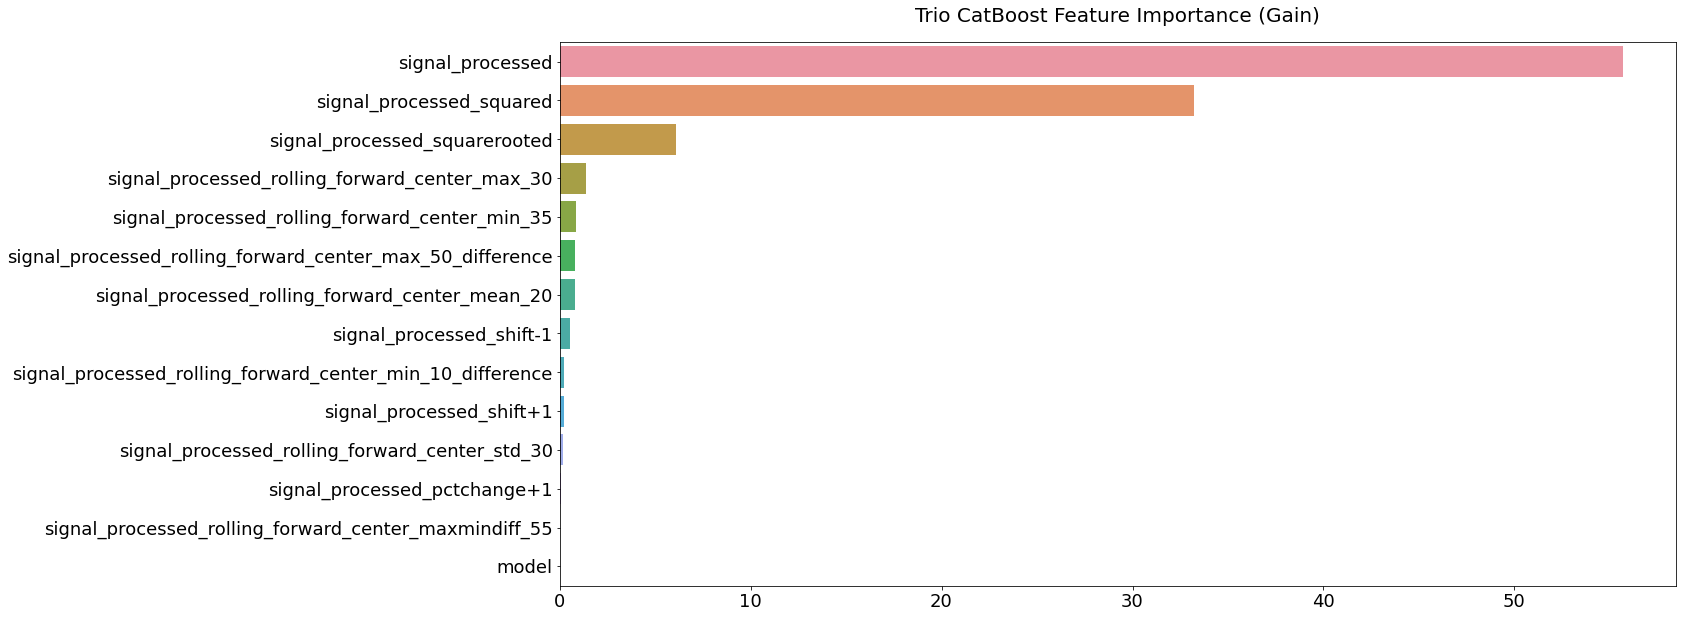

In [17]:
#################### TRIO MODEL 0-1-2 ####################

print('#################### TRIO MODEL 0-1-2 ####################')
print('----------------------------------------------------------')

K = 2
skf = StratifiedKFold(n_splits=K)

########## TRIO MODEL 0-1-2 XGB ##########

print(f'\n########## Running Trio CatBoost Model 0-1-2 ##########')

model012_cb_features = ['signal_processed', 'model']
model012_cb_X_train = df_train[(df_train['model'] <= 2) & (df_train['is_filtered'] == 0)][model012_cb_features].copy(deep=True)
model012_cb_y_train = df_train[(df_train['model'] <= 2) & (df_train['is_filtered'] == 0)]['open_channels'].copy(deep=True)
model012_cb_X_test = df_test[df_test['model'] <= 2][model012_cb_features].copy(deep=True)

for df in [model012_cb_X_train, model012_cb_X_test]:
    for shift in range(1, 2):
        df[f'signal_processed_shift+{shift}'] = df.groupby('model')['signal_processed'].shift(shift)
        df[f'signal_processed_shift-{shift}'] = df.groupby('model')['signal_processed'].shift(-shift)
    df['signal_processed_rolling_forward_center_mean_20'] = df.groupby('model')['signal_processed'].rolling(window=20, min_periods=1, center=True).mean().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_std_30'] = df.groupby('model')['signal_processed'].rolling(window=30, min_periods=1, center=True).std().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_min_35'] = df.groupby('model')['signal_processed'].rolling(window=35, min_periods=1, center=True).min().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_max_30'] = df.groupby('model')['signal_processed'].rolling(window=30, min_periods=1, center=True).max().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_min_10_difference'] = df['signal_processed'] - df.groupby('model')['signal_processed'].rolling(window=10, min_periods=1, center=True).min().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_max_50_difference'] = df['signal_processed'] - df.groupby('model')['signal_processed'].rolling(window=50, min_periods=1, center=True).max().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_maxmindiff_55'] = df.groupby('model')['signal_processed'].rolling(window=55, min_periods=1, center=False).max().reset_index(level='model')['signal_processed'] - df.groupby('model')['signal_processed'].rolling(window=55, min_periods=1, center=False).min().reset_index(level='model')['signal_processed']
    df['signal_processed_squared'] = df['signal_processed'] ** 2
    df['signal_processed_squarerooted'] = df['signal_processed'] ** (1 / 2)
    df['signal_processed_pctchange+1'] = df['signal_processed'].pct_change(1)

model012_cb_parameters = {
    'n_estimators': 500, 
    'learning_rate': 0.085,
    'depth': 7,
    'subsample': 0.8,
    'bagging_temperature': 1,
    'colsample_bylevel': 0.9,
    'l2_leaf_reg': 0.6,
    'metric_period': 50,
    'boost_from_average': True,
    'eval_metric': 'RMSE',
    'loss_function': 'RMSE',    
    'random_seed': CB_SEED,
    'verbose': 1,
}

model012_cb_scores = []
model012_cb_oof = np.zeros(model012_cb_X_train.shape[0])
model012_cb_y_pred = pd.DataFrame(np.zeros((model012_cb_X_test.shape[0], K)), columns=[f'Fold_{i}_Predictions' for i in range(1, K + 1)]) 
model012_cb_importance = pd.DataFrame(np.zeros((model012_cb_X_train.shape[1], K)), columns=[f'Fold_{i}_Importance' for i in range(1, K + 1)], index=model012_cb_X_train.columns)

for fold, (trn_idx, val_idx) in enumerate(skf.split(model012_cb_X_train, model012_cb_X_train['model']), 1):
    print(f'\nFold {fold}')

    model012_cb_trn_data = cb.Pool(model012_cb_X_train.iloc[trn_idx, :], label=model012_cb_y_train.iloc[trn_idx], cat_features=[1]) 
    model012_cb_val_data = cb.Pool(model012_cb_X_train.iloc[val_idx, :], label=model012_cb_y_train.iloc[val_idx], cat_features=[1])            
    model012_cb_model = cb.CatBoostRegressor(**model012_cb_parameters)
    model012_cb_model.fit(model012_cb_trn_data)

    model012_cb_oof_predictions = model012_cb_model.predict(model012_cb_val_data)
    model012_cb_oof[val_idx] = model012_cb_oof_predictions
    df_train.loc[model012_cb_X_train.iloc[val_idx, :].index, 'cb_trio_model_oof'] = model012_cb_oof_predictions

    model012_cb_test_predictions = model012_cb_model.predict(cb.Pool(model012_cb_X_test, cat_features=[1]))
    model012_cb_y_pred.iloc[:, fold - 1] = model012_cb_test_predictions
    df_test.loc[model012_cb_X_test.index, f'fold{fold}_cb_trio_model_predictions'] = model012_cb_test_predictions

    model012_cb_importance.iloc[:, fold - 1] = model012_cb_model.get_feature_importance()
    model012_cb_score = f1_score(model012_cb_y_train.iloc[val_idx].values, np.round(np.clip(model012_cb_oof_predictions, model012_cb_y_train.min(), model012_cb_y_train.max())), average='macro')
    model012_cb_scores.append(model012_cb_score)   
    print('\nTrio CB Fold {} Macro F1-Score {}\n'.format(fold, model012_cb_score))

print('--------------------')
print(f'Trio CB Mean Macro F1-Score {np.mean(model012_cb_scores):.6} [STD:{np.std(model012_cb_scores):.6}]')
for model in [0, 1, 2]:
    model_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'cb_trio_model_oof']
    model_labels = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'open_channels']
    print(f'Trio CB Model {model} OOF (Rounded) Macro F1-Score {f1_score(model_labels, np.round(np.clip(model_oof, model012_cb_y_train.min(), model012_cb_y_train.max())), average="macro"):.6}')
print(f'Trio CB Model 0-1-2 OOF (Rounded) Macro F1-Score {f1_score(model012_cb_y_train, np.round(np.clip(model012_cb_oof, model012_cb_y_train.min(), model012_cb_y_train.max())), average="macro"):.6}')
print('--------------------')

plt.figure(figsize=(20, 10))

model012_cb_importance['Mean_Importance'] = model012_cb_importance.sum(axis=1) / K
model012_cb_importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)
sns.barplot(x='Mean_Importance', y=model012_cb_importance.index, data=model012_cb_importance)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Trio CatBoost Feature Importance (Gain)', size=20, pad=20)

plt.show()

del model012_cb_X_train, model012_cb_y_train, model012_cb_X_test, model012_cb_parameters
del model012_cb_scores, model012_cb_oof, model012_cb_y_pred, model012_cb_importance
del model012_cb_trn_data, model012_cb_val_data, model012_cb_model, model012_cb_oof_predictions, model012_cb_test_predictions

### **5.4. Trio Model Evaluation**

In [18]:
print('#################### TRIO MODEL EVALUATION ####################')
print('---------------------------------------------------------------')

for model in range(3):
    print(f'\n########## Trio Model {model} ##########')
    print('----------------------------------')
    
    y_true = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'open_channels']
    lgb_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'lgb_trio_model_oof']
    xgb_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'xgb_trio_model_oof']
    cb_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'cb_trio_model_oof']
    equal_blend_oof = (lgb_oof * 0.34) + (xgb_oof * 0.33) + (cb_oof * 0.33)
    
    print(f'Trio LGB Model {model} OOF (Rounded) Macro F1-Score {f1_score(y_true, np.round(np.clip(lgb_oof, y_true.min(), y_true.max())), average="macro"):.6}')
    print(f'Trio XGB Model {model} OOF (Rounded) Macro F1-Score {f1_score(y_true, np.round(np.clip(xgb_oof, y_true.min(), y_true.max())), average="macro"):.6}')
    print(f'Trio CB Model {model} OOF (Rounded) Macro F1-Score {f1_score(y_true, np.round(np.clip(cb_oof, y_true.min(), y_true.max())), average="macro"):.6}')
    print(f'Trio Model {model} Equal Blend OOF (Rounded) Macro F1-Score {f1_score(y_true, np.round(np.clip(equal_blend_oof, y_true.min(), y_true.max())), average="macro"):.6}')
    
print(f'\n########## Trio Model Global ##########')
print('---------------------------------------')

global_y_true = df_train.loc[(df_train['is_filtered'] == 0) & (df_train['model'] <= 2), 'open_channels']
global_lgb_oof = df_train.loc[(df_train['is_filtered'] == 0) & (df_train['model'] <= 2), 'lgb_trio_model_oof']
global_xgb_oof = df_train.loc[(df_train['is_filtered'] == 0) & (df_train['model'] <= 2), 'xgb_trio_model_oof']
global_cb_oof = df_train.loc[(df_train['is_filtered'] == 0) & (df_train['model'] <= 2), 'cb_trio_model_oof']
global_equal_blend_oof = (global_lgb_oof * 0.34) + (global_xgb_oof * 0.33) + (global_cb_oof * 0.33)

print(f'Trio LGB Model Global (0-1-2) OOF (Rounded) Macro F1-Score {f1_score(global_y_true, np.round(np.clip(global_lgb_oof, global_y_true.min(), global_y_true.max())), average="macro"):.6}')
print(f'Trio XGB Model Global (0-1-2) OOF (Rounded) Macro F1-Score {f1_score(global_y_true, np.round(np.clip(global_xgb_oof, global_y_true.min(), global_y_true.max())), average="macro"):.6}')
print(f'Trio CB Model Global (0-1-2) OOF (Rounded) Macro F1-Score {f1_score(global_y_true, np.round(np.clip(global_cb_oof, global_y_true.min(), global_y_true.max())), average="macro"):.6}')
print(f'Trio Model Global (0-1-2) Equal Blend OOF (Rounded) Macro F1-Score {f1_score(global_y_true, np.round(np.clip(global_equal_blend_oof, global_y_true.min(), global_y_true.max())), average="macro"):.6}')

del global_y_true, global_lgb_oof, global_xgb_oof, global_cb_oof, global_equal_blend_oof

#################### TRIO MODEL EVALUATION ####################
---------------------------------------------------------------

########## Trio Model 0 ##########
----------------------------------
Trio LGB Model 0 OOF (Rounded) Macro F1-Score 0.997419
Trio XGB Model 0 OOF (Rounded) Macro F1-Score 0.997442
Trio CB Model 0 OOF (Rounded) Macro F1-Score 0.997389
Trio Model 0 Equal Blend OOF (Rounded) Macro F1-Score 0.997529

########## Trio Model 1 ##########
----------------------------------
Trio LGB Model 1 OOF (Rounded) Macro F1-Score 0.99717
Trio XGB Model 1 OOF (Rounded) Macro F1-Score 0.997154
Trio CB Model 1 OOF (Rounded) Macro F1-Score 0.997177
Trio Model 1 Equal Blend OOF (Rounded) Macro F1-Score 0.997199

########## Trio Model 2 ##########
----------------------------------
Trio LGB Model 2 OOF (Rounded) Macro F1-Score 0.985503
Trio XGB Model 2 OOF (Rounded) Macro F1-Score 0.985362
Trio CB Model 2 OOF (Rounded) Macro F1-Score 0.9856
Trio Model 2 Equal Blend OOF (Rounded) Macro

## **6. Quad Models**
Quad models are trained on only **Model 0**, **Model 1**, **Model 2** and **Model 3** together. The objective of quad models is maximizing the F1 score calculated on only **Model 3** because the class distribution in each model are different, so feature selection is done based on that objective. Quad models are performing better than Solo Model 3 since they are trained on a larger dataset. Their weights in blends are higher than solo models.

### **6.1. Quad Model LightGBM**

#################### QUAD MODEL 0-1-2-3 ####################
------------------------------------------------------------

########## Running Quad LightGBM Model 0-1-2-3 ##########

Fold 1
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.0793046	valid_1's rmse: 0.0795805
[100]	training's rmse: 0.0767712	valid_1's rmse: 0.0793043
[150]	training's rmse: 0.0753639	valid_1's rmse: 0.079375
Early stopping, best iteration is:
[71]	training's rmse: 0.0778102	valid_1's rmse: 0.0792611

Quad LGB Fold 1 Macro F1-Score 0.9882682962745827


Fold 2
Training until validation scores don't improve for 100 rounds
[50]	training's rmse: 0.0761613	valid_1's rmse: 0.0831046
[100]	training's rmse: 0.07344	valid_1's rmse: 0.0825801
[150]	training's rmse: 0.0720569	valid_1's rmse: 0.0826281
Early stopping, best iteration is:
[83]	training's rmse: 0.0739894	valid_1's rmse: 0.0825784

Quad LGB Fold 2 Macro F1-Score 0.9877525278337483

--------------------
Quad LGB Mean Macro

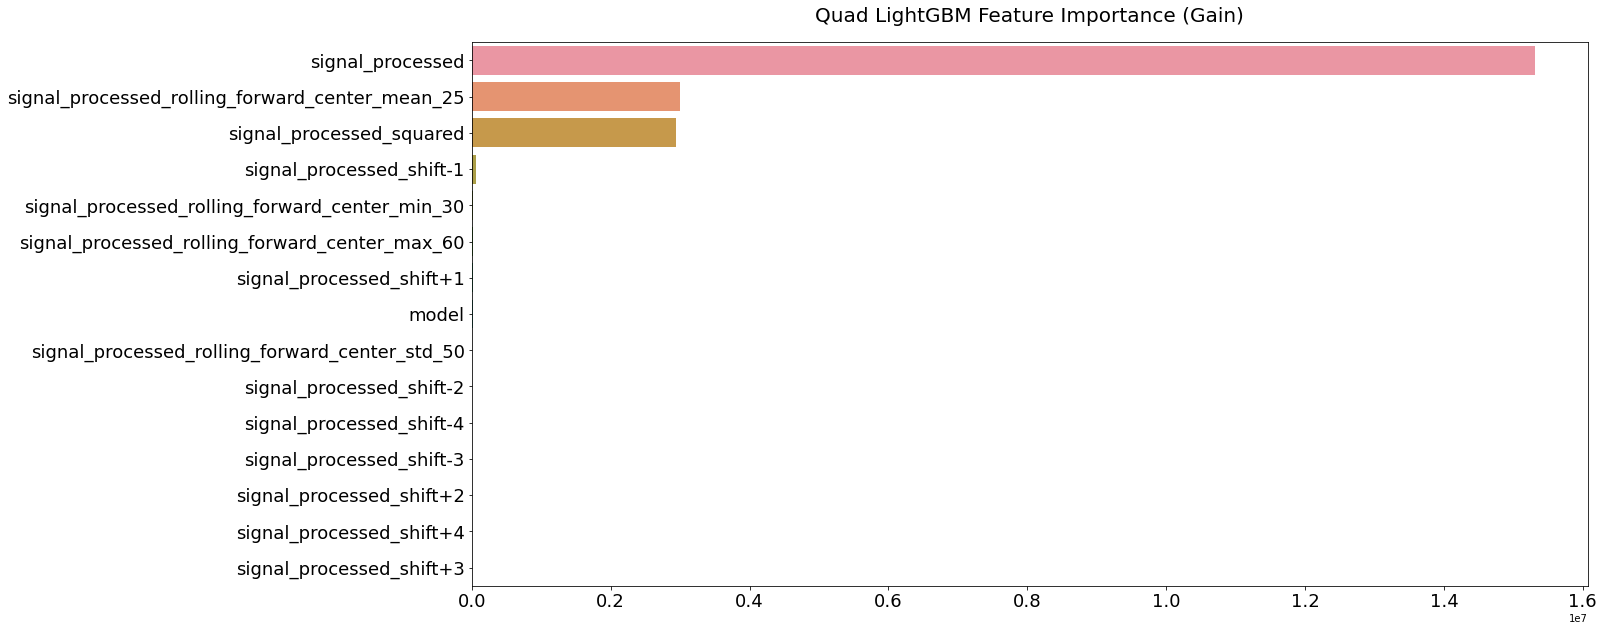

In [19]:
#################### QUAD MODEL 0-1-2-3 ####################

print('#################### QUAD MODEL 0-1-2-3 ####################')
print('------------------------------------------------------------')

K = 2
skf = StratifiedKFold(n_splits=K)

########## QUAD MODEL 0-1-2-3 LGB ##########

print(f'\n########## Running Quad LightGBM Model 0-1-2-3 ##########')

model0123_lgb_features = ['signal_processed', 'model']
model0123_lgb_X_train = df_train[(df_train['model'] <= 3) & (df_train['is_filtered'] == 0)][model0123_lgb_features].copy(deep=True)
model0123_lgb_y_train = df_train[(df_train['model'] <= 3) & (df_train['is_filtered'] == 0)]['open_channels'].copy(deep=True)
model0123_lgb_X_test = df_test[df_test['model'] <= 3][model0123_lgb_features].copy(deep=True)

for df in [model0123_lgb_X_train, model0123_lgb_X_test]:
    for shift in range(1, 5):
        df[f'signal_processed_shift+{shift}'] = df.groupby('model')['signal_processed'].shift(shift)
        df[f'signal_processed_shift-{shift}'] = df.groupby('model')['signal_processed'].shift(-shift)
    df['signal_processed_squared'] = df['signal_processed'] ** 2
    df['signal_processed_rolling_forward_center_mean_25'] = df.groupby('model')['signal_processed'].rolling(window=25, min_periods=1, center=True).mean().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_min_30'] = df.groupby('model')['signal_processed'].rolling(window=30, min_periods=1, center=True).min().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_std_50'] = df.groupby('model')['signal_processed'].rolling(window=50, min_periods=1, center=True).std().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_max_60'] = df.groupby('model')['signal_processed'].rolling(window=60, min_periods=1, center=True).max().reset_index(level='model')['signal_processed']

model0123_lgb_parameters = {
    'num_iterations': 400,
    'early_stopping_round': 100,
    'num_leaves': 2 ** 7, 
    'learning_rate': 0.1,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.9,
    'feature_fraction_bynode': 0.9,
    'min_data_in_leaf': 20,
    'lambda_l1': 0,
    'lambda_l2': 0,
    'max_depth': -1,
    'objective': 'regression',
    'seed': LGB_SEED,
    'feature_fraction_seed': LGB_SEED,
    'bagging_seed': LGB_SEED,
    'drop_seed': LGB_SEED,
    'data_random_seed': LGB_SEED,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric': 'rmse',
    'n_jobs': -1,
}

model0123_lgb_scores = []
model0123_lgb_oof = np.zeros(model0123_lgb_X_train.shape[0])
model0123_lgb_y_pred = pd.DataFrame(np.zeros((model0123_lgb_X_test.shape[0], K)), columns=[f'Fold_{i}_Predictions' for i in range(1, K + 1)]) 
model0123_lgb_importance = pd.DataFrame(np.zeros((model0123_lgb_X_train.shape[1], K)), columns=[f'Fold_{i}_Importance' for i in range(1, K + 1)], index=model0123_lgb_X_train.columns)

for fold, (trn_idx, val_idx) in enumerate(skf.split(model0123_lgb_X_train, model0123_lgb_X_train['model']), 1):
    print(f'\nFold {fold}')

    model0123_lgb_trn_data = lgb.Dataset(model0123_lgb_X_train.iloc[trn_idx, :], label=model0123_lgb_y_train.iloc[trn_idx])
    model0123_lgb_val_data = lgb.Dataset(model0123_lgb_X_train.iloc[val_idx, :], label=model0123_lgb_y_train.iloc[val_idx])  

    model0123_lgb_model = lgb.train(model0123_lgb_parameters, model0123_lgb_trn_data, valid_sets=[model0123_lgb_trn_data, model0123_lgb_val_data], verbose_eval=50)

    model0123_lgb_oof_predictions = model0123_lgb_model.predict(model0123_lgb_X_train.iloc[val_idx, :], num_iteration=model0123_lgb_model.best_iteration)
    model0123_lgb_oof[val_idx] = model0123_lgb_oof_predictions
    df_train.loc[model0123_lgb_X_train.iloc[val_idx, :].index, 'lgb_quad_model_oof'] = model0123_lgb_oof_predictions

    model0123_lgb_test_predictions = model0123_lgb_model.predict(model0123_lgb_X_test, num_iteration=model0123_lgb_model.best_iteration)
    model0123_lgb_y_pred.iloc[:, fold - 1] = model0123_lgb_test_predictions
    df_test.loc[model0123_lgb_X_test.index, f'fold{fold}_lgb_quad_model_predictions'] = model0123_lgb_test_predictions

    model0123_lgb_importance.iloc[:, fold - 1] = model0123_lgb_model.feature_importance(importance_type='gain')
    model0123_lgb_score = f1_score(model0123_lgb_y_train.iloc[val_idx].values, np.round(np.clip(model0123_lgb_oof_predictions, model0123_lgb_y_train.min(), model0123_lgb_y_train.max())), average='macro')
    model0123_lgb_scores.append(model0123_lgb_score)            
    print('\nQuad LGB Fold {} Macro F1-Score {}\n'.format(fold, model0123_lgb_score))

print('--------------------')
print(f'Quad LGB Mean Macro F1-Score {np.mean(model0123_lgb_scores):.6} [STD:{np.std(model0123_lgb_scores):.6}]')
for model in [0, 1, 2, 3]:
    model_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'lgb_quad_model_oof']
    model_labels = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'open_channels']
    print(f'Quad LGB Model {model} OOF (Rounded) Macro F1-Score {f1_score(model_labels, np.round(np.clip(model_oof, model0123_lgb_y_train.min(), model0123_lgb_y_train.max())), average="macro"):.6}')
print(f'Quad LGB Model 0-1-2-3 OOF (Rounded) Macro F1-Score {f1_score(model0123_lgb_y_train, np.round(np.clip(model0123_lgb_oof, model0123_lgb_y_train.min(), model0123_lgb_y_train.max())), average="macro"):.6}')
print('--------------------')

plt.figure(figsize=(20, 10))

model0123_lgb_importance['Mean_Importance'] = model0123_lgb_importance.sum(axis=1) / K
model0123_lgb_importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)
sns.barplot(x='Mean_Importance', y=model0123_lgb_importance.index, data=model0123_lgb_importance)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Quad LightGBM Feature Importance (Gain)', size=20, pad=20)

plt.show()

del model0123_lgb_X_train, model0123_lgb_y_train, model0123_lgb_X_test, model0123_lgb_parameters
del model0123_lgb_scores, model0123_lgb_oof, model0123_lgb_y_pred, model0123_lgb_importance
del model0123_lgb_trn_data, model0123_lgb_val_data, model0123_lgb_model, model0123_lgb_oof_predictions, model0123_lgb_test_predictions

### **6.2. Quad Model XGBoost**

#################### QUAD MODEL 0-1-2-3 ####################
------------------------------------------------------------

########## Running Quad XGBoost Model 0-1-2-3 ##########

Fold 1
[0]	train-rmse:1.70285	val-rmse:1.70772
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 25 rounds.
[50]	train-rmse:0.08242	val-rmse:0.08021
[100]	train-rmse:0.08113	val-rmse:0.07952
[150]	train-rmse:0.08074	val-rmse:0.07948
[200]	train-rmse:0.08043	val-rmse:0.07945
[250]	train-rmse:0.08010	val-rmse:0.07944
Stopping. Best iteration:
[241]	train-rmse:0.08013	val-rmse:0.07944


Quad XGB Fold 1 Macro F1-Score 0.9882583283810016


Fold 2
[0]	train-rmse:1.70781	val-rmse:1.70294
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 25 rounds.
[50]	train-rmse:0.07923	val-rmse:0.08389
[100]	train-rmse:0.07799	val-rmse:0.08299
[150]	train-rmse:0.07759	val-

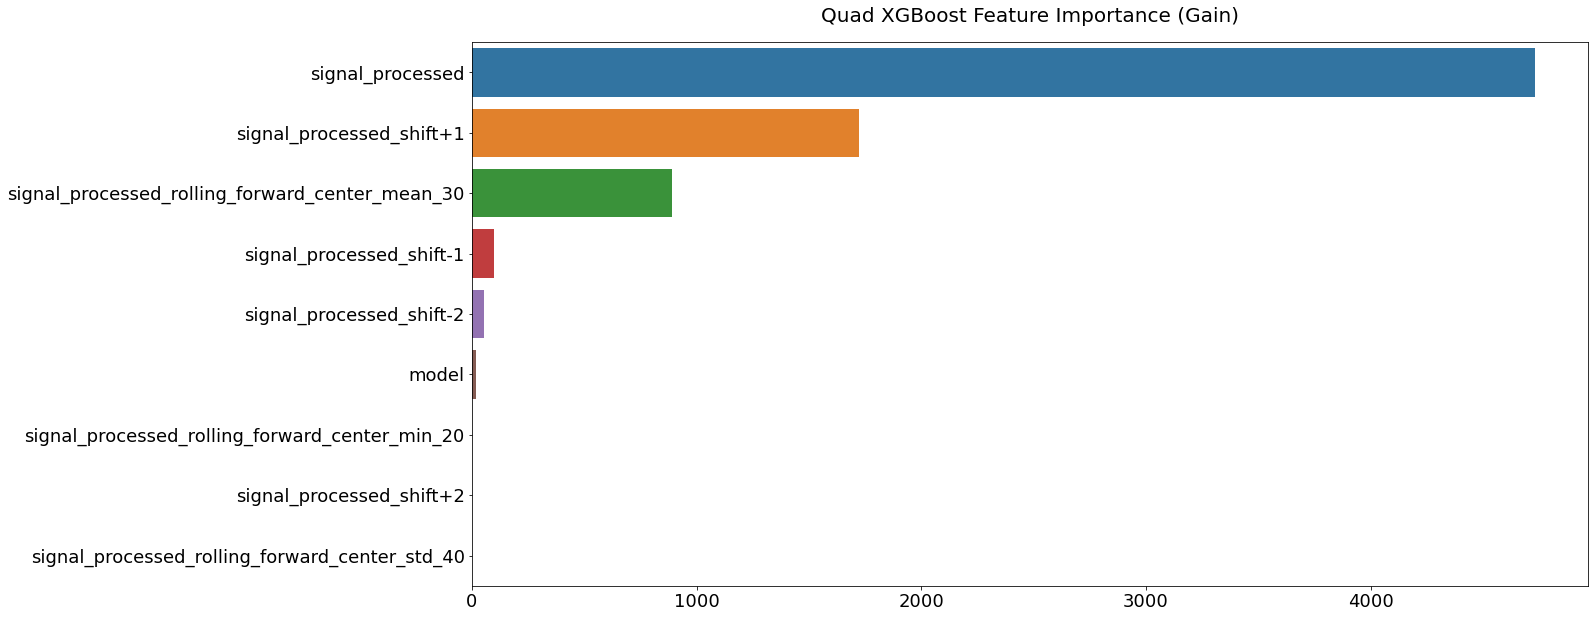

In [20]:
#################### QUAD MODEL 0-1-2-3 ####################

print('#################### QUAD MODEL 0-1-2-3 ####################')
print('------------------------------------------------------------')

K = 2
skf = StratifiedKFold(n_splits=K)

########## QUAD MODEL 0-1-2-3 XGB ##########

print(f'\n########## Running Quad XGBoost Model 0-1-2-3 ##########')

model0123_xgb_features = ['signal_processed', 'model']
model0123_xgb_X_train = df_train[(df_train['model'] <= 3) & (df_train['is_filtered'] == 0)][model0123_xgb_features].copy(deep=True)
model0123_xgb_y_train = df_train[(df_train['model'] <= 3) & (df_train['is_filtered'] == 0)]['open_channels'].copy(deep=True)
model0123_xgb_X_test = df_test[df_test['model'] <= 3][model0123_xgb_features].copy(deep=True)

for df in [model0123_xgb_X_train, model0123_xgb_X_test]:
    for shift in range(1, 3):
        df[f'signal_processed_shift+{shift}'] = df.groupby('model')['signal_processed'].shift(shift)
        df[f'signal_processed_shift-{shift}'] = df.groupby('model')['signal_processed'].shift(-shift)
    df['signal_processed_rolling_forward_center_mean_30'] = df.groupby('model')['signal_processed'].rolling(window=30, min_periods=1, center=True).mean().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_min_20'] = df.groupby('model')['signal_processed'].rolling(window=20, min_periods=1, center=True).min().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_std_40'] = df.groupby('model')['signal_processed'].rolling(window=40, min_periods=1, center=True).std().reset_index(level='model')['signal_processed']

model0123_xgb_parameters = {
    'n_estimators': 2 ** 8, 
    'learning_rate': 0.1,
    'colsample_bytree': 0.9, 
    'colsample_bylevel': 0.9,
    'colsample_bynode': 0.9,
    'sumbsample': 0.8,
    'max_depth': 6,
    'gamma': 0,
    'min_child_weight': 1,
    'lambda': 1,
    'alpha': 0,
    'objective': 'reg:squarederror',
    'seed': XGB_SEED,
    'boosting_type': 'gbtree',
    'tree_method': 'auto',
    'silent': True,
    'verbose': 1,
    'n_jobs': -1,
}

model0123_xgb_scores = []
model0123_xgb_oof = np.zeros(model0123_xgb_X_train.shape[0])
model0123_xgb_y_pred = pd.DataFrame(np.zeros((model0123_xgb_X_test.shape[0], K)), columns=[f'Fold_{i}_Predictions' for i in range(1, K + 1)]) 
model0123_xgb_importance = pd.DataFrame(np.zeros((model0123_xgb_X_train.shape[1], K)), columns=[f'Fold_{i}_Importance' for i in range(1, K + 1)], index=model0123_xgb_X_train.columns)

for fold, (trn_idx, val_idx) in enumerate(skf.split(model0123_xgb_X_train, model0123_xgb_X_train['model']), 1):
    print(f'\nFold {fold}')

    model0123_xgb_trn_data = xgb.DMatrix(model0123_xgb_X_train.iloc[trn_idx, :], label=model0123_xgb_y_train.iloc[trn_idx])
    model0123_xgb_val_data = xgb.DMatrix(model0123_xgb_X_train.iloc[val_idx, :], label=model0123_xgb_y_train.iloc[val_idx])

    model0123_xgb_model = xgb.train(model0123_xgb_parameters, model0123_xgb_trn_data, 500, evals=[(model0123_xgb_trn_data, 'train'), (model0123_xgb_val_data, 'val')], verbose_eval=50, early_stopping_rounds=25)

    model0123_xgb_oof_predictions = model0123_xgb_model.predict(xgb.DMatrix(model0123_xgb_X_train.iloc[val_idx, :]))
    model0123_xgb_oof[val_idx] = model0123_xgb_oof_predictions
    df_train.loc[model0123_xgb_X_train.iloc[val_idx, :].index, 'xgb_quad_model_oof'] = model0123_xgb_oof_predictions

    model0123_xgb_test_predictions = model0123_xgb_model.predict(xgb.DMatrix(model0123_xgb_X_test))
    model0123_xgb_y_pred.iloc[:, fold - 1] = model0123_xgb_test_predictions
    df_test.loc[model0123_xgb_X_test.index, f'fold{fold}_xgb_quad_model_predictions'] = model0123_xgb_test_predictions

    model0123_xgb_importance.iloc[:, fold - 1] = list(model0123_xgb_model.get_score(importance_type='gain').values())
    model0123_xgb_score = f1_score(model0123_xgb_y_train.iloc[val_idx].values, np.round(np.clip(model0123_xgb_oof_predictions, model0123_xgb_y_train.min(), model0123_xgb_y_train.max())), average='macro')
    model0123_xgb_scores.append(model0123_xgb_score)            
    print('\nQuad XGB Fold {} Macro F1-Score {}\n'.format(fold, model0123_xgb_score))

print('--------------------')
print(f'Quad XGB Mean Macro F1-Score {np.mean(model0123_xgb_scores):.6} [STD:{np.std(model0123_xgb_scores):.6}]')
for model in [0, 1, 2, 3]:
    model_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'xgb_quad_model_oof']
    model_labels = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'open_channels']
    print(f'Quad XGB Model {model} OOF (Rounded) Macro F1-Score {f1_score(model_labels, np.round(np.clip(model_oof, model0123_xgb_y_train.min(), model0123_xgb_y_train.max())), average="macro"):.6}')
print(f'Quad XGB Model 0-1-2-3 OOF (Rounded) Macro F1-Score {f1_score(model0123_xgb_y_train, np.round(np.clip(model0123_xgb_oof, model0123_xgb_y_train.min(), model0123_xgb_y_train.max())), average="macro"):.6}')
print('--------------------')

plt.figure(figsize=(20, 10))

model0123_xgb_importance['Mean_Importance'] = model0123_xgb_importance.sum(axis=1) / K
model0123_xgb_importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)
sns.barplot(x='Mean_Importance', y=model0123_xgb_importance.index, data=model0123_xgb_importance)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Quad XGBoost Feature Importance (Gain)', size=20, pad=20)

plt.show()

del model0123_xgb_X_train, model0123_xgb_y_train, model0123_xgb_X_test, model0123_xgb_parameters
del model0123_xgb_scores, model0123_xgb_oof, model0123_xgb_y_pred, model0123_xgb_importance
del model0123_xgb_trn_data, model0123_xgb_val_data, model0123_xgb_model, model0123_xgb_oof_predictions, model0123_xgb_test_predictions

### **6.3. Quad Model CatBoost**

#################### QUAD MODEL 0-1-2-3 ####################
------------------------------------------------------------

########## Running Quad CatBoost Model 0-1-2-3 ##########

Fold 1
0:	learn: 1.4010762	total: 747ms	remaining: 12m 25s
50:	learn: 0.0971793	total: 33s	remaining: 10m 14s
100:	learn: 0.0873009	total: 1m 3s	remaining: 9m 25s
150:	learn: 0.0846955	total: 1m 35s	remaining: 8m 54s
200:	learn: 0.0835084	total: 2m 5s	remaining: 8m 18s
250:	learn: 0.0828802	total: 2m 36s	remaining: 7m 46s
300:	learn: 0.0824453	total: 3m 7s	remaining: 7m 15s
350:	learn: 0.0821434	total: 3m 39s	remaining: 6m 45s
400:	learn: 0.0818872	total: 4m 10s	remaining: 6m 13s
450:	learn: 0.0816302	total: 4m 42s	remaining: 5m 43s
500:	learn: 0.0813962	total: 5m 14s	remaining: 5m 13s
550:	learn: 0.0811927	total: 5m 45s	remaining: 4m 41s
600:	learn: 0.0810152	total: 6m 16s	remaining: 4m 10s
650:	learn: 0.0808455	total: 6m 48s	remaining: 3m 39s
700:	learn: 0.0806682	total: 7m 19s	remaining: 3m 7s
750:	learn

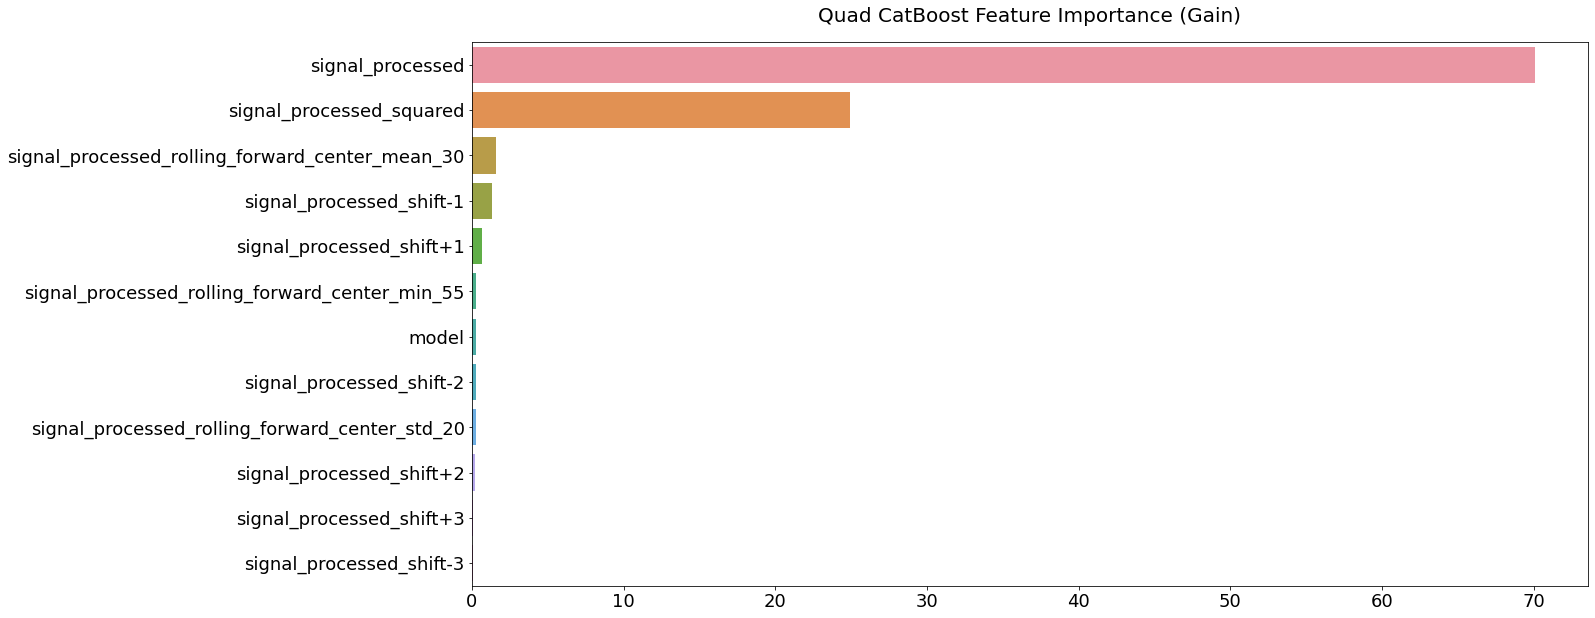

In [21]:
#################### QUAD MODEL 0-1-2-3 ####################

print('#################### QUAD MODEL 0-1-2-3 ####################')
print('------------------------------------------------------------')

K = 2
skf = StratifiedKFold(n_splits=K)

########## QUAD MODEL 0-1-2-3 CB ##########

print(f'\n########## Running Quad CatBoost Model 0-1-2-3 ##########')

model0123_cb_features = ['signal_processed', 'model']
model0123_cb_X_train = df_train[(df_train['model'] <= 3) & (df_train['is_filtered'] == 0)][model0123_cb_features].copy(deep=True)
model0123_cb_y_train = df_train[(df_train['model'] <= 3) & (df_train['is_filtered'] == 0)]['open_channels'].copy(deep=True)
model0123_cb_X_test = df_test[df_test['model'] <= 3][model0123_cb_features].copy(deep=True)

for df in [model0123_cb_X_train, model0123_cb_X_test]:
    for shift in range(1, 4):
        df[f'signal_processed_shift+{shift}'] = df.groupby('model')['signal_processed'].shift(shift)
        df[f'signal_processed_shift-{shift}'] = df.groupby('model')['signal_processed'].shift(-shift)
    df['signal_processed_squared'] = df['signal_processed'] ** 2
    df['signal_processed_rolling_forward_center_mean_30'] = df.groupby('model')['signal_processed'].rolling(window=30, min_periods=1, center=True).mean().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_std_20'] = df.groupby('model')['signal_processed'].rolling(window=20, min_periods=1, center=True).std().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_min_55'] = df.groupby('model')['signal_processed'].rolling(window=55, min_periods=1, center=True).min().reset_index(level='model')['signal_processed']

model0123_cb_parameters = {
    'n_estimators': 1000, 
    'learning_rate': 0.09,
    'depth': 7,
    'subsample': 0.8,
    'bagging_temperature': 1,
    'colsample_bylevel': 0.9,
    'l2_leaf_reg': 0,
    'metric_period': 50,
    'boost_from_average': True,
    'eval_metric': 'RMSE',
    'loss_function': 'RMSE',    
    'random_seed': CB_SEED,
    'verbose': 1,
}

model0123_cb_scores = []
model0123_cb_oof = np.zeros(model0123_cb_X_train.shape[0])
model0123_cb_y_pred = pd.DataFrame(np.zeros((model0123_cb_X_test.shape[0], K)), columns=[f'Fold_{i}_Predictions' for i in range(1, K + 1)]) 
model0123_cb_importance = pd.DataFrame(np.zeros((model0123_cb_X_train.shape[1], K)), columns=[f'Fold_{i}_Importance' for i in range(1, K + 1)], index=model0123_cb_X_train.columns)

for fold, (trn_idx, val_idx) in enumerate(skf.split(model0123_cb_X_train, model0123_cb_X_train['model']), 1):
    print(f'\nFold {fold}')

    model0123_cb_trn_data = cb.Pool(model0123_cb_X_train.iloc[trn_idx, :], label=model0123_cb_y_train.iloc[trn_idx], cat_features=[1]) 
    model0123_cb_val_data = cb.Pool(model0123_cb_X_train.iloc[val_idx, :], label=model0123_cb_y_train.iloc[val_idx], cat_features=[1])            
    model0123_cb_model = cb.CatBoostRegressor(**model0123_cb_parameters)
    model0123_cb_model.fit(model0123_cb_trn_data)

    model0123_cb_oof_predictions = model0123_cb_model.predict(model0123_cb_val_data)
    model0123_cb_oof[val_idx] = model0123_cb_oof_predictions
    df_train.loc[model0123_cb_X_train.iloc[val_idx, :].index, 'cb_quad_model_oof'] = model0123_cb_oof_predictions

    model0123_cb_test_predictions = model0123_cb_model.predict(cb.Pool(model0123_cb_X_test, cat_features=[1]))
    model0123_cb_y_pred.iloc[:, fold - 1] = model0123_cb_test_predictions
    df_test.loc[model0123_cb_X_test.index, f'fold{fold}_cb_quad_model_predictions'] = model0123_cb_test_predictions

    model0123_cb_importance.iloc[:, fold - 1] = model0123_cb_model.get_feature_importance()
    model0123_cb_score = f1_score(model0123_cb_y_train.iloc[val_idx].values, np.round(np.clip(model0123_cb_oof_predictions, model0123_cb_y_train.min(), model0123_cb_y_train.max())), average='macro')
    model0123_cb_scores.append(model0123_cb_score)   
    print('\nQuad CB Fold {} Macro F1-Score {}\n'.format(fold, model0123_cb_score))

print('--------------------')
print(f'Quad CB Mean Macro F1-Score {np.mean(model0123_cb_scores):.6} [STD:{np.std(model0123_cb_scores):.6}]')
for model in [0, 1, 2, 3]:
    model_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'cb_quad_model_oof']
    model_labels = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'open_channels']
    print(f'Quad CB Model {model} OOF (Rounded) Macro F1-Score {f1_score(model_labels, np.round(np.clip(model_oof, model0123_cb_y_train.min(), model0123_cb_y_train.max())), average="macro"):.6}')
print(f'Quad CB Model 0-1-2-3 OOF (Rounded) Macro F1-Score {f1_score(model0123_cb_y_train, np.round(np.clip(model0123_cb_oof, model0123_cb_y_train.min(), model0123_cb_y_train.max())), average="macro"):.6}')
print('--------------------')

plt.figure(figsize=(20, 10))

model0123_cb_importance['Mean_Importance'] = model0123_cb_importance.sum(axis=1) / K
model0123_cb_importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)
sns.barplot(x='Mean_Importance', y=model0123_cb_importance.index, data=model0123_cb_importance)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Quad CatBoost Feature Importance (Gain)', size=20, pad=20)

plt.show()

del model0123_cb_X_train, model0123_cb_y_train, model0123_cb_X_test, model0123_cb_parameters
del model0123_cb_scores, model0123_cb_oof, model0123_cb_y_pred, model0123_cb_importance
del model0123_cb_trn_data, model0123_cb_val_data, model0123_cb_model, model0123_cb_oof_predictions, model0123_cb_test_predictions

### **6.4. Quad Model Evaluation**

In [22]:
print('#################### QUAD MODEL EVALUATION ####################')
print('---------------------------------------------------------------')

for model in range(4):
    print(f'\n########## Quad Model {model} ##########')
    print('----------------------------------')
    
    y_true = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'open_channels']
    lgb_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'lgb_quad_model_oof']
    xgb_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'xgb_quad_model_oof']
    cb_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'cb_quad_model_oof']
    equal_blend_oof = (lgb_oof * 0.34) + (xgb_oof * 0.33) + (cb_oof * 0.33)
    
    print(f'Quad LGB Model {model} OOF (Rounded) Macro F1-Score {f1_score(y_true, np.round(np.clip(lgb_oof, y_true.min(), y_true.max())), average="macro"):.6}')
    print(f'Quad XGB Model {model} OOF (Rounded) Macro F1-Score {f1_score(y_true, np.round(np.clip(xgb_oof, y_true.min(), y_true.max())), average="macro"):.6}')
    print(f'Quad CB Model {model} OOF (Rounded) Macro F1-Score {f1_score(y_true, np.round(np.clip(cb_oof, y_true.min(), y_true.max())), average="macro"):.6}')
    print(f'Quad Model {model} Equal Blend OOF (Rounded) Macro F1-Score {f1_score(y_true, np.round(np.clip(equal_blend_oof, y_true.min(), y_true.max())), average="macro"):.6}')
    
print(f'\n########## Quad Model Global ##########')
print('---------------------------------------')

global_y_true = df_train.loc[(df_train['is_filtered'] == 0) & (df_train['model'] <= 3), 'open_channels']
global_lgb_oof = df_train.loc[(df_train['is_filtered'] == 0) & (df_train['model'] <= 3), 'lgb_quad_model_oof']
global_xgb_oof = df_train.loc[(df_train['is_filtered'] == 0) & (df_train['model'] <= 3), 'xgb_quad_model_oof']
global_cb_oof = df_train.loc[(df_train['is_filtered'] == 0) & (df_train['model'] <= 3), 'cb_quad_model_oof']
global_equal_blend_oof = (global_lgb_oof * 0.34) + (global_xgb_oof * 0.33) + (global_cb_oof * 0.33)

print(f'Quad LGB Model Global (0-1-2-3) OOF (Rounded) Macro F1-Score {f1_score(global_y_true, np.round(np.clip(global_lgb_oof, global_y_true.min(), global_y_true.max())), average="macro"):.6}')
print(f'Quad XGB Model Global (0-1-2-3) OOF (Rounded) Macro F1-Score {f1_score(global_y_true, np.round(np.clip(global_xgb_oof, global_y_true.min(), global_y_true.max())), average="macro"):.6}')
print(f'Quad CB Model Global (0-1-2-3) OOF (Rounded) Macro F1-Score {f1_score(global_y_true, np.round(np.clip(global_cb_oof, global_y_true.min(), global_y_true.max())), average="macro"):.6}')
print(f'Quad Model Global (0-1-2-3) Equal Blend OOF (Rounded) Macro F1-Score {f1_score(global_y_true, np.round(np.clip(global_equal_blend_oof, global_y_true.min(), global_y_true.max())), average="macro"):.6}')

del global_y_true, global_lgb_oof, global_xgb_oof, global_cb_oof, global_equal_blend_oof

#################### QUAD MODEL EVALUATION ####################
---------------------------------------------------------------

########## Quad Model 0 ##########
----------------------------------
Quad LGB Model 0 OOF (Rounded) Macro F1-Score 0.997376
Quad XGB Model 0 OOF (Rounded) Macro F1-Score 0.99723
Quad CB Model 0 OOF (Rounded) Macro F1-Score 0.997472
Quad Model 0 Equal Blend OOF (Rounded) Macro F1-Score 0.997523

########## Quad Model 1 ##########
----------------------------------
Quad LGB Model 1 OOF (Rounded) Macro F1-Score 0.997146
Quad XGB Model 1 OOF (Rounded) Macro F1-Score 0.99714
Quad CB Model 1 OOF (Rounded) Macro F1-Score 0.997175
Quad Model 1 Equal Blend OOF (Rounded) Macro F1-Score 0.997201

########## Quad Model 2 ##########
----------------------------------
Quad LGB Model 2 OOF (Rounded) Macro F1-Score 0.985349
Quad XGB Model 2 OOF (Rounded) Macro F1-Score 0.985352
Quad CB Model 2 OOF (Rounded) Macro F1-Score 0.98524
Quad Model 2 Equal Blend OOF (Rounded) Macro

## **7. Penta Models**

Penta models are trained on the whole dataset so they contain all different distributions. The objective of penta models is maximizing the F1 score calculated on the whole dataset, so feature selection is done based on that objective. Penta models are performing way better than Solo Model 4 since they contain all different distributions. Their weights in blends are higher than solo models.

### **7.1. Penta Model LightGBM**

#################### PENTA MODEL 0-1-2-3-4 ####################
---------------------------------------------------------------

########## Running Penta LightGBM Model 0-1-2-3-4 ##########

Fold 1
Training until validation scores don't improve for 150 rounds
[50]	training's rmse: 0.775504	valid_1's rmse: 0.778911
[100]	training's rmse: 0.259961	valid_1's rmse: 0.260346
[150]	training's rmse: 0.157645	valid_1's rmse: 0.15771
[200]	training's rmse: 0.145919	valid_1's rmse: 0.146458
[250]	training's rmse: 0.144525	valid_1's rmse: 0.145518
[300]	training's rmse: 0.144078	valid_1's rmse: 0.145436
[350]	training's rmse: 0.143732	valid_1's rmse: 0.145423
[400]	training's rmse: 0.143426	valid_1's rmse: 0.145415
[450]	training's rmse: 0.143125	valid_1's rmse: 0.145409
[500]	training's rmse: 0.14284	valid_1's rmse: 0.14541
[550]	training's rmse: 0.142547	valid_1's rmse: 0.145409
[600]	training's rmse: 0.142264	valid_1's rmse: 0.14541
[650]	training's rmse: 0.141991	valid_1's rmse: 0.14541
Early

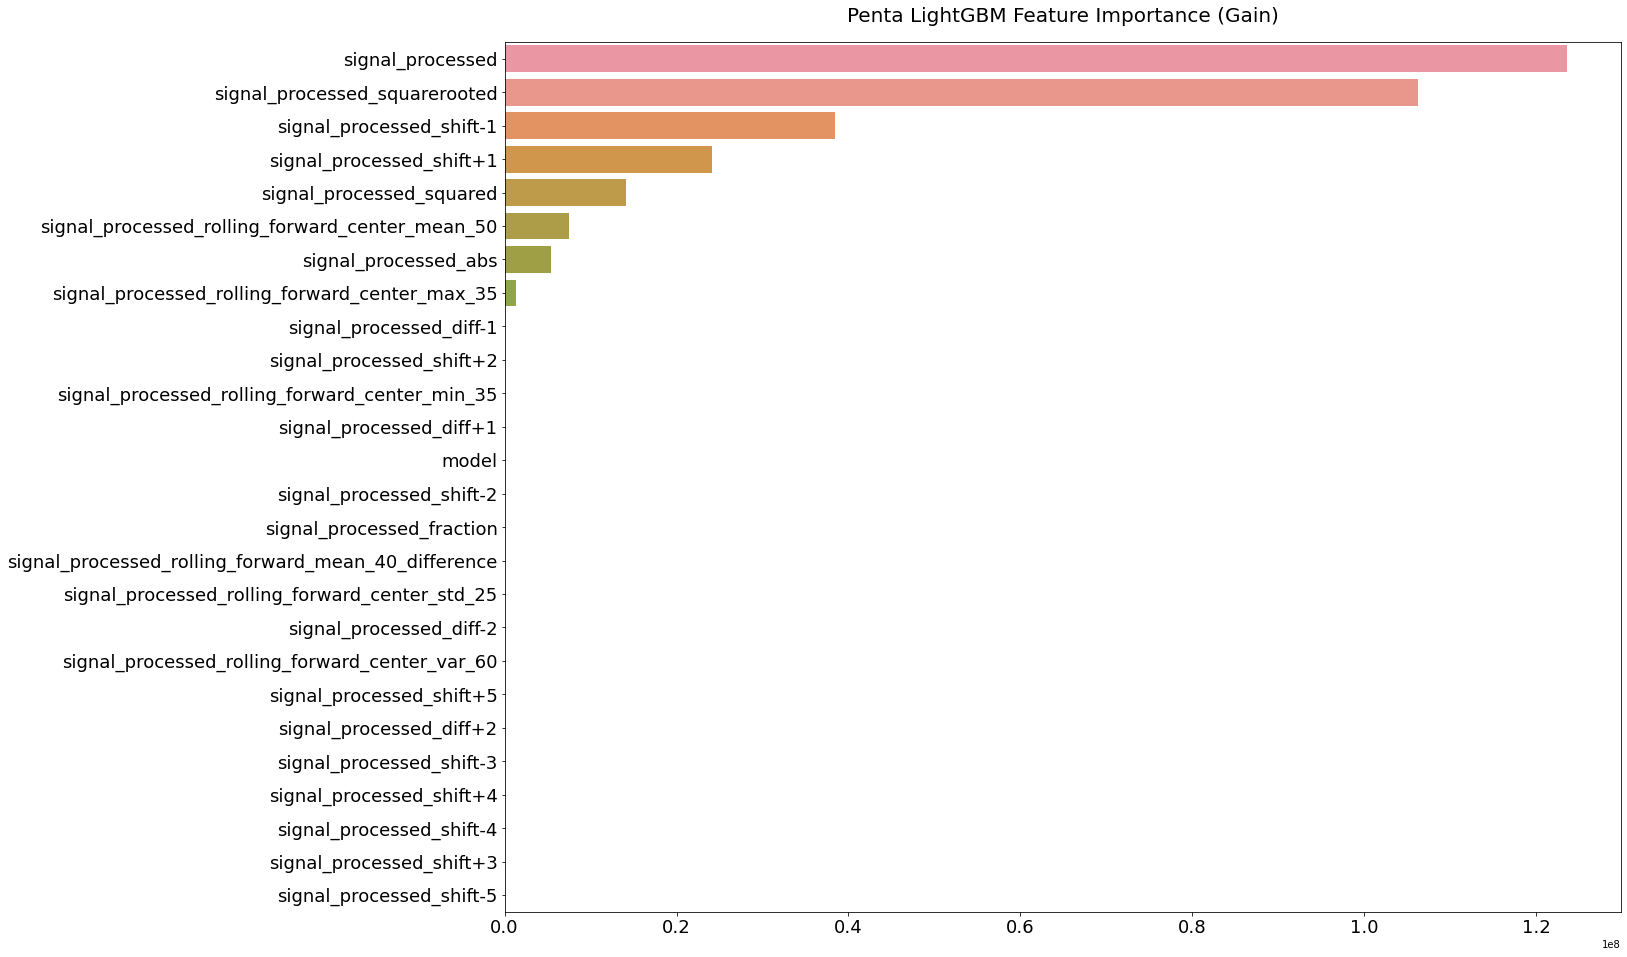

In [23]:
#################### PENTA MODEL 0-1-2-3-4 ####################

print('#################### PENTA MODEL 0-1-2-3-4 ####################')
print('---------------------------------------------------------------')
    
K = 2
skf = StratifiedKFold(n_splits=K)

########## PENTA MODEL 0-1-2-3-4 LGB ##########

print(f'\n########## Running Penta LightGBM Model 0-1-2-3-4 ##########')

model01234_lgb_features = ['signal_processed', 'model']
model01234_lgb_X_train = df_train[df_train['is_filtered'] == 0][model01234_lgb_features].copy(deep=True)
model01234_lgb_y_train = df_train[df_train['is_filtered'] == 0]['open_channels'].copy(deep=True)
model01234_lgb_X_test = df_test[df_train['is_filtered'] == 0][model01234_lgb_features].copy(deep=True)

for df in [model01234_lgb_X_train, model01234_lgb_X_test]:
    for shift in range(1, 6):
        df[f'signal_processed_shift+{shift}'] = df.groupby('model')['signal_processed'].shift(shift)
        df[f'signal_processed_shift-{shift}'] = df.groupby('model')['signal_processed'].shift(-shift)
    for diff in range(1, 3):
        df[f'signal_processed_diff+{diff}'] = df.groupby('model')['signal_processed'].diff(diff)
        df[f'signal_processed_diff-{diff}'] = df.groupby('model')['signal_processed'].diff(-diff)
    df['signal_processed_squared'] = df['signal_processed'] ** 2
    df['signal_processed_squarerooted'] = df['signal_processed'] ** (1 / 2)
    df['signal_processed_abs'] = np.abs(df['signal_processed'])
    df['signal_processed_fraction'] = np.abs(df['signal_processed'] - df['signal_processed'].astype(int))
    df['signal_processed_rolling_forward_center_mean_50'] = df.groupby('model')['signal_processed'].rolling(window=50, min_periods=1, center=True).mean().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_std_25'] = df.groupby('model')['signal_processed'].rolling(window=25, min_periods=1, center=True).std().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_min_35'] = df.groupby('model')['signal_processed'].rolling(window=35, min_periods=1, center=True).min().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_max_35'] = df.groupby('model')['signal_processed'].rolling(window=35, min_periods=1, center=True).max().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_var_60'] = df.groupby('model')['signal_processed'].rolling(window=60, min_periods=1, center=True).var().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_mean_40_difference'] = df['signal_processed'] - df.groupby('model')['signal_processed'].rolling(window=40, min_periods=1, center=False).mean().reset_index(level='model')['signal_processed']

model01234_lgb_parameters = {
    'num_iterations': 1500,
    'early_stopping_round': 150,
    'num_leaves': 2 ** 7,
    'learning_rate': 0.025,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'feature_fraction': 0.8,
    'feature_fraction_bynode': 0.6,
    'min_data_in_leaf': 20,
    'lambda_l1': 0,
    'lambda_l2': 0,
    'max_depth': -1,
    'objective': 'regression',
    'seed': LGB_SEED,
    'feature_fraction_seed': LGB_SEED,
    'bagging_seed': LGB_SEED,
    'drop_seed': LGB_SEED,
    'data_random_seed': LGB_SEED,
    'boosting_type': 'gbdt',
    'verbose': 1,
    'metric': 'rmse',
    'n_jobs': -1,
}

model01234_lgb_scores = []
model01234_lgb_oof = np.zeros(model01234_lgb_X_train.shape[0])
model01234_lgb_y_pred = pd.DataFrame(np.zeros((model01234_lgb_X_test.shape[0], K)), columns=[f'Fold_{i}_Predictions' for i in range(1, K + 1)]) 
model01234_lgb_importance = pd.DataFrame(np.zeros((model01234_lgb_X_train.shape[1], K)), columns=[f'Fold_{i}_Importance' for i in range(1, K + 1)], index=model01234_lgb_X_train.columns)

for fold, (trn_idx, val_idx) in enumerate(skf.split(model01234_lgb_X_train, model01234_lgb_X_train['model']), 1):
    print(f'\nFold {fold}')

    model01234_lgb_trn_data = lgb.Dataset(model01234_lgb_X_train.iloc[trn_idx, :], label=model01234_lgb_y_train.iloc[trn_idx], categorical_feature=['model'])
    model01234_lgb_val_data = lgb.Dataset(model01234_lgb_X_train.iloc[val_idx, :], label=model01234_lgb_y_train.iloc[val_idx], categorical_feature=['model'])  

    model01234_lgb_model = lgb.train(model01234_lgb_parameters, model01234_lgb_trn_data, valid_sets=[model01234_lgb_trn_data, model01234_lgb_val_data], verbose_eval=50)

    model01234_lgb_oof_predictions = model01234_lgb_model.predict(model01234_lgb_X_train.iloc[val_idx, :], num_iteration=model01234_lgb_model.best_iteration)
    model01234_lgb_oof[val_idx] = model01234_lgb_oof_predictions
    df_train.loc[model01234_lgb_X_train.iloc[val_idx, :].index, 'lgb_penta_model_oof'] = model01234_lgb_oof_predictions

    model01234_lgb_test_predictions = model01234_lgb_model.predict(model01234_lgb_X_test, num_iteration=model01234_lgb_model.best_iteration)
    model01234_lgb_y_pred.iloc[:, fold - 1] = model01234_lgb_test_predictions
    df_test.loc[model01234_lgb_X_test.index, f'fold{fold}_lgb_penta_model_predictions'] = model01234_lgb_test_predictions

    model01234_lgb_importance.iloc[:, fold - 1] = model01234_lgb_model.feature_importance(importance_type='gain')
    model01234_lgb_score = f1_score(model01234_lgb_y_train.iloc[val_idx].values, np.round(np.clip(model01234_lgb_oof_predictions, model01234_lgb_y_train.min(), model01234_lgb_y_train.max())), average='macro')
    model01234_lgb_scores.append(model01234_lgb_score)            
    print('\nPenta LGB Fold {} Macro F1-Score {}\n'.format(fold, model01234_lgb_score))

print('--------------------')
print(f'Penta LGB Mean Macro F1-Score {np.mean(model01234_lgb_scores):.6} [STD:{np.std(model01234_lgb_scores):.6}]')
for model in [0, 1, 2, 3, 4]:
    model_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'lgb_penta_model_oof']
    model_labels = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'open_channels']
    print(f'Penta LGB Model {model} OOF (Rounded) Macro F1-Score {f1_score(model_labels, np.round(np.clip(model_oof, model01234_lgb_y_train.min(), model01234_lgb_y_train.max())), average="macro"):.6}')
print(f'Penta LGB Model 0-1-2-3-4 OOF (Rounded) Macro F1-Score {f1_score(model01234_lgb_y_train, np.round(np.clip(model01234_lgb_oof, model01234_lgb_y_train.min(), model01234_lgb_y_train.max())), average="macro"):.6}')
print('--------------------')

plt.figure(figsize=(20, 16))

model01234_lgb_importance['Mean_Importance'] = model01234_lgb_importance.sum(axis=1) / K
model01234_lgb_importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)
sns.barplot(x='Mean_Importance', y=model01234_lgb_importance.index, data=model01234_lgb_importance)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Penta LightGBM Feature Importance (Gain)', size=20, pad=20)

plt.show()

del model01234_lgb_X_train, model01234_lgb_y_train, model01234_lgb_X_test, model01234_lgb_parameters
del model01234_lgb_scores, model01234_lgb_oof, model01234_lgb_y_pred, model01234_lgb_importance
del model01234_lgb_trn_data, model01234_lgb_val_data, model01234_lgb_model, model01234_lgb_oof_predictions, model01234_lgb_test_predictions

### **7.2. Penta Model XGBoost**
Penta Model XGBoost is not implemented because it takes too much time to train it on the whole dataset.

### **7.3. Penta Model CatBoost**

#################### PENTA MODEL 0-1-2-3-4 ####################
---------------------------------------------------------------

########## Running Penta CatBoost Model 0-1-2-3-4 ##########

Fold 1
0:	learn: 2.5040829	total: 896ms	remaining: 14m 55s
50:	learn: 0.1784559	total: 41.2s	remaining: 12m 46s
100:	learn: 0.1590726	total: 1m 18s	remaining: 11m 42s
150:	learn: 0.1543662	total: 1m 57s	remaining: 11m 1s
200:	learn: 0.1515791	total: 2m 35s	remaining: 10m 18s
250:	learn: 0.1499730	total: 3m 12s	remaining: 9m 33s
300:	learn: 0.1489829	total: 3m 51s	remaining: 8m 57s
350:	learn: 0.1482827	total: 4m 28s	remaining: 8m 16s
400:	learn: 0.1478431	total: 5m 5s	remaining: 7m 37s
450:	learn: 0.1474715	total: 5m 44s	remaining: 6m 58s
500:	learn: 0.1471519	total: 6m 20s	remaining: 6m 19s
550:	learn: 0.1468835	total: 6m 59s	remaining: 5m 41s
600:	learn: 0.1466625	total: 7m 37s	remaining: 5m 3s
650:	learn: 0.1464539	total: 8m 14s	remaining: 4m 25s
700:	learn: 0.1462680	total: 8m 51s	remaining: 3m

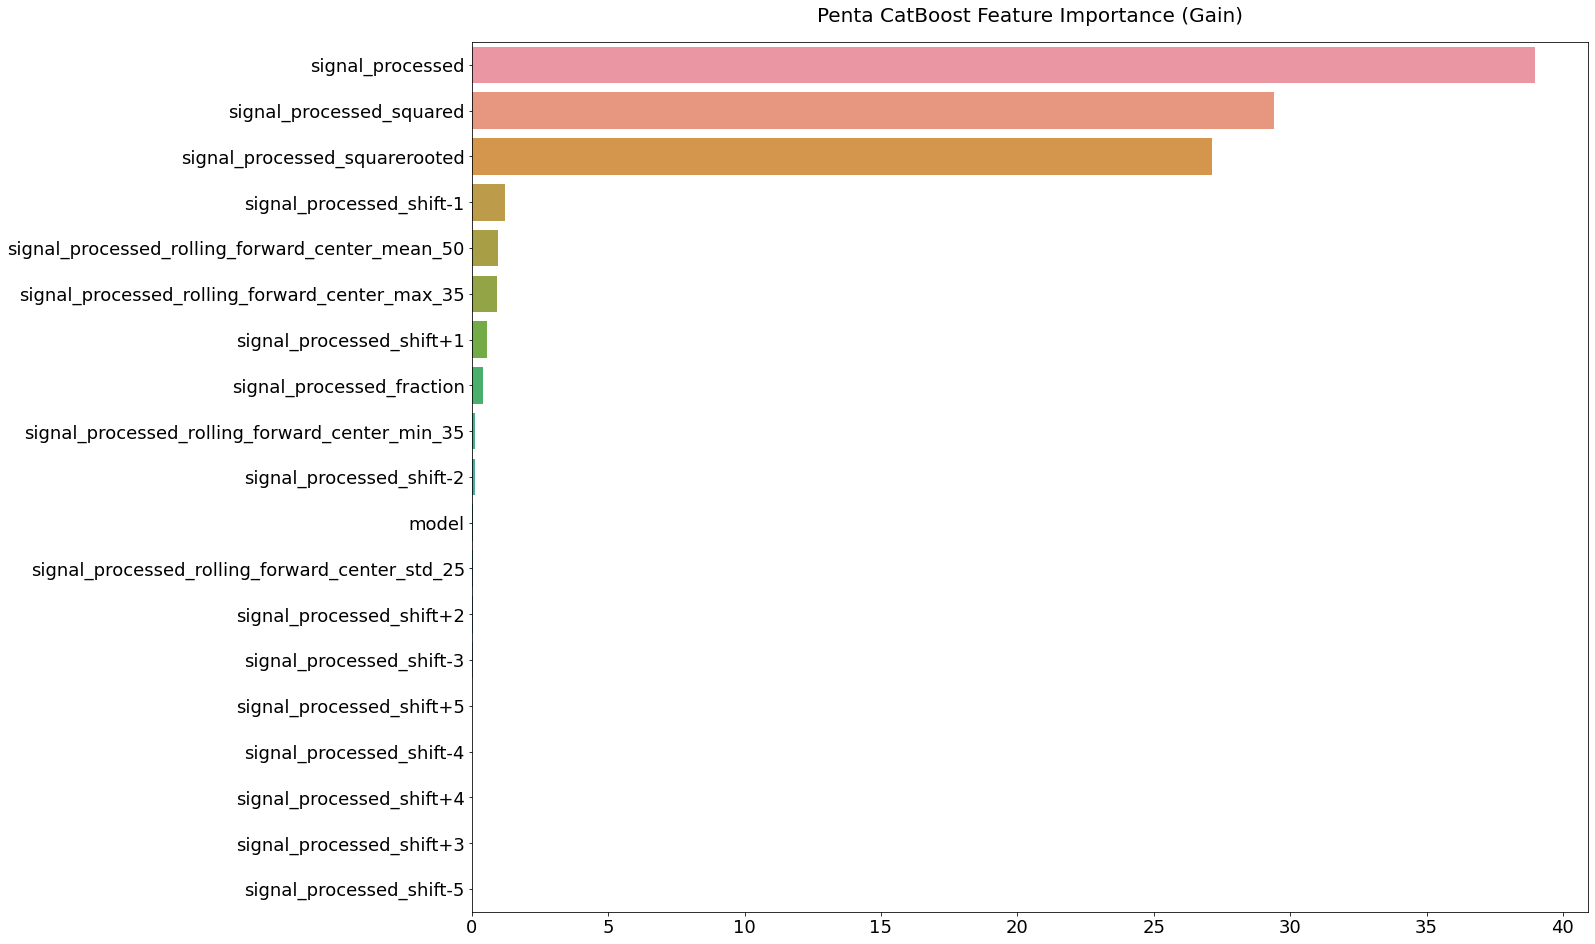

In [24]:
#################### PENTA MODEL 0-1-2-3-4 ####################

print('#################### PENTA MODEL 0-1-2-3-4 ####################')
print('---------------------------------------------------------------')
    
K = 2
skf = StratifiedKFold(n_splits=K)

########## PENTA MODEL 0-1-2-3-4 CB ##########

print(f'\n########## Running Penta CatBoost Model 0-1-2-3-4 ##########')

model01234_cb_features = ['signal_processed', 'model']
model01234_cb_X_train = df_train[df_train['is_filtered'] == 0][model01234_cb_features].copy(deep=True)
model01234_cb_y_train = df_train[df_train['is_filtered'] == 0]['open_channels'].copy(deep=True)
model01234_cb_X_test = df_test[df_train['is_filtered'] == 0][model01234_cb_features].copy(deep=True)

for df in [model01234_cb_X_train, model01234_cb_X_test]:
    for shift in range(1, 6):
        df[f'signal_processed_shift+{shift}'] = df.groupby('model')['signal_processed'].shift(shift)
        df[f'signal_processed_shift-{shift}'] = df.groupby('model')['signal_processed'].shift(-shift)
    df['signal_processed_squared'] = df['signal_processed'] ** 2
    df['signal_processed_squarerooted'] = df['signal_processed'] ** (1 / 2)
    df['signal_processed_fraction'] = np.abs(df['signal_processed'] - df['signal_processed'].astype(int))
    df['signal_processed_rolling_forward_center_mean_50'] = df.groupby('model')['signal_processed'].rolling(window=50, min_periods=1, center=True).mean().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_std_25'] = df.groupby('model')['signal_processed'].rolling(window=25, min_periods=1, center=True).std().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_min_35'] = df.groupby('model')['signal_processed'].rolling(window=35, min_periods=1, center=True).min().reset_index(level='model')['signal_processed']
    df['signal_processed_rolling_forward_center_max_35'] = df.groupby('model')['signal_processed'].rolling(window=35, min_periods=1, center=True).max().reset_index(level='model')['signal_processed']

model01234_cb_parameters = {
    'n_estimators': 1000, 
    'learning_rate': 0.075,
    'depth': 7,
    'subsample': 0.6,
    'bagging_temperature': 1,
    'colsample_bylevel': 0.9,
    'l2_leaf_reg': 0.1,
    'metric_period': 50,
    'boost_from_average': True,
    'eval_metric': 'RMSE',
    'loss_function': 'RMSE',    
    'random_seed': CB_SEED,
    'verbose': 1,
}

model01234_cb_scores = []
model01234_cb_oof = np.zeros(model01234_cb_X_train.shape[0])
model01234_cb_y_pred = pd.DataFrame(np.zeros((model01234_cb_X_test.shape[0], K)), columns=[f'Fold_{i}_Predictions' for i in range(1, K + 1)]) 
model01234_cb_importance = pd.DataFrame(np.zeros((model01234_cb_X_train.shape[1], K)), columns=[f'Fold_{i}_Importance' for i in range(1, K + 1)], index=model01234_cb_X_train.columns)

for fold, (trn_idx, val_idx) in enumerate(skf.split(model01234_cb_X_train, model01234_cb_X_train['model']), 1):
    print(f'\nFold {fold}')

    model01234_cb_trn_data = cb.Pool(model01234_cb_X_train.iloc[trn_idx, :], label=model01234_cb_y_train.iloc[trn_idx], cat_features=[1]) 
    model01234_cb_val_data = cb.Pool(model01234_cb_X_train.iloc[val_idx, :], label=model01234_cb_y_train.iloc[val_idx], cat_features=[1])            
    model01234_cb_model = cb.CatBoostRegressor(**model01234_cb_parameters)
    model01234_cb_model.fit(model01234_cb_trn_data)

    model01234_cb_oof_predictions = model01234_cb_model.predict(model01234_cb_val_data)
    model01234_cb_oof[val_idx] = model01234_cb_oof_predictions
    df_train.loc[model01234_cb_X_train.iloc[val_idx, :].index, 'cb_penta_model_oof'] = model01234_cb_oof_predictions

    model01234_cb_test_predictions = model01234_cb_model.predict(cb.Pool(model01234_cb_X_test, cat_features=[1]))
    model01234_cb_y_pred.iloc[:, fold - 1] = model01234_cb_test_predictions
    df_test.loc[model01234_cb_X_test.index, f'fold{fold}_cb_penta_model_predictions'] = model01234_cb_test_predictions

    model01234_cb_importance.iloc[:, fold - 1] = model01234_cb_model.get_feature_importance()
    model01234_cb_score = f1_score(model01234_cb_y_train.iloc[val_idx].values, np.round(np.clip(model01234_cb_oof_predictions, model01234_cb_y_train.min(), model01234_cb_y_train.max())), average='macro')
    model01234_cb_scores.append(model01234_cb_score)         
    print('\nPenta CB Fold {} Macro F1-Score {}\n'.format(fold, model01234_cb_score))

print('--------------------')
print(f'Penta CB Mean Macro F1-Score {np.mean(model01234_cb_scores):.6} [STD:{np.std(model01234_cb_scores):.6}]')
for model in [0, 1, 2, 3, 4]:
    model_oof = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'cb_penta_model_oof']
    model_labels = df_train.loc[(df_train['model'] == model) & (df_train['is_filtered'] == 0), 'open_channels']
    print(f'Penta CB Model {model} OOF (Rounded) Macro F1-Score {f1_score(model_labels, np.round(np.clip(model_oof, model01234_cb_y_train.min(), model01234_cb_y_train.max())), average="macro"):.6}')
print(f'Penta CB Model 0-1-2-3-4 OOF (Rounded) Macro F1-Score {f1_score(model01234_cb_y_train, np.round(np.clip(model01234_cb_oof, model01234_cb_y_train.min(), model01234_cb_y_train.max())), average="macro"):.6}')
print('--------------------')

plt.figure(figsize=(20, 16))

model01234_cb_importance['Mean_Importance'] = model01234_cb_importance.sum(axis=1) / K
model01234_cb_importance.sort_values(by='Mean_Importance', inplace=True, ascending=False)
sns.barplot(x='Mean_Importance', y=model01234_cb_importance.index, data=model01234_cb_importance)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=18)
plt.title('Penta CatBoost Feature Importance (Gain)', size=20, pad=20)

plt.show()

del model01234_cb_X_train, model01234_cb_y_train, model01234_cb_X_test, model01234_cb_parameters
del model01234_cb_scores, model01234_cb_oof, model01234_cb_y_pred, model01234_cb_importance
del model01234_cb_trn_data, model01234_cb_val_data, model01234_cb_model, model01234_cb_oof_predictions, model01234_cb_test_predictions

## **8. Blending**

OOF Macro F1 scores are calculated with simple rounding operations without any optimization. Predictions are clipped based on the distributions' minimum and maximum `open_channels` value. Noisy part in Batch 7 (`is_filtered`) is excluded from OOF Macro F1 calculation.

* **Model 0** - Solo Models (50%) + Duo Models (50%)
* **Model 1** - Solo Models (50%) + Duo Models (50%)
* **Model 2** - Solo Models (40%) + Trio Models (60%)
* **Model 3** - Solo Models (40%) + Quad Models (60%)
* **Model 4** - Solo Models (10%) + Penta Models (90%)

In [25]:
#################### MODEL 0 ####################

print('---------- Model 0 ----------\n')

model0_labels = df_train[df_train['model'] == 0]['open_channels'].copy(deep=True)

model0_solo_lgb_oof_score = f1_score(model0_labels, np.round(df_train[df_train['model'] == 0]['lgb_solo_model_oof']).astype(np.uint8), average='macro')
model0_solo_xgb_oof_score = f1_score(model0_labels, np.round(df_train[df_train['model'] == 0]['xgb_solo_model_oof']).astype(np.uint8), average='macro')
model0_solo_cb_oof_score = f1_score(model0_labels, np.round(df_train[df_train['model'] == 0]['cb_solo_model_oof']).astype(np.uint8), average='macro')
model0_duo_lgb_oof_score = f1_score(model0_labels, np.round(df_train[df_train['model'] == 0]['lgb_duo_model_oof']).astype(np.uint8), average='macro')
model0_duo_xgb_oof_score = f1_score(model0_labels, np.round(df_train[df_train['model'] == 0]['xgb_duo_model_oof']).astype(np.uint8), average='macro')
model0_duo_cb_oof_score = f1_score(model0_labels, np.round(df_train[df_train['model'] == 0]['cb_duo_model_oof']).astype(np.uint8), average='macro')

df_train.loc[df_train['model'] == 0, 'blend_oof'] = (df_train.loc[df_train['model'] == 0, 'lgb_solo_model_oof'] * 0.17) +\
                                                    (df_train.loc[df_train['model'] == 0, 'xgb_solo_model_oof'] * 0.165) +\
                                                    (df_train.loc[df_train['model'] == 0, 'cb_solo_model_oof'] * 0.165) +\
                                                    (df_train.loc[df_train['model'] == 0, 'lgb_duo_model_oof'] * 0.17) +\
                                                    (df_train.loc[df_train['model'] == 0, 'xgb_duo_model_oof'] * 0.165) +\
                                                    (df_train.loc[df_train['model'] == 0, 'cb_duo_model_oof'] * 0.165)

model0_blend_oof_score = f1_score(model0_labels, np.round(df_train[df_train['model'] == 0]['blend_oof']).astype(np.uint8), average='macro')

print(f'Solo LGB Model 0 OOF (Rounded) Macro F1-Score {model0_solo_lgb_oof_score:.6}')
print(f'Solo XGB OOF Model 0 (Rounded) Macro F1-Score {model0_solo_xgb_oof_score:.6}')
print(f'Solo CB OOF Model 0 (Rounded) Macro F1-Score {model0_solo_cb_oof_score:.6}')
print(f'Duo LGB Model 0 OOF (Rounded) Macro F1-Score {model0_duo_lgb_oof_score:.6}')
print(f'Duo XGB OOF Model 0 (Rounded) Macro F1-Score {model0_duo_xgb_oof_score:.6}')
print(f'Duo CB OOF Model 0 (Rounded) Macro F1-Score {model0_duo_cb_oof_score:.6}')
print(f'Blend OOF Model 0 (Rounded) Macro F1-Score {model0_blend_oof_score:.6}')

#################### MODEL 1 ####################

print('\n---------- Model 1 ----------\n')

model1_labels = df_train[df_train['model'] == 1]['open_channels'].copy(deep=True)

model1_solo_lgb_oof_score = f1_score(model1_labels, np.round(df_train[df_train['model'] == 1]['lgb_solo_model_oof']).astype(np.uint8), average='macro')
model1_solo_xgb_oof_score = f1_score(model1_labels, np.round(df_train[df_train['model'] == 1]['xgb_solo_model_oof']).astype(np.uint8), average='macro')
model1_solo_cb_oof_score = f1_score(model1_labels, np.round(df_train[df_train['model'] == 1]['cb_solo_model_oof']).astype(np.uint8), average='macro')
model1_duo_lgb_oof_score = f1_score(model1_labels, np.round(df_train[df_train['model'] == 1]['lgb_duo_model_oof']).astype(np.uint8), average='macro')
model1_duo_xgb_oof_score = f1_score(model1_labels, np.round(df_train[df_train['model'] == 1]['xgb_duo_model_oof']).astype(np.uint8), average='macro')
model1_duo_cb_oof_score = f1_score(model1_labels, np.round(df_train[df_train['model'] == 1]['cb_duo_model_oof']).astype(np.uint8), average='macro')

df_train.loc[df_train['model'] == 1, 'blend_oof'] = (df_train.loc[df_train['model'] == 1, 'lgb_solo_model_oof'] * 0.17) +\
                                                    (df_train.loc[df_train['model'] == 1, 'xgb_solo_model_oof'] * 0.165) +\
                                                    (df_train.loc[df_train['model'] == 1, 'cb_solo_model_oof'] * 0.165) +\
                                                    (df_train.loc[df_train['model'] == 1, 'lgb_duo_model_oof'] * 0.17) +\
                                                    (df_train.loc[df_train['model'] == 1, 'xgb_duo_model_oof'] * 0.165) +\
                                                    (df_train.loc[df_train['model'] == 1, 'cb_duo_model_oof'] * 0.165)
                    
model1_blend_oof_score = f1_score(model1_labels, np.round(df_train[df_train['model'] == 1]['blend_oof']).astype(np.uint8), average='macro')

print(f'Solo LGB Model 1 OOF (Rounded) Macro F1-Score {model1_solo_lgb_oof_score:.6}')
print(f'Solo XGB OOF Model 1 (Rounded) Macro F1-Score {model1_solo_xgb_oof_score:.6}')
print(f'Solo CB OOF Model 1 (Rounded) Macro F1-Score {model1_solo_cb_oof_score:.6}')
print(f'Duo LGB Model 1 OOF (Rounded) Macro F1-Score {model1_duo_lgb_oof_score:.6}')
print(f'Duo XGB OOF Model 1 (Rounded) Macro F1-Score {model1_duo_xgb_oof_score:.6}')
print(f'Duo CB OOF Model 1 (Rounded) Macro F1-Score {model1_duo_cb_oof_score:.6}')
print(f'Blend OOF Model 1 (Rounded) Macro F1-Score {model1_blend_oof_score:.6}')

#################### MODEL 2 ####################

print('\n---------- Model 2 ----------\n')

model2_labels = df_train[(df_train['model'] == 2) & (df_train['is_filtered'] == 0)]['open_channels'].copy(deep=True)

model2_solo_lgb_oof_score = f1_score(model2_labels, np.round(df_train[(df_train['model'] == 2) & (df_train['is_filtered'] == 0)]['lgb_solo_model_oof']).astype(np.uint8), average='macro')
model2_solo_xgb_oof_score = f1_score(model2_labels, np.round(df_train[(df_train['model'] == 2) & (df_train['is_filtered'] == 0)]['xgb_solo_model_oof']).astype(np.uint8), average='macro')
model2_solo_cb_oof_score = f1_score(model2_labels, np.round(df_train[(df_train['model'] == 2) & (df_train['is_filtered'] == 0)]['cb_solo_model_oof']).astype(np.uint8), average='macro')
model2_trio_lgb_oof_score = f1_score(model2_labels, np.round(df_train[(df_train['model'] == 2) & (df_train['is_filtered'] == 0)]['lgb_trio_model_oof']).astype(np.uint8), average='macro')
model2_trio_xgb_oof_score = f1_score(model2_labels, np.round(df_train[(df_train['model'] == 2) & (df_train['is_filtered'] == 0)]['xgb_trio_model_oof']).astype(np.uint8), average='macro')
model2_trio_cb_oof_score = f1_score(model2_labels, np.round(df_train[(df_train['model'] == 2) & (df_train['is_filtered'] == 0)]['cb_trio_model_oof']).astype(np.uint8), average='macro')

df_train.loc[(df_train['model'] == 2) & (df_train['is_filtered'] == 0), 'blend_oof'] = (df_train.loc[(df_train['model'] == 2) & (df_train['is_filtered'] == 0), 'lgb_solo_model_oof'] * 0.14) +\
                                                                                       (df_train.loc[(df_train['model'] == 2) & (df_train['is_filtered'] == 0), 'xgb_solo_model_oof'] * 0.13) +\
                                                                                       (df_train.loc[(df_train['model'] == 2) & (df_train['is_filtered'] == 0), 'cb_solo_model_oof'] * 0.13) +\
                                                                                       (df_train.loc[(df_train['model'] == 2) & (df_train['is_filtered'] == 0), 'lgb_trio_model_oof'] * 0.2) +\
                                                                                       (df_train.loc[(df_train['model'] == 2) & (df_train['is_filtered'] == 0), 'xgb_trio_model_oof'] * 0.2) +\
                                                                                       (df_train.loc[(df_train['model'] == 2) & (df_train['is_filtered'] == 0), 'cb_trio_model_oof'] * 0.2)
                    
model2_blend_oof_score = f1_score(model2_labels, np.round(df_train[(df_train['model'] == 2) & (df_train['is_filtered'] == 0)]['blend_oof']).astype(np.uint8), average='macro')

print(f'Solo LGB Model 2 OOF (Rounded) Macro F1-Score {model2_solo_lgb_oof_score:.6}')
print(f'Solo XGB OOF Model 2 (Rounded) Macro F1-Score {model2_solo_xgb_oof_score:.6}')
print(f'Solo CB OOF Model 2 (Rounded) Macro F1-Score {model2_solo_cb_oof_score:.6}')
print(f'Trio LGB Model 2 OOF (Rounded) Macro F1-Score {model2_trio_lgb_oof_score:.6}')
print(f'Trio XGB OOF Model 2 (Rounded) Macro F1-Score {model2_trio_xgb_oof_score:.6}')
print(f'Trio CB OOF Model 2 (Rounded) Macro F1-Score {model2_trio_cb_oof_score:.6}')
print(f'Blend OOF Model 2 (Rounded) Macro F1-Score {model2_blend_oof_score:.6}')

#################### MODEL 3 ####################

print('\n---------- Model 3 ----------\n')

model3_labels = df_train[df_train['model'] == 3]['open_channels'].copy(deep=True)

model3_solo_lgb_oof_score = f1_score(model3_labels, np.round(df_train[df_train['model'] == 3]['lgb_solo_model_oof']).astype(np.uint8), average='macro')
model3_solo_xgb_oof_score = f1_score(model3_labels, np.round(df_train[df_train['model'] == 3]['xgb_solo_model_oof']).astype(np.uint8), average='macro')
model3_solo_cb_oof_score = f1_score(model3_labels, np.round(df_train[df_train['model'] == 3]['cb_solo_model_oof']).astype(np.uint8), average='macro')
model3_quad_lgb_oof_score = f1_score(model3_labels, np.round(df_train[df_train['model'] == 3]['lgb_quad_model_oof']).astype(np.uint8), average='macro')
model3_quad_xgb_oof_score = f1_score(model3_labels, np.round(df_train[df_train['model'] == 3]['xgb_quad_model_oof']).astype(np.uint8), average='macro')
model3_quad_cb_oof_score = f1_score(model3_labels, np.round(df_train[df_train['model'] == 3]['cb_quad_model_oof']).astype(np.uint8), average='macro')

df_train.loc[df_train['model'] == 3, 'blend_oof'] = (df_train.loc[df_train['model'] == 3, 'lgb_solo_model_oof'] * 0.14) +\
                                                    (df_train.loc[df_train['model'] == 3, 'xgb_solo_model_oof'] * 0.13) +\
                                                    (df_train.loc[df_train['model'] == 3, 'cb_solo_model_oof'] * 0.13) +\
                                                    (df_train.loc[df_train['model'] == 3, 'lgb_quad_model_oof'] * 0.2) +\
                                                    (df_train.loc[df_train['model'] == 3, 'xgb_quad_model_oof'] * 0.2) +\
                                                    (df_train.loc[df_train['model'] == 3, 'cb_quad_model_oof'] * 0.2)
                    
model3_blend_oof_score = f1_score(model3_labels, np.round(df_train[df_train['model'] == 3]['blend_oof']).astype(np.uint8), average='macro')

print(f'Solo LGB Model 3 OOF (Rounded) Macro F1-Score {model3_solo_lgb_oof_score:.6}')
print(f'Solo XGB OOF Model 3 (Rounded) Macro F1-Score {model3_solo_xgb_oof_score:.6}')
print(f'Solo CB OOF Model 3 (Rounded) Macro F1-Score {model3_solo_cb_oof_score:.6}')
print(f'Quad LGB Model 3 OOF (Rounded) Macro F1-Score {model3_quad_lgb_oof_score:.6}')
print(f'Quad XGB OOF Model 3 (Rounded) Macro F1-Score {model3_quad_xgb_oof_score:.6}')
print(f'Quad CB OOF Model 3 (Rounded) Macro F1-Score {model3_quad_cb_oof_score:.6}')
print(f'Blend OOF Model 3 (Rounded) Macro F1-Score {model3_blend_oof_score:.6}')

#################### MODEL 4 ####################

print('\n---------- Model 4 ----------\n')

model4_labels = df_train[df_train['model'] == 4]['open_channels'].copy(deep=True)

model4_solo_lgb_oof_score = f1_score(model4_labels, np.round(df_train[df_train['model'] == 4]['lgb_solo_model_oof']).astype(np.uint8), average='macro')
model4_solo_xgb_oof_score = f1_score(model4_labels, np.round(df_train[df_train['model'] == 4]['xgb_solo_model_oof']).astype(np.uint8), average='macro')
model4_solo_cb_oof_score = f1_score(model4_labels, np.round(df_train[df_train['model'] == 4]['cb_solo_model_oof']).astype(np.uint8), average='macro')
model4_penta_lgb_oof_score = f1_score(model4_labels, np.round(df_train[df_train['model'] == 4]['lgb_penta_model_oof']).astype(np.uint8), average='macro')
model4_penta_cb_oof_score = f1_score(model4_labels, np.round(df_train[df_train['model'] == 4]['cb_penta_model_oof']).astype(np.uint8), average='macro')

df_train.loc[df_train['model'] == 4, 'blend_oof'] = (df_train.loc[df_train['model'] == 4, 'lgb_solo_model_oof'] * 0.034) +\
                                                    (df_train.loc[df_train['model'] == 4, 'xgb_solo_model_oof'] * 0.033) +\
                                                    (df_train.loc[df_train['model'] == 4, 'cb_solo_model_oof'] * 0.033) +\
                                                    (df_train.loc[df_train['model'] == 4, 'lgb_penta_model_oof'] * 0.45) +\
                                                    (df_train.loc[df_train['model'] == 4, 'cb_penta_model_oof'] * 0.45)
                    
model4_blend_oof_score = f1_score(model4_labels, np.round(df_train[df_train['model'] == 4]['blend_oof']).astype(np.uint8), average='macro')

print(f'Solo LGB Model 4 OOF (Rounded) Macro F1-Score {model4_solo_lgb_oof_score:.6}')
print(f'Solo XGB OOF Model 4 (Rounded) Macro F1-Score {model4_solo_xgb_oof_score:.6}')
print(f'Solo CB OOF Model 4 (Rounded) Macro F1-Score {model4_solo_cb_oof_score:.6}')
print(f'Penta LGB Model 4 OOF (Rounded) Macro F1-Score {model4_penta_lgb_oof_score:.6}')
print(f'Penta CB OOF Model 4 (Rounded) Macro F1-Score {model4_penta_cb_oof_score:.6}')
print(f'Blend OOF Model 4 (Rounded) Macro F1-Score {model4_blend_oof_score:.6}')

#################### GLOBAL ####################

print('\n---------- Global ----------\n')

global_blend_oof_score = f1_score(df_train[df_train['is_filtered'] == 0]['open_channels'], np.round(df_train[df_train['is_filtered'] == 0]['blend_oof']).astype(np.uint8), average='macro')

print(f'Global Blend OOF (Rounded) Macro F1-Score {global_blend_oof_score:.6}\n')

---------- Model 0 ----------

Solo LGB Model 0 OOF (Rounded) Macro F1-Score 0.997608
Solo XGB OOF Model 0 (Rounded) Macro F1-Score 0.997483
Solo CB OOF Model 0 (Rounded) Macro F1-Score 0.997461
Duo LGB Model 0 OOF (Rounded) Macro F1-Score 0.997602
Duo XGB OOF Model 0 (Rounded) Macro F1-Score 0.997551
Duo CB OOF Model 0 (Rounded) Macro F1-Score 0.997565
Blend OOF Model 0 (Rounded) Macro F1-Score 0.997602

---------- Model 1 ----------

Solo LGB Model 1 OOF (Rounded) Macro F1-Score 0.997186
Solo XGB OOF Model 1 (Rounded) Macro F1-Score 0.997202
Solo CB OOF Model 1 (Rounded) Macro F1-Score 0.997175
Duo LGB Model 1 OOF (Rounded) Macro F1-Score 0.997137
Duo XGB OOF Model 1 (Rounded) Macro F1-Score 0.997189
Duo CB OOF Model 1 (Rounded) Macro F1-Score 0.997168
Blend OOF Model 1 (Rounded) Macro F1-Score 0.997239

---------- Model 2 ----------

Solo LGB Model 2 OOF (Rounded) Macro F1-Score 0.984919
Solo XGB OOF Model 2 (Rounded) Macro F1-Score 0.985345
Solo CB OOF Model 2 (Rounded) Macro F1-Sc

In [26]:
df_test['lgb_solo_model_predictions'] = (df_test['fold1_lgb_solo_model_predictions'] + df_test['fold2_lgb_solo_model_predictions']) / 2
df_test['xgb_solo_model_predictions'] = (df_test['fold1_xgb_solo_model_predictions'] + df_test['fold2_xgb_solo_model_predictions']) / 2
df_test['cb_solo_model_predictions'] = (df_test['fold1_cb_solo_model_predictions'] + df_test['fold2_cb_solo_model_predictions']) / 2
df_test['lgb_duo_model_predictions'] = (df_test['fold1_lgb_duo_model_predictions'] + df_test['fold2_lgb_duo_model_predictions']) / 2
df_test['xgb_duo_model_predictions'] = (df_test['fold1_xgb_duo_model_predictions'] + df_test['fold2_xgb_duo_model_predictions']) / 2
df_test['cb_duo_model_predictions'] = (df_test['fold1_cb_duo_model_predictions'] + df_test['fold2_cb_duo_model_predictions']) / 2
df_test['lgb_trio_model_predictions'] = (df_test['fold1_lgb_trio_model_predictions'] + df_test['fold2_lgb_trio_model_predictions']) / 2
df_test['xgb_trio_model_predictions'] = (df_test['fold1_xgb_trio_model_predictions'] + df_test['fold2_xgb_trio_model_predictions']) / 2
df_test['cb_trio_model_predictions'] = (df_test['fold1_cb_trio_model_predictions'] + df_test['fold2_cb_trio_model_predictions']) / 2
df_test['lgb_quad_model_predictions'] = (df_test['fold1_lgb_quad_model_predictions'] + df_test['fold2_lgb_quad_model_predictions']) / 2
df_test['xgb_quad_model_predictions'] = (df_test['fold1_xgb_quad_model_predictions'] + df_test['fold2_xgb_quad_model_predictions']) / 2
df_test['cb_quad_model_predictions'] = (df_test['fold1_cb_quad_model_predictions'] + df_test['fold2_cb_quad_model_predictions']) / 2
df_test['lgb_penta_model_predictions'] = (df_test['fold1_lgb_penta_model_predictions'] + df_test['fold2_lgb_penta_model_predictions']) / 2
df_test['cb_penta_model_predictions'] = (df_test['fold1_cb_penta_model_predictions'] + df_test['fold2_cb_penta_model_predictions']) / 2

for fold in range(1, 3):
    for gbdt in ['lgb', 'xgb', 'cb']:
        for model_type in ['solo', 'duo', 'trio', 'quad']:
            df_test.drop(columns=[f'fold{fold}_{gbdt}_{model_type}_model_predictions'], inplace=True)            
df_test.drop(columns=['fold1_lgb_penta_model_predictions', 'fold2_lgb_penta_model_predictions', 'fold1_cb_penta_model_predictions', 'fold2_cb_penta_model_predictions'], inplace=True)

#################### MODEL 0 ####################
            
df_test.loc[df_test['model'] == 0, 'blend_predictions'] = (df_test.loc[df_test['model'] == 0, 'lgb_solo_model_predictions'] * 0.17) +\
                                                          (df_test.loc[df_test['model'] == 0, 'xgb_solo_model_predictions'] * 0.165) +\
                                                          (df_test.loc[df_test['model'] == 0, 'cb_solo_model_predictions'] * 0.165) +\
                                                          (df_test.loc[df_test['model'] == 0, 'lgb_duo_model_predictions'] * 0.17) +\
                                                          (df_test.loc[df_test['model'] == 0, 'xgb_duo_model_predictions'] * 0.165) +\
                                                          (df_test.loc[df_test['model'] == 0, 'cb_duo_model_predictions'] * 0.165)

#################### MODEL 1 ####################

df_test.loc[df_test['model'] == 1, 'blend_predictions'] = (df_test.loc[df_test['model'] == 1, 'lgb_solo_model_predictions'] * 0.17) +\
                                                          (df_test.loc[df_test['model'] == 1, 'xgb_solo_model_predictions'] * 0.165) +\
                                                          (df_test.loc[df_test['model'] == 1, 'cb_solo_model_predictions'] * 0.165) +\
                                                          (df_test.loc[df_test['model'] == 1, 'lgb_duo_model_predictions'] * 0.17) +\
                                                          (df_test.loc[df_test['model'] == 1, 'xgb_duo_model_predictions'] * 0.165) +\
                                                          (df_test.loc[df_test['model'] == 1, 'cb_duo_model_predictions'] * 0.165)

#################### MODEL 2 ####################

df_test.loc[(df_test['model'] == 1.5) | (df_test['model'] == 2), 'blend_predictions'] = (df_test.loc[(df_test['model'] == 1.5) | (df_test['model'] == 2), 'lgb_solo_model_predictions'] * 0.14) +\
                                                                                        (df_test.loc[(df_test['model'] == 1.5) | (df_test['model'] == 2), 'xgb_solo_model_predictions'] * 0.13) +\
                                                                                        (df_test.loc[(df_test['model'] == 1.5) | (df_test['model'] == 2), 'cb_solo_model_predictions'] * 0.13) +\
                                                                                        (df_test.loc[(df_test['model'] == 1.5) | (df_test['model'] == 2), 'lgb_trio_model_predictions'] * 0.2) +\
                                                                                        (df_test.loc[(df_test['model'] == 1.5) | (df_test['model'] == 2), 'xgb_trio_model_predictions'] * 0.2) +\
                                                                                        (df_test.loc[(df_test['model'] == 1.5) | (df_test['model'] == 2), 'cb_trio_model_predictions'] * 0.2)

#################### MODEL 3 ####################

df_test.loc[df_test['model'] == 3, 'blend_predictions'] = (df_test.loc[df_test['model'] == 3, 'lgb_solo_model_predictions'] * 0.14) +\
                                                          (df_test.loc[df_test['model'] == 3, 'xgb_solo_model_predictions'] * 0.13) +\
                                                          (df_test.loc[df_test['model'] == 3, 'cb_solo_model_predictions'] * 0.13) +\
                                                          (df_test.loc[df_test['model'] == 3, 'lgb_quad_model_predictions'] * 0.2) +\
                                                          (df_test.loc[df_test['model'] == 3, 'xgb_quad_model_predictions'] * 0.2) +\
                                                          (df_test.loc[df_test['model'] == 3, 'cb_quad_model_predictions'] * 0.2)

#################### MODEL 4 ####################

df_test.loc[df_test['model'] == 4, 'blend_predictions'] = (df_test.loc[df_test['model'] == 4, 'lgb_solo_model_predictions'] * 0.034) +\
                                                          (df_test.loc[df_test['model'] == 4, 'xgb_solo_model_predictions'] * 0.033) +\
                                                          (df_test.loc[df_test['model'] == 4, 'cb_solo_model_predictions'] * 0.033) +\
                                                          (df_test.loc[df_test['model'] == 4, 'lgb_penta_model_predictions'] * 0.45) +\
                                                          (df_test.loc[df_test['model'] == 4, 'cb_penta_model_predictions'] * 0.45)
# Clipping test set predictions
df_test.loc[df_test['model'] == 0, 'blend_predictions'] = np.clip(df_test.loc[df_test['model'] == 0, 'blend_predictions'], 0, 1)
df_test.loc[df_test['model'] == 1, 'blend_predictions'] = np.clip(df_test.loc[df_test['model'] == 1, 'blend_predictions'], 0, 1)
df_test.loc[df_test['model'] == 1.5, 'blend_predictions'] = np.clip(df_test.loc[df_test['model'] == 1.5, 'blend_predictions'], 0, 3)
df_test.loc[df_test['model'] == 2, 'blend_predictions'] = np.clip(df_test.loc[df_test['model'] == 2, 'blend_predictions'], 0, 3)
df_test.loc[df_test['model'] == 3, 'blend_predictions'] = np.clip(df_test.loc[df_test['model'] == 3, 'blend_predictions'], 0, 5)
df_test.loc[df_test['model'] == 4, 'blend_predictions'] = np.clip(df_test.loc[df_test['model'] == 4, 'blend_predictions'], 0, 10)

# Rounding test set predictions
df_test['blend_predictions'] =  df_test['blend_predictions'].round().astype(np.uint8)

## **9. Conclusion**
* `blend_predictions` is used for submissions
* `lgb_solo_model`, `xgb_solo_model` and `cb_solo_model` are predictions made by the solo models stacked on top of each other (Batch 7 noisy part excluded)
* `lgb_multi_model`, `xgb_multi_model` (Model 4 missing) and `cb_multi_model` are predictions made by duo, trio, quad and penta models stacked on top of each other (Batch 7 noisy part excluded)

In [27]:
#################### TRAINING SET ####################

df_train.rename(columns={
    'lgb_solo_model_oof': 'lgb_solo_model',
    'xgb_solo_model_oof': 'xgb_solo_model',
    'cb_solo_model_oof': 'cb_solo_model'
}, inplace=True)

df_train['lgb_multi_model'] = 0
df_train.loc[df_train['model'] == 0, 'lgb_multi_model'] = df_train.loc[df_train['model'] == 0, 'lgb_duo_model_oof']
df_train.loc[df_train['model'] == 1, 'lgb_multi_model'] = df_train.loc[df_train['model'] == 1, 'lgb_duo_model_oof']
df_train.loc[df_train['model'] == 2, 'lgb_multi_model'] = df_train.loc[df_train['model'] == 2, 'lgb_trio_model_oof']
df_train.loc[df_train['model'] == 3, 'lgb_multi_model'] = df_train.loc[df_train['model'] == 3, 'lgb_quad_model_oof']
df_train.loc[df_train['model'] == 4, 'lgb_multi_model'] = df_train.loc[df_train['model'] == 4, 'lgb_penta_model_oof']
df_train['lgb_multi_model'] = df_train['lgb_multi_model'].astype(np.float32)

df_train['xgb_multi_model'] = 0
df_train.loc[df_train['model'] == 0, 'xgb_multi_model'] = df_train.loc[df_train['model'] == 0, 'xgb_duo_model_oof']
df_train.loc[df_train['model'] == 1, 'xgb_multi_model'] = df_train.loc[df_train['model'] == 1, 'xgb_duo_model_oof']
df_train.loc[df_train['model'] == 2, 'xgb_multi_model'] = df_train.loc[df_train['model'] == 2, 'xgb_trio_model_oof']
df_train.loc[df_train['model'] == 3, 'xgb_multi_model'] = df_train.loc[df_train['model'] == 3, 'xgb_quad_model_oof']
df_train.loc[df_train['model'] == 4, 'xgb_multi_model'] = np.nan
df_train['xgb_multi_model'] = df_train['xgb_multi_model'].astype(np.float32)

df_train['cb_multi_model'] = 0
df_train.loc[df_train['model'] == 0, 'cb_multi_model'] = df_train.loc[df_train['model'] == 0, 'cb_duo_model_oof']
df_train.loc[df_train['model'] == 1, 'cb_multi_model'] = df_train.loc[df_train['model'] == 1, 'cb_duo_model_oof']
df_train.loc[df_train['model'] == 2, 'cb_multi_model'] = df_train.loc[df_train['model'] == 2, 'cb_trio_model_oof']
df_train.loc[df_train['model'] == 3, 'cb_multi_model'] = df_train.loc[df_train['model'] == 3, 'cb_quad_model_oof']
df_train.loc[df_train['model'] == 4, 'cb_multi_model'] = df_train.loc[df_train['model'] == 4, 'cb_penta_model_oof']
df_train['cb_multi_model'] = df_train['cb_multi_model'].astype(np.float32)

#################### TEST SET ####################

df_test.rename(columns={
    'lgb_solo_model_predictions': 'lgb_solo_model',
    'xgb_solo_model_predictions': 'xgb_solo_model',
    'cb_solo_model_predictions': 'cb_solo_model'
}, inplace=True)

df_test['lgb_multi_model'] = 0
df_test.loc[df_test['model'] == 0, 'lgb_multi_model'] = df_test.loc[df_test['model'] == 0, 'lgb_duo_model_predictions']
df_test.loc[df_test['model'] == 1, 'lgb_multi_model'] = df_test.loc[df_test['model'] == 1, 'lgb_duo_model_predictions']
df_test.loc[df_test['model'] == 2, 'lgb_multi_model'] = df_test.loc[df_test['model'] == 2, 'lgb_trio_model_predictions']
df_test.loc[df_test['model'] == 3, 'lgb_multi_model'] = df_test.loc[df_test['model'] == 3, 'lgb_quad_model_predictions']
df_test.loc[df_test['model'] == 4, 'lgb_multi_model'] = df_test.loc[df_test['model'] == 4, 'lgb_penta_model_predictions']
df_test['lgb_multi_model'] = df_test['lgb_multi_model'].astype(np.float32)

df_test['xgb_multi_model'] = 0
df_test.loc[df_test['model'] == 0, 'xgb_multi_model'] = df_test.loc[df_test['model'] == 0, 'xgb_duo_model_predictions']
df_test.loc[df_test['model'] == 1, 'xgb_multi_model'] = df_test.loc[df_test['model'] == 1, 'xgb_duo_model_predictions']
df_test.loc[df_test['model'] == 2, 'xgb_multi_model'] = df_test.loc[df_test['model'] == 2, 'xgb_trio_model_predictions']
df_test.loc[df_test['model'] == 3, 'xgb_multi_model'] = df_test.loc[df_test['model'] == 3, 'xgb_quad_model_predictions']
df_test.loc[df_test['model'] == 4, 'xgb_multi_model'] = np.nan
df_test['xgb_multi_model'] = df_test['xgb_multi_model'].astype(np.float32)

df_test['cb_multi_model'] = 0
df_test.loc[df_test['model'] == 0, 'cb_multi_model'] = df_test.loc[df_test['model'] == 0, 'cb_duo_model_predictions']
df_test.loc[df_test['model'] == 1, 'cb_multi_model'] = df_test.loc[df_test['model'] == 1, 'cb_duo_model_predictions']
df_test.loc[df_test['model'] == 2, 'cb_multi_model'] = df_test.loc[df_test['model'] == 2, 'cb_trio_model_predictions']
df_test.loc[df_test['model'] == 3, 'cb_multi_model'] = df_test.loc[df_test['model'] == 3, 'cb_quad_model_predictions']
df_test.loc[df_test['model'] == 4, 'cb_multi_model'] = df_test.loc[df_test['model'] == 4, 'cb_penta_model_predictions']
df_test['cb_multi_model'] = df_test['cb_multi_model'].astype(np.float32)

PREDICTION_COLS = ['lgb_solo_model', 'xgb_solo_model', 'cb_solo_model', 'lgb_multi_model', 'xgb_multi_model', 'cb_multi_model']
df_train[PREDICTION_COLS].to_pickle('train_predictions.pkl')
df_test[PREDICTION_COLS].to_pickle('test_predictions.pkl')

In [28]:
submission = pd.read_csv('../input/liverpool-ion-switching/sample_submission.csv')
submission['open_channels'] = df_test['blend_predictions'].copy()
submission.to_csv('gbdt_blend_submission.csv', index=False, float_format='%.4f')
print(f'GBDT Blend Submission\n\n{submission["open_channels"].describe()}')

GBDT Blend Submission

count    2.000000e+06
mean     1.381471e+00
std      2.320759e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      1.000000e+01
Name: open_channels, dtype: float64
